In [68]:
import pandas as pd
import numpy as np
import matplotlib.backends.backend_tkagg
import matplotlib.pylab as plt
from astropy.io import fits
from astropy import units as units
import astropy.io.fits as pyfits
from astropy.convolution import Gaussian1DKernel, convolve
from extinction import calzetti00, apply, ccm89
from scipy import optimize
import sys
import time
import emcee
import corner
from multiprocessing import Pool,cpu_count
%matplotlib inline

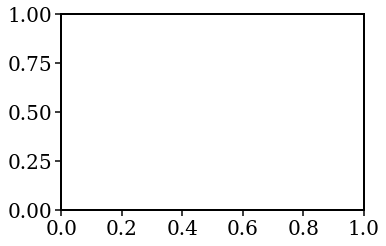

In [13]:
# from src.lib import *
pd.options.mode.chained_assignment = None 
np.warnings.filterwarnings('ignore')

current_dir = '/Volumes/My Passport/TPAGB/'
outcome_dir = 'outcome/'
plot_dir = 'plot/'
numeric_dir = 'numeric/'

plt.tight_layout()
plt.rc('lines', linewidth=3, markersize=2)
plt.rc('font', size=24, family='serif', weight=300)
plt.rc('mathtext', fontset='stix')
plt.rc('axes', linewidth=2)
plt.rc('xtick.major', width=1.5, size=6)
plt.rc('ytick.major', width=1.5, size=6)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.subplots_adjust(bottom=0.2, left=0.2)


In [14]:
def find_nearest(array, value):
    idx = np.argmin(np.abs(array-value))
    return idx
BC_ML = pd.read_csv('/Volumes/My Passport/bc03/src/bc2003_hr_stelib_m62_salp_ssp_1Gyr_csp.4color', delim_whitespace=True, header=None, comment='#', index_col=False)
BC_ML.columns = ['log_age_yr', 'Mbol', 'Bmag', 'Vmag', 'Kmag' ,'M_liv', 'M_remnants', 'M_ret_gas', 'M_galaxy' ,\
				'SFR_yr', 'M_liv_M_rem', 'M_tot_Lb', 'M_tot_Lv', 'M_tot_Lk', 'M_liv_Lb', 'M_liv_Lv', 'M_liv_Lk']
BC_mag = pd.read_csv('/Volumes/My Passport/bc03/src/bc2003_hr_stelib_m62_salp_ssp_1Gyr_csp.1color', delim_whitespace=True, header=None, comment='#', index_col=False)
BC_mag.columns = ['log_age_yr', 'Mbol', 'Umag','Bmag', 'Vmag', 'Kmag' ,'14-V', '17-V', '22-V', '27-V' ,\
				'U-J', 'J-F', 'F-N', 'U-B', 'B-V' ]

M05_ML = pd.read_csv('/Volumes/My Passport/M05_ml_SSP_SDSS.tab.txt', delim_whitespace=True, header=None, comment='#', index_col=False)
M05_ML.columns = ['ZH','t','u','g','r','i','z']
M05_ML_002 = M05_ML[M05_ML.ZH==0.0]

M05_ML_JC = pd.read_csv('/Volumes/My Passport/M05_ml_SSP.tab.txt', delim_whitespace=True, header=None, comment='#', index_col=False)
M05_ML_JC.columns = ['ZH','t',"Bol", 'U', 'B', 'V', 'R', 'I', 'J', 'H', 'K']
M05_ML_002_JC = M05_ML_JC[M05_ML_JC.ZH==0.0]
M05_ML_002_JC = M05_ML_002_JC[:67]

M05_mag = pd.read_csv('/Volumes/My Passport/SSPmags_Mar05_JohnsonCousins.tab', delim_whitespace=True, header=None, comment='#', index_col=False)
M05_mag.columns=['ZH','t',"Bol", 'U', 'B', 'V', 'R', 'I', 'J', 'H', 'K']
def best_model(df_opt,df_photometry,df_cat,df_fast,field):
    """
    input the dataframe
    Return the model with the best-fit values
    """
    #df_opt = df
    df_opt['field'] = field
    for i in range(len(df_opt)):
        ID = int(df_opt.iloc[i].ID)
        #print('ID',ID)
        #print(df_photometry.iloc[ID-1].f_F160W)
        #print(df_photometry.iloc[ID-1].e_F160W)
        if df_opt.iloc[i].model == 1 and df_opt.iloc[i].x2_spectra_M05_opt > 0.5 and df_opt.iloc[i].x2_M05 <60:
#             df_opt.loc[i,'age_opt'] = df_opt.iloc[i].M05_age_opt
#             df_opt.loc[i,'age_opt_std'] = df_opt.iloc[i].M05_age_std
#             df_opt.loc[i,'AV_opt'] = df_opt.iloc[i].M05_AV_opt
#             df_opt.loc[i,'AV_opt_std'] = df_opt.iloc[i].M05_AV_std
            m_AB_K = -2.5*np.log10(df_cat.iloc[ID-1].L163)+25.0
            M_AB_K = m_AB_K - df_cat.iloc[ID-1].DM-df_opt.iloc[i].AV_opt
            df_opt.loc[i,'M_K'] = M_AB_K
            galaxy_age = df_opt.iloc[i].M05_age_opt
            ML_K_index = find_nearest(BC_ML.log_age_yr.unique(), np.log10(galaxy_age*1e9))
            Intensity_ratio = 10**(-0.4*(M_AB_K-5.08))
            ML_K = BC_ML.iloc[ML_K_index].M_tot_Lk
            BC_mass = Intensity_ratio*ML_K
            df_opt.loc[i,'BC_ML'] = ML_K
            df_opt.loc[i,'BC_mass'] = BC_mass
            ML_K_index = find_nearest(M05_ML_002_JC.t.unique(), galaxy_age)
            ML_K = M05_ML_002_JC.iloc[ML_K_index].K
            df_opt.loc[i,'M05_ML'] = ML_K
            M05_mass = Intensity_ratio*ML_K
            df_opt.loc[i,'M05_mass'] = M05_mass
            df_opt.loc[i,'M13_mass'] = M05_mass
            df_opt.loc[i,'best_mass'] = M05_mass
            df_opt.loc[i,'radius'] = df_photometry.iloc[ID-1].a_image
            df_opt.loc[i,'use_phot'] = df_photometry.iloc[ID-1].use_phot
            df_opt.loc[i,'z_best'] = df_cat.iloc[ID-1].z_best
            df_opt.loc[i,'z_type'] = df_cat.iloc[ID-1].z_type
            df_opt.loc[i,'z_spec'] = df_cat.iloc[ID-1].z_spec
            df_opt.loc[i,'use_phot'] = df_photometry.iloc[ID-1].use_phot
            u = -2.5*np.log10(df_cat.iloc[ID-1].L156)+25
            r = -2.5*np.log10(df_cat.iloc[ID-1].L158)+25
            Mu = u - df_cat.iloc[ID-1].DM
            Mr = r - df_cat.iloc[ID-1].DM
            df_opt.loc[i,'U'] = -2.5*np.log10(df_cat.iloc[ID-1].L153)+25
            df_opt.loc[i,'V'] = -2.5*np.log10(df_cat.iloc[ID-1].L155)+25
            df_opt.loc[i,'J'] = -2.5*np.log10(df_cat.iloc[ID-1].L161)+25
            df_opt.loc[i, 'H'] = -2.5*np.log10(df_cat.iloc[ID-1].L162)+25
            df_opt.loc[i,'B'] = -2.5*np.log10(df_cat.iloc[ID-1].L136)+25
            df_opt.loc[i,'K'] = -2.5*np.log10(df_cat.iloc[ID-1].L163)+25
            df_opt.loc[i,'u'] = u
            df_opt.loc[i,'r'] = r
            df_opt.loc[i,'Mr'] = Mr
            df_opt.loc[i,'color'] = u - r
            df_opt.loc[i, 'FAST_mass'] = df_fast.iloc[ID-1].lmass
            df_opt.loc[i, 'SFR'] = df_fast.iloc[ID-1].lsfr
            df_opt.loc[i, 'sSFR'] = df_fast.iloc[ID-1].lssfr
            df_opt.loc[i, 'ltau'] = df_fast.iloc[ID-1].ltau
            df_opt.loc[i, 'SNR_F160W'] = df_photometry.iloc[ID-1].f_F160W/df_photometry.iloc[ID-1].e_F160W
            df_opt.loc[i, 'SNR_F140W'] = df_photometry.iloc[ID-1].f_F140W/df_photometry.iloc[ID-1].e_F140W
            df_opt.loc[i, 'SNR_F125W'] = df_photometry.iloc[ID-1].f_F125W/df_photometry.iloc[ID-1].e_F125W
            #df_opt.loc[i, 'SNR_F814W'] = df_photometry.iloc[ID-1].f_F814W/df_photometry.iloc[ID-1].e_F814W
            df_opt.loc[i, 'SNR_F606W'] = df_photometry.iloc[ID-1].f_F606W/df_photometry.iloc[ID-1].e_F606W
            df_opt.loc[i, 'F160W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F160W)+25
            df_opt.loc[i, 'F140W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F140W)+25
            df_opt.loc[i, 'F125W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F125W)+25
            #df_opt.loc[i, 'F814W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F814W)+25
            df_opt.loc[i, 'F606W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F606W)+25
        elif df_opt.iloc[i].model == 2 and df_opt.iloc[i].x2_spectra_M13_opt > 0.5 and df_opt.iloc[i].x2_M13 <60:
#             df_opt.loc[i,'age_opt'] = df_opt.iloc[i].M13_age_opt
#             df_opt.loc[i,'age_opt_std'] = df_opt.iloc[i].M13_age_std
#             df_opt.loc[i,'AV_opt'] = df_opt.iloc[i].M13_AV_opt
#             df_opt.loc[i,'AV_opt_std'] = df_opt.iloc[i].M13_AV_std
            m_AB_K = -2.5*np.log10(df_cat.iloc[ID-1].L163)+25.0
            M_AB_K = m_AB_K - df_cat.iloc[ID-1].DM-df_opt.iloc[i].AV_opt
            df_opt.loc[i,'M_K'] = M_AB_K
            galaxy_age = df_opt.iloc[i].M13_age_opt
            Intensity_ratio = 10**(-0.4*(M_AB_K-5.08))
            ML_K_index = find_nearest(BC_ML.log_age_yr.unique(), np.log10(galaxy_age*1e9))
            ML_K = BC_ML.iloc[ML_K_index].M_tot_Lk
            BC_mass = Intensity_ratio*ML_K
            df_opt.loc[i,'BC_ML'] = ML_K
            df_opt.loc[i,'BC_mass'] = BC_mass
            ML_K_index = find_nearest(M05_ML_002_JC.t.unique(), galaxy_age)
            ML_K = M05_ML_002_JC.iloc[ML_K_index].K
            df_opt.loc[i,'M05_ML'] = ML_K
            M05_mass = Intensity_ratio*ML_K
            df_opt.loc[i,'M05_mass'] = M05_mass
            df_opt.loc[i,'M13_mass'] = M05_mass
            df_opt.loc[i,'best_mass'] = M05_mass
            df_opt.loc[i,'radius'] = df_photometry.iloc[ID-1].a_image
            df_opt.loc[i,'use_phot'] = df_photometry.iloc[ID-1].use_phot
            df_opt.loc[i,'z_best'] = df_cat.iloc[ID-1].z_best
            df_opt.loc[i,'z_type'] = df_cat.iloc[ID-1].z_type
            df_opt.loc[i,'z_spec'] = df_cat.iloc[ID-1].z_spec
            df_opt.loc[i,'use_phot'] = df_photometry.iloc[ID-1].use_phot
            u = -2.5*np.log10(df_cat.iloc[ID-1].L156)+25
            r = -2.5*np.log10(df_cat.iloc[ID-1].L158)+25
            Mu = u - df_cat.iloc[ID-1].DM
            Mr = r - df_cat.iloc[ID-1].DM
            df_opt.loc[i,'U'] = -2.5*np.log10(df_cat.iloc[ID-1].L153)+25
            df_opt.loc[i,'V'] = -2.5*np.log10(df_cat.iloc[ID-1].L155)+25
            df_opt.loc[i,'J'] = -2.5*np.log10(df_cat.iloc[ID-1].L161)+25
            df_opt.loc[i, 'H'] = -2.5*np.log10(df_cat.iloc[ID-1].L162)+25
            df_opt.loc[i, 'B'] = -2.5 * np.log10(df_cat.iloc[ID - 1].L136) + 25
            df_opt.loc[i, 'K'] = -2.5 * np.log10(df_cat.iloc[ID - 1].L163) + 25
            df_opt.loc[i,'u'] = u
            df_opt.loc[i,'r'] = r
            df_opt.loc[i,'Mr'] = Mr
            df_opt.loc[i,'color'] = u - r
            df_opt.loc[i, 'FAST_mass'] = df_fast.iloc[ID-1].lmass
            df_opt.loc[i, 'SFR'] = df_fast.iloc[ID-1].lsfr
            df_opt.loc[i, 'sSFR'] = df_fast.iloc[ID-1].lssfr
            df_opt.loc[i, 'ltau'] = df_fast.iloc[ID-1].ltau
            df_opt.loc[i, 'SNR_F160W'] = df_photometry.iloc[ID-1].f_F160W/df_photometry.iloc[ID-1].e_F160W
            df_opt.loc[i, 'SNR_F140W'] = df_photometry.iloc[ID-1].f_F140W/df_photometry.iloc[ID-1].e_F140W
            df_opt.loc[i, 'SNR_F125W'] = df_photometry.iloc[ID-1].f_F125W/df_photometry.iloc[ID-1].e_F125W
            #df_opt.loc[i, 'SNR_F814W'] = df_photometry.iloc[ID-1].f_F814W/df_photometry.iloc[ID-1].e_F814W
            df_opt.loc[i, 'SNR_F606W'] = df_photometry.iloc[ID-1].f_F606W/df_photometry.iloc[ID-1].e_F606W
            df_opt.loc[i, 'F160W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F160W)+25
            df_opt.loc[i, 'F140W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F140W)+25
            df_opt.loc[i, 'F125W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F125W)+25
            #df_opt.loc[i, 'F814W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F814W)+25
            df_opt.loc[i, 'F606W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F606W)+25
        elif df_opt.iloc[i].model == 3 and df_opt.iloc[i].x2_spectra_BC_opt > 0.5 and df_opt.iloc[i].x2_BC <60:
#             df_opt.loc[i,'age_opt'] = df_opt.iloc[i].BC_age_opt
#             df_opt.loc[i,'age_opt_std'] = df_opt.iloc[i].BC_age_std
#             df_opt.loc[i,'AV_opt'] = df_opt.iloc[i].BC_AV_opt
#             df_opt.loc[i,'AV_opt_std'] = df_opt.iloc[i].BC_AV_std
            m_AB_K = -2.5*np.log10(df_cat.loc[ID-1].L163)+25.0
            M_AB_K = m_AB_K - df_cat.loc[ID-1].DM-df_opt.iloc[i].AV_opt
            df_opt.loc[i,'M_K'] = M_AB_K
            galaxy_age = df_opt.iloc[i].BC_age_opt
            Intensity_ratio = 10**(-0.4*(M_AB_K-5.08))
            ML_K_index = find_nearest(BC_ML.log_age_yr.unique(), np.log10(galaxy_age*1e9))
            ML_K = BC_ML.iloc[ML_K_index].M_tot_Lk
            BC_mass = Intensity_ratio*ML_K
            df_opt.loc[i,'BC_ML'] = ML_K
            df_opt.loc[i,'BC_mass'] = BC_mass
            ML_K_index = find_nearest(M05_ML_002_JC.t.unique(), galaxy_age)
            ML_K = M05_ML_002_JC.iloc[ML_K_index].K
            df_opt.loc[i,'M05_ML'] = ML_K
            M05_mass = Intensity_ratio*ML_K
            df_opt.loc[i,'M05_mass'] = M05_mass
            df_opt.loc[i,'M13_mass'] = M05_mass
            df_opt.loc[i,'best_mass'] = M05_mass
            df_opt.loc[i,'radius'] = df_photometry.iloc[ID-1].a_image
            df_opt.loc[i,'use_phot'] = df_photometry.iloc[ID-1].use_phot
            df_opt.loc[i,'z_best'] = df_cat.iloc[ID-1].z_best
            df_opt.loc[i,'z_type'] = df_cat.iloc[ID-1].z_type
            df_opt.loc[i,'z_spec'] = df_cat.iloc[ID-1].z_spec
            df_opt.loc[i,'use_phot'] = df_photometry.iloc[ID-1].use_phot
            u = -2.5*np.log10(df_cat.iloc[ID-1].L156)+25
            r = -2.5*np.log10(df_cat.iloc[ID-1].L158)+25
            Mu = u - df_cat.iloc[ID-1].DM
            Mr = r - df_cat.iloc[ID-1].DM
            df_opt.loc[i,'U'] = -2.5*np.log10(df_cat.iloc[ID-1].L153)+25
            df_opt.loc[i,'V'] = -2.5*np.log10(df_cat.iloc[ID-1].L155)+25
            df_opt.loc[i,'J'] = -2.5*np.log10(df_cat.iloc[ID-1].L161)+25
            df_opt.loc[i, 'H'] = -2.5*np.log10(df_cat.iloc[ID-1].L162)+25
            df_opt.loc[i, 'B'] = -2.5 * np.log10(df_cat.iloc[ID - 1].L136) + 25
            df_opt.loc[i, 'K'] = -2.5 * np.log10(df_cat.iloc[ID - 1].L163) + 25
            df_opt.loc[i,'u'] = u
            df_opt.loc[i,'r'] = r
            df_opt.loc[i,'Mr'] = Mr
            df_opt.loc[i,'color'] = u - r
            df_opt.loc[i, 'FAST_mass'] = df_fast.iloc[ID-1].lmass
            df_opt.loc[i, 'SFR'] = df_fast.iloc[ID-1].lsfr
            df_opt.loc[i, 'sSFR'] = df_fast.iloc[ID-1].lssfr
            df_opt.loc[i, 'ltau'] = df_fast.iloc[ID-1].ltau
            df_opt.loc[i, 'SNR_F160W'] = df_photometry.iloc[ID-1].f_F160W/df_photometry.iloc[ID-1].e_F160W
            df_opt.loc[i, 'SNR_F140W'] = df_photometry.iloc[ID-1].f_F140W/df_photometry.iloc[ID-1].e_F140W
            df_opt.loc[i, 'SNR_F125W'] = df_photometry.iloc[ID-1].f_F125W/df_photometry.iloc[ID-1].e_F125W
            #df_opt.loc[i, 'SNR_F814W'] = df_photometry.iloc[ID-1].f_F814W/df_photometry.iloc[ID-1].e_F814W
            df_opt.loc[i, 'SNR_F606W'] = df_photometry.iloc[ID-1].f_F606W/df_photometry.iloc[ID-1].e_F606W
            df_opt.loc[i, 'F160W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F160W)+25
            df_opt.loc[i, 'F140W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F140W)+25
            df_opt.loc[i, 'F125W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F125W)+25
            #df_opt.loc[i, 'F814W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F814W)+25
            df_opt.loc[i, 'F606W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F606W)+25
    # dropping the IDs
    drop_index = []
    for i in df_opt.index:
        #try:
        ID = int(df_opt.iloc[i].ID)
        if df_photometry.iloc[ID-1].class_star>0.8:
            drop_index.append(i)
            print('drop due to class_star',ID)
    print('Dropping index list', field, drop_index)
    df_opt = df_opt.drop(drop_index)
    df_opt = df_opt.fillna(0.0)
    df_opt = df_opt[df_opt.U!=0.0]
    #index_to_drop = np.where(df_photometry.class_star>0.8)[0]
    #print(df_photometry.iloc[index_to_drop].ID)
    #df_opt = df_opt.drop([i for i in df_opt.index if i in index_to_drop])
    return df_opt


In [15]:
aegis_photometry = pd.read_csv('/Volumes/My Passport/aegis_3dhst.v4.1.cats/Catalog/aegis_3dhst.v4.1.cat',
                               delim_whitespace=True, header=None, comment='#', index_col=False)
aegis_photometry.columns = ["id", "x", "y", "ra", "dec", "faper_F160W", "eaper_F160W", "faper_F140W", "eaper_F140W",
                            "f_F160W", "e_F160W", "w_F160W", "f_U", "e_U", "w_U", "f_G", "e_G", "w_G", "f_F606W",
                            "e_F606W", "w_F606W", "f_R", "e_R", "w_R", "f_I", "e_I", "w_I", "f_F814W", "e_F814W",
                            "w_F814W", "f_Z", "e_Z", "w_Z", "f_F125W", "e_F125W", "w_F125W", "f_J1", "e_J1", "w_J1",
                            "f_J2", "e_J2", "w_J2", "f_J3", "e_J3", "w_J3", "f_J", "e_J", "w_J", "f_F140W", "e_F140W",
                            "w_F140W", "f_H1", "e_H1", "w_H1", "f_H2", "e_H2", "w_H2", "f_H", "e_H", "w_H", "f_K",
                            "e_K", "w_K", "f_Ks", "e_Ks", "w_Ks", "f_IRAC1", "e_IRAC1", "w_IRAC1", "f_IRAC2", "e_IRAC2",
                            "w_IRAC2", "f_IRAC3", "e_IRAC3", "w_IRAC3", "f_IRAC4", "e_IRAC4", "w_IRAC4", "tot_cor",
                            "wmin_ground", "wmin_hst", "wmin_irac", "wmin_wfc3", "z_spec", "star_flag", "kron_radius",
                            "a_image", "b_image", "theta_J2000", "class_star", "flux_radius", "fwhm_image", "flags",
                            "IRAC1_contam", "IRAC2_contam", "IRAC3_contam", "IRAC4_contam", "contam_flag", "f140w_flag",
                            "use_phot", "near_star", "nexp_f125w", "nexp_f140w", "nexp_f160w"]
# aegis_photometry= aegis_photometry.set_index('id')
aegis_cat = pd.read_csv('/Volumes/My Passport/aegis_3dhst_v4.1.5_catalogs/aegis_3dhst.v4.1.5.zbest.rf',
                        delim_whitespace=True, header=None, comment='#', index_col=False)
aegis_cat.columns = ["id", "z_best", "z_type", "z_spec", "DM", "L153", "nfilt153", "L154", "nfilt154", "L155",
                     "nfilt155", "L161", "nfilt161", "L162", "nfilt162", "L163", "nfilt163", "L156", "nfilt156", "L157",
                     "nfilt157", "L158", "nfilt158", "L159", "nfilt159", "L160", "nfilt160", "L135", "nfilt135", "L136",
                     "nfilt136", "L137", "nfilt137", "L138", "nfilt138", "L139", "nfilt139", "L270", "nfilt270", "L271",
                     "nfilt271", "L272", "nfilt272", "L273", "nfilt273", "L274", "nfilt274", "L275", "nfilt275"]
# aegis_cat= aegis_cat.set_index('id')
aegis_fast = pd.read_csv('/Volumes/My Passport/aegis_3dhst.v4.1.cats/Fast/aegis_3dhst.v4.1.fout', delim_whitespace=True,
                         header=None, comment='#', index_col=False)
aegis_fast.columns = ['id', 'z', 'ltau', 'metal', 'lage', 'Av', 'lmass', 'lsfr', 'lssfr', 'la2t', 'chi2']
# aegis_fast = aegis_fast.set_index('id')

cosmos_photometry = pd.read_csv('/Volumes/My Passport/cosmos_3dhst.v4.1.cats/Catalog/cosmos_3dhst.v4.1.cat',
                                delim_whitespace=True, header=None, comment='#', index_col=False)
cosmos_photometry.columns = ["id", "x", "y", "ra", "dec", "faper_F160W", "eaper_F160W", "faper_F140W", "eaper_F140W",
                             "f_F160W", "e_F160W", "w_F160W",
                             "f_U", "e_U", "w_U", "f_B", "e_B", "w_B", "f_G", "e_G", "w_G", "f_V", "e_V", "w_V",
                             "f_F606W", "e_F606W", "w_F606W", "f_R", "e_R", "w_R", "f_Rp", "e_Rp", "w_Rp", "f_I", "e_I",
                             "w_I", "f_Ip", "e_Ip", "w_Ip", "f_F814W", "e_F814W", "w_F814W", "f_Z", "e_Z", "w_Z",
                             "f_Zp", "e_Zp", "w_Zp", "f_UVISTA_Y", "e_UVISTA_Y", "w_UVISTA_Y", "f_F125W", "e_F125W",
                             "w_F125W", "f_J1", "e_J1", "w_J1", "f_J2", "e_J2", "w_J2", "f_J3", "e_J3", "w_J3", "f_J",
                             "e_J", "w_J", "f_UVISTA_J", "e_UVISTA_J", "w_UVISTA_J", "f_F140W", "e_F140W", "w_F140W",
                             "f_H1", "e_H1", "w_H1", "f_H2", "e_H2", "w_H2", "f_H", "e_H", "w_H", "f_UVISTA_H",
                             "e_UVISTA_H", "w_UVISTA_H", "f_K", "e_K", "w_K", "f_Ks", "e_Ks", "w_Ks", "f_UVISTA_Ks",
                             "e_UVISTA_Ks", "w_UVISTA_Ks", "f_IRAC1", "e_IRAC1", "w_IRAC1", "f_IRAC2", "e_IRAC2",
                             "w_IRAC2", "f_IRAC3", "e_IRAC3", "w_IRAC3", "f_IRAC4", "e_IRAC4", "w_IRAC4", "f_IA427",
                             "e_IA427", "f_IA464", "e_IA464", "f_IA484", "e_IA484", "f_IA505", "e_IA505", "f_IA527",
                             "e_IA527", "f_IA574", "e_IA574", "f_IA624", "e_IA624", "f_IA679", "e_IA679", "f_IA709",
                             "e_IA709", "f_IA738", "e_IA738", "f_IA767", "e_IA767", "f_IA827", "e_IA827", "tot_cor",
                             "wmin_ground", "wmin_hst", "wmin_irac", "wmin_wfc3", "z_spec", "star_flag", "kron_radius",
                             "a_image", "b_image", "theta_J2000", "class_star", "flux_radius", "fwhm_image", "flags",
                             "IRAC1_contam", "IRAC2_contam", "IRAC3_contam", "IRAC4_contam", "contam_flag",
                             "f140w_flag", "use_phot", "near_star", "nexp_f125w", "nexp_f140w", "nexp_f160w"]
# cosmos_photometry= cosmos_photometry.set_index('id')
cosmos_cat = pd.read_csv('/Volumes/My Passport/cosmos_3dhst_v4.1.5_catalogs/cosmos_3dhst.v4.1.5.zbest.rf',
                         delim_whitespace=True, header=None, comment='#', index_col=False)
cosmos_cat.columns = ["id", "z_best", "z_type", "z_spec", "DM", "L153", "nfilt153", "L154", "nfilt154", "L155",
                      "nfilt155", "L161", "nfilt161", "L162", "nfilt162", "L163", "nfilt163", "L156", "nfilt156",
                      "L157", "nfilt157", "L158", "nfilt158", "L159", "nfilt159",
                      "L160", "nfilt160", "L135", "nfilt135", "L136", "nfilt136", "L137", "nfilt137", "L138",
                      "nfilt138", "L139", "nfilt139",
                      "L270", "nfilt270", "L271", "nfilt271", "L272", "nfilt272", "L273", "nfilt273", "L274",
                      "nfilt274", "L275", "nfilt275"]
# cosmos_cat = cosmos_cat.set_index('id')
cosmos_fast = pd.read_csv('/Volumes/My Passport/cosmos_3dhst.v4.1.cats/Fast/cosmos_3dhst.v4.1.fout',
                          delim_whitespace=True, header=None, comment='#', index_col=False)
cosmos_fast.columns = ['id', 'z', 'ltau', 'metal', 'lage', 'Av', 'lmass', 'lsfr', 'lssfr', 'la2t', 'chi2']
# cosmos_fast = cosmos_fast.set_index('id')

goodsn_photometry = pd.read_csv('/Volumes/My Passport/goodsn_3dhst.v4.1.cats/Catalog/goodsn_3dhst.v4.1.cat',
                                delim_whitespace=True, header=None, comment='#', index_col=False)
goodsn_photometry.columns = ["id", "x", "y", "ra", "dec", "faper_F160W", "eaper_F160W", "faper_F140W", "eaper_F140W",
                             "f_F160W", "e_F160W", "w_F160W", \
                             "f_U", "e_U", "w_U", "f_F435W", "e_F435W", "w_F435W", "f_B", "e_B", "w_B", "f_G", "e_G",
                             "w_G", "f_V", "e_V", "w_V", "f_F606W", "e_F606W", "w_F606W", \
                             "f_R", "e_R", "w_R", "f_Rs", "e_Rs", "w_Rs", "f_I", "e_I", "w_I", \
                             "f_F775W", "e_F775W", "w_F775W", "f_Z", "e_Z", "w_Z", "f_F850LP", "e_F850LP", "w_F850LP", \
                             "f_F125W", "e_F125W", "w_F125W", "f_J", "e_J", "w_J", "f_F140W", "e_F140W", "w_F140W", \
                             "f_H", "e_H", "w_H", "f_Ks", "e_Ks", "w_Ks", "f_IRAC1", "e_IRAC1", "w_IRAC1", "f_IRAC2",
                             "e_IRAC2", "w_IRAC2", \
                             "f_IRAC3", "e_IRAC3", "w_IRAC3", "f_IRAC4", "e_IRAC4", "w_IRAC4", \
                             "tot_cor", "wmin_ground", \
                             "wmin_hst", "wmin_wfc3", "wmin_irac", "z_spec", "star_flag", "kron_radius", \
                             "a_image", "b_image", "theta_J2000", "class_star", "flux_radius", "fwhm_image", \
                             "flags", "IRAC1_contam", "IRAC2_contam", "IRAC3_contam", "IRAC4_contam", "contam_flag", \
                             "f140w_flag", "use_phot", "near_star", "nexp_f125w", "nexp_f140w", "nexp_f160w"]
# goodsn_photometry= goodsn_photometry.set_index('id')
goodsn_cat = pd.read_csv('/Volumes/My Passport/goodsn_3dhst_v4.1.5_catalogs/goodsn_3dhst.v4.1.5.zbest.rf',
                         delim_whitespace=True, header=None, comment='#', index_col=False)
goodsn_cat.columns = ["id", "z_best", "z_type", "z_spec", "DM", "L153", "nfilt153", "L154", "nfilt154", "L155",
                      "nfilt155", "L161", "nfilt161", "L162", "nfilt162", "L163", \
                      "nfilt163", "L156", "nfilt156", "L157", "nfilt157", "L158", "nfilt158", "L159", "nfilt159",
                      "L160", "nfilt160", "L135", "nfilt135", "L136", "nfilt136", \
                      "L137", "nfilt137", "L138", "nfilt138", "L139", "nfilt139", "L270", "nfilt270", "L271",
                      "nfilt271", "L272", "nfilt272", "L273", "nfilt273", "L274", "nfilt274", "L275", "nfilt275"]
# goodsn_cat = goodsn_cat.set_index('id')
goodsn_fast = pd.read_csv('/Volumes/My Passport/goodsn_3dhst.v4.1.cats/Fast/goodsn_3dhst.v4.1.fout',
                          delim_whitespace=True, header=None, comment='#', index_col=False)
goodsn_fast.columns = ['id', 'z', 'ltau', 'metal', 'lage', 'Av', 'lmass', 'lsfr', 'lssfr', 'la2t', 'chi2']
# goodsn_fast = goodsn_fast.set_index('id')

goodss_photometry = pd.read_csv('/Volumes/My Passport/goodss_3dhst.v4.1.cats/Catalog/goodss_3dhst.v4.1.cat',
                                delim_whitespace=True, header=None, comment='#', index_col=False)
goodss_photometry.columns = ["id", "x", "y", "ra", "dec", "faper_F160W", "eaper_F160W", "faper_F140W", "eaper_F140W",
                             "f_F160W", "e_F160W", "w_F160W", \
                             "f_U38", "e_U38", "w_U38", "f_U", "e_U", "w_U", "f_F435W", "e_F435W", "w_F435W", "f_B",
                             "e_B", "w_B", "f_V", "e_V", "w_V", \
                             "f_F606Wcand", "e_F606Wcand", "w_F606Wcand", "f_F606W", "e_F606W", "w_F606W", "f_R", "e_R",
                             "w_R", "f_Rc", "e_Rc", "w_Rc", \
                             "f_F775W", "e_F775W", "w_F775W", "f_I", "e_I", "w_I", "f_F814Wcand", "e_F814Wcand",
                             "w_F814Wcand", "f_F850LP", "e_F850LP", "w_F850LP", \
                             "f_F850LPcand", "e_F850LPcand", "w_F850LPcand", "f_F125W", "e_F125W", "w_F125W", "f_J",
                             "e_J", "w_J", "f_tenisJ", "e_tenisJ", "w_tenisJ", \
                             "f_F140W", "e_F140W", "w_F140W", "f_H", "e_H", "w_H", "f_tenisK", "e_tenisK", "w_tenisK",
                             "f_Ks", "e_Ks", "w_Ks", \
                             "f_IRAC1", "e_IRAC1", "w_IRAC1", "f_IRAC2", "e_IRAC2", "w_IRAC2", "f_IRAC3", "e_IRAC3",
                             "w_IRAC3", "f_IRAC4", "e_IRAC4", "w_IRAC4", \
                             "f_IA427", "e_IA427", "f_IA445", "e_IA445", "f_IA505", "e_IA505", "f_IA527", "e_IA527",
                             "f_IA550", "e_IA550", "f_IA574", "e_IA574", \
                             "f_IA598", "e_IA598", "f_IA624", "e_IA624", "f_IA651", "e_IA651", "f_IA679", "e_IA679",
                             "f_IA738", "e_IA738", "f_IA767", "e_IA767", \
                             "f_IA797", "e_IA797", "f_IA856", "e_IA856", "tot_cor", "wmin_ground", "wmin_hst",
                             "wmin_wfc3", "wmin_irac", "z_spec", "star_flag", \
                             "kron_radius", "a_image", "b_image", "theta_J2000", "class_star", "flux_radius",
                             "fwhm_image", "flags", "IRAC1_contam", "IRAC2_contam", \
                             "IRAC3_contam", "IRAC4_contam", "contam_flag", "f140w_flag", "use_phot", "near_star",
                             "nexp_f125w", "nexp_f140w", "nexp_f160w"]
# goodss_photometry = goodss_photometry.set_index('id')
goodss_cat = pd.read_csv('/Volumes/My Passport/goodss_3dhst_v4.1.5_catalogs/goodss_3dhst.v4.1.5.zbest.rf',
                         delim_whitespace=True, header=None, comment='#', index_col=False)
goodss_cat.columns = ["id", "z_best", "z_type", "z_spec", "DM", "L153", "nfilt153", "L154", "nfilt154", "L155",
                      "nfilt155", "L161", "nfilt161", "L162", "nfilt162", \
                      "L163", "nfilt163", "L156", "nfilt156", "L157", "nfilt157", "L158", "nfilt158", "L159",
                      "nfilt159", "L160", "nfilt160", "L135", "nfilt135", "L136", "nfilt136", \
                      "L137", "nfilt137", "L138", "nfilt138", "L139", "nfilt139", "L270", "nfilt270", "L271",
                      "nfilt271", "L272", "nfilt272", "L273", "nfilt273", "L274", "nfilt274", "L275", "nfilt275"]
# goodss_cat = goodss_cat.set_index('id')
goodss_fast = pd.read_csv('/Volumes/My Passport/goodss_3dhst.v4.1.cats/Fast/goodss_3dhst.v4.1.fout',
                          delim_whitespace=True, header=None, comment='#', index_col=False)
goodss_fast.columns = ['id', 'z', 'ltau', 'metal', 'lage', 'Av', 'lmass', 'lsfr', 'lssfr', 'la2t', 'chi2']
# goodss_fast = goodss_fast.set_index('id')

uds_photometry = pd.read_csv('/Volumes/My Passport/uds_3dhst.v4.2.cats/Catalog/uds_3dhst.v4.2.cat',
                             delim_whitespace=True, header=None, comment='#', index_col=False)
uds_photometry.columns = ["id", "x", "y", "ra", "dec", "faper_F160W", "eaper_F160W", "faper_F140W", "eaper_F140W",
                          "f_F160W", "e_F160W", "w_F160W", \
                          "f_u", "e_u", "w_u", "f_B", "e_B", "w_B", "f_V", "e_V", "w_V", "f_F606W", "e_F606W",
                          "w_F606W", \
                          "f_R", "e_R", "w_R", "f_i", "e_i", "w_i", "f_F814W", "e_F814W", "w_F814W", "f_z", "e_z",
                          "w_z", \
                          "f_F125W", "e_F125W", "w_F125W", "f_J", "e_J", "w_J", "f_F140W", "e_F140W", "w_F140W", \
                          "f_H", "e_H", "w_H", "f_K", "e_K", "w_K", "f_IRAC1", "e_IRAC1", "w_IRAC1", "f_IRAC2",
                          "e_IRAC2", "w_IRAC2", \
                          "f_IRAC3", "e_IRAC3", "w_IRAC3", "f_IRAC4", "e_IRAC4", "w_IRAC4", "tot_cor", "wmin_ground",
                          "wmin_hst", "wmin_wfc3", \
                          "wmin_irac", "z_spec", "star_flag", "kron_radius", "a_image", "b_image", "theta_J2000",
                          "class_star", "flux_radius", "fwhm_image", \
                          "flags", "IRAC1_contam", "IRAC2_contam", "IRAC3_contam", "IRAC4_contam", "contam_flag",
                          "f140w_flag", "use_phot", "near_star", "nexp_f125w", "nexp_f140w", "nexp_f160w"]
# uds_photometry = uds_photometry.set_index('id')
uds_cat = pd.read_csv('/Volumes/My Passport/uds_3dhst_v4.1.5_catalogs/uds_3dhst.v4.1.5.zbest.rf', delim_whitespace=True,
                      header=None, comment='#', index_col=False)
uds_cat.columns = ["id", "z_best", "z_type", "z_spec", "DM", "L153", "nfilt153", "L154", "nfilt154", "L155", "nfilt155",
                   "L161", "nfilt161", "L162", "nfilt162", \
                   "L163", "nfilt163", "L156", "nfilt156", "L157", "nfilt157", "L158", "nfilt158", "L159", "nfilt159",
                   "L160", "nfilt160", "L135", "nfilt135", "L136", "nfilt136", \
                   "L137", "nfilt137", "L138", "nfilt138", "L139", "nfilt139", "L270", "nfilt270", "L271", "nfilt271",
                   "L272", "nfilt272", "L273", "nfilt273", "L274", "nfilt274", "L275", "nfilt275"]
# uds_cat = uds_cat.set_index('id')
uds_fast = pd.read_csv('/Volumes/My Passport/uds_3dhst.v4.2.cats/Fast/uds_3dhst.v4.2.fout', delim_whitespace=True,
                       header=None, comment='#', index_col=False)
uds_fast.columns = ['id', 'z', 'ltau', 'metal', 'lage', 'Av', 'lmass', 'lsfr', 'lssfr', 'la2t', 'chi2']



In [76]:
All_opt = pd.read_csv('/Volumes/My Passport/TPAGB/database/Fitting_result_best_model_20200408.csv')
All_opt = All_opt.reset_index(drop=True)
All_opt = All_opt.drop(columns='Unnamed: 0')

aegis_opt = All_opt[All_opt.field=='aegis']
aegis_opt = aegis_opt.reset_index(drop=True)
cosmos_opt = All_opt[All_opt.field=='cosmos']
cosmos_opt = cosmos_opt.reset_index(drop=True)
goodsn_opt = All_opt[All_opt.field=='goodsn']
goodsn_opt = goodsn_opt.reset_index(drop=True)
goodss_opt = All_opt[All_opt.field=='goodss']
goodss_opt = goodss_opt.reset_index(drop=True)
uds_opt = All_opt[All_opt.field=='uds']
uds_opt = uds_opt.reset_index(drop=True)
uds_opt

,ID,region,field,M05_age_opt,M05_AV_opt,M13_age_opt,M13_AV_opt,BC_age_opt,BC_AV_opt,x2_spectra_M05_opt,...,sSFR,ltau,SNR_F160W,SNR_F140W,SNR_F125W,SNR_F606W,F160W_mag,F140W_mag,F125W_mag,F606W_mag
0,30794,1,uds,0.982537,0.1587376955,0.414129,1.018191,3.249958,0.084032,3.189345,...,-10.65,9.2,220.367414,175.494312,276.389388,198.285410,20.866094,20.942417,21.053524,22.443628
1,33214,1,uds,1.225753,0.3469497101,0.640865,1.037192,1.800001,0.511302,7.305615,...,-11.09,8.6,557.340464,503.377094,737.690105,338.775513,19.734792,19.861336,20.054531,21.934526
2,34421,1,uds,1.122824,0.519450551,0.582970,1.272586,1.679961,0.810927,5.252465,...,-11.09,8.6,557.266646,506.821189,722.707417,317.644471,19.892111,20.032005,20.225591,22.193532
3,18742,2,uds,0.963492,0,0.404173,0.621641,0.303575,1.091433,88.598748,...,-10.54,8.0,418.400392,708.762377,1147.512498,566.634564,18.961717,19.090228,19.207442,20.839541
4,24607,2,uds,2.691882,0.4545640783,2.000000,0.563211,3.125004,0.307640,1.651169,...,-11.78,8.6,236.010318,272.297624,397.507199,84.924797,20.304048,20.460750,20.670580,23.384236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,37581,26,uds,2.016706,0.2058115667,1.235194,0.578887,1.309114,0.635733,5.454037,...,-11.61,8.4,367.747336,647.993895,901.143030,306.878458,19.159191,19.293519,19.499074,21.917128
92,37852,26,uds,1.394634,0.1487495548,1.030002,0.544557,1.356052,0.552567,5.950036,...,-11.61,8.4,411.808179,474.832649,597.724023,265.643745,19.805005,19.937925,20.175889,22.387220
93,38439,26,uds,1.434121,0.3755237142,1.148237,0.717760,1.278099,0.672507,4.873170,...,-99.00,7.0,397.513342,331.133768,530.437011,181.560373,20.239711,20.386295,20.572051,22.748291
94,12505,28,uds,1.200576,0.3292794176,0.999509,0.753829,2.875000,0.231519,3.940868,...,-11.28,8.8,301.254264,550.256395,544.219980,576.215635,19.926372,20.021093,20.189424,21.792525


In [17]:
# 3 Define the functions


def SSP_BC_CN(BC_ssp,bin_size=1):
    for i in range(len(BC03_age_list)):
        galaxy_age_1 = float(BC03_age_list[i])/1e9
        age_index_1 = find_nearest(BC03_age_list_num, galaxy_age_1)
        model3_flux_1 = BC03_flux_array[age_index_1, :7125]   
        BC03_flux_attenuated_1 = model3_flux_1#*spectra_flux_correction
        BC03_flux_norm_1 = BC03_flux_attenuated_1[2556]
        BC03_flux_attenuated_1 = BC03_flux_attenuated_1/BC03_flux_norm_1

        BC03_wave_list_num_binned,BC03_flux_attenuated_binned=binning_spec_keep_shape(BC03_wave_list_num, BC03_flux_attenuated_1,bin_size)
        
        BC_ssp[i]=Lick_index_ratio(BC03_wave_list_num_binned, BC03_flux_attenuated_binned)

    return BC_ssp
def SSP_BC_CN_smoothed(BC_ssp,kernel=1):
    for i in range(len(BC03_age_list)):
        galaxy_age_1 = float(BC03_age_list[i])/1e9
        age_index_1 = find_nearest(BC03_age_list_num, galaxy_age_1)
        model3_flux_1 = BC03_flux_array[age_index_1, :7125]   
        BC03_flux_attenuated_1 = model3_flux_1#*spectra_flux_correction
        BC03_flux_norm_1 = BC03_flux_attenuated_1[2556]
        BC03_flux_attenuated_1 = BC03_flux_attenuated_1/BC03_flux_norm_1

        #kernel = 3
        g = Gaussian1DKernel(stddev=kernel)
        BC03_flux_attenuated_smoothed  = convolve(BC03_flux_attenuated_1, g)
        #BC03_flux_attenuated_binned=binning_spec_keep_shape(BC03_wave_list_num, BC03_flux_attenuated_1,bin_size)
        
        BC_ssp[i]=Lick_index_ratio(BC03_wave_list_num, BC03_flux_attenuated_smoothed)        

    return BC_ssp

def SSP_M05_CN(M05_SSP,bin_size=1):
    index_age = 0
    for i in range(len(df_Ma.Age.unique())):
        galaxy_age_1 = df_Ma.Age.unique()[i]
        #galaxy_age_2 = 10
        age_index_1 = find_nearest(df_Ma.Age.unique(), galaxy_age_1)
        age_prior = df_Ma.Age.unique()[age_index_1]
        galaxy_age_string = str(age_prior)
        split_galaxy_age_string = str(galaxy_age_string).split('.')

        #### Galaxy_age_1
        galaxy_age = galaxy_age_1
        if age_prior < 1:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
            model1 = np.genfromtxt(fn1)
        elif age_prior == 1.5:
            if galaxy_age >=1.25 and galaxy_age <1.5:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 1.5 and galaxy_age < 1.75:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif len(split_galaxy_age_string[1])==1:
            if galaxy_age >= 1.0 and galaxy_age < 1.25:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
            elif galaxy_age >=1.75 and galaxy_age < 2.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
            elif galaxy_age >= 2.0 and galaxy_age < 3.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 3.0 and galaxy_age < 4.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 4.0 and galaxy_age < 5.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 5.0 and galaxy_age < 6.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 6.0 and galaxy_age < 7.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 7.0 and galaxy_age < 8.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 8.0 and galaxy_age < 9.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 9.0 and galaxy_age < 10.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 10.0 and galaxy_age < 11.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 11.0 and galaxy_age < 12.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 12.0 and galaxy_age < 13.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 13.0 and galaxy_age < 14.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 14.0 and galaxy_age < 15.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_15_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
            else:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
                model1 = np.genfromtxt(fn1)

        M05_flux_center = model1[1,:]#*spectra_flux_correction
        F_M05_index=167
        Flux_M05_norm_new = M05_flux_center[F_M05_index]
        smooth_Flux_Ma_1Gyr_new_1 = M05_flux_center/Flux_M05_norm_new
    
        wave_binned,smooth_Flux_Ma_1Gyr_binned = binning_spec_keep_shape(model1[0,:], smooth_Flux_Ma_1Gyr_new_1,bin_size)
        
        M05_SSP[index_age]=Lick_index_ratio(wave_binned, smooth_Flux_Ma_1Gyr_binned)
        index_age += 1
    return M05_SSP
def SSP_M05_CN_smoothed(M05_SSP,kernel=1):
    index_age = 0
    for i in range(len(df_Ma.Age.unique())):
        galaxy_age_1 = df_Ma.Age.unique()[i]
        #galaxy_age_2 = 10
        age_index_1 = find_nearest(df_Ma.Age.unique(), galaxy_age_1)
        age_prior = df_Ma.Age.unique()[age_index_1]
        galaxy_age_string = str(age_prior)
        split_galaxy_age_string = str(galaxy_age_string).split('.')

        #### Galaxy_age_1
        galaxy_age = galaxy_age_1
        if age_prior < 1:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
            model1 = np.genfromtxt(fn1)
        elif age_prior == 1.5:
            if galaxy_age >=1.25 and galaxy_age <1.5:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 1.5 and galaxy_age < 1.75:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif len(split_galaxy_age_string[1])==1:
            if galaxy_age >= 1.0 and galaxy_age < 1.25:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
            elif galaxy_age >=1.75 and galaxy_age < 2.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
            elif galaxy_age >= 2.0 and galaxy_age < 3.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 3.0 and galaxy_age < 4.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 4.0 and galaxy_age < 5.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 5.0 and galaxy_age < 6.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 6.0 and galaxy_age < 7.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 7.0 and galaxy_age < 8.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 8.0 and galaxy_age < 9.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 9.0 and galaxy_age < 10.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 10.0 and galaxy_age < 11.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 11.0 and galaxy_age < 12.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 12.0 and galaxy_age < 13.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 13.0 and galaxy_age < 14.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 14.0 and galaxy_age < 15.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_15_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
            else:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
                model1 = np.genfromtxt(fn1)

        M05_flux_center = model1[1,:]#*spectra_flux_correction
        F_M05_index=167
        Flux_M05_norm_new = M05_flux_center[F_M05_index]
        smooth_Flux_Ma_1Gyr_new_1 = M05_flux_center/Flux_M05_norm_new
    
        #smooth_Flux_Ma_1Gyr_binned = binning_spec_keep_shape(model1[0,:], smooth_Flux_Ma_1Gyr_new_1,bin_size)
        g = Gaussian1DKernel(stddev=kernel)
        smooth_Flux_Ma_1Gyr_smoothed  = convolve(smooth_Flux_Ma_1Gyr_new_1, g)
        
        M05_SSP[index_age]=Lick_index_ratio(model1[0,:], smooth_Flux_Ma_1Gyr_smoothed)
        index_age += 1
    return M05_SSP

def SSP_M13_CN(M13_SSP,bin_size=1):
    index_age = 0
    intrinsic_Av=0.0
    for i in range(len(df_M13.Age.unique())):
        galaxy_age = df_M13.Age.unique()[i]
        age_index = find_nearest(df_M13.Age.unique(), galaxy_age)
        age_prior = df_M13.Age.unique()[age_index]
        galaxy_age_string = str(age_prior)
        split_galaxy_age_string = str(galaxy_age_string).split('.')
        
        if age_prior < 1e-4:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_0001_Av_00_z002.csv'
            #print(fn1)
            model2 = np.genfromtxt(fn1)
        elif age_prior < 1 and age_prior>=1e-4:
            #try:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
            #print(fn1)
            model2 = np.genfromtxt(fn1)
            #except:
            #    break
        elif age_prior == 1.5:
            if galaxy_age >=1.25 and galaxy_age <1.5:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif len(split_galaxy_age_string[1])==1:
            if galaxy_age >= 1.0 and galaxy_age < 1.25:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
            elif galaxy_age >=1.75 and galaxy_age < 2.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
            elif galaxy_age >= 2.0 and galaxy_age < 3.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 3.0 and galaxy_age < 4.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 4.0 and galaxy_age < 5.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 5.0 and galaxy_age < 6.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 6.0 and galaxy_age < 7.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 7.0 and galaxy_age < 8.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 8.0 and galaxy_age < 9.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 9.0 and galaxy_age < 10.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 10.0 and galaxy_age < 11.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 11.0 and galaxy_age < 12.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 12.0 and galaxy_age < 13.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 13.0 and galaxy_age < 14.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 14.0 and galaxy_age < 15.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_15_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
            else:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
                model2 = np.genfromtxt(fn1)
        M13_flux_center = model2[1,:]#*spectra_flux_correction
        F_M13_index = 126##np.where(abs(model2[0,:]-norm_wavelength)<10.5)[0][0]
        #print(F_M13_index)
        Flux_M13_norm_new = M13_flux_center[F_M13_index]
        smooth_Flux_M13_1Gyr_new = M13_flux_center/Flux_M13_norm_new

        wave_binned,smooth_Flux_M13_1Gyr_binned = binning_spec_keep_shape(model2[0,:], smooth_Flux_M13_1Gyr_new,bin_size)
        
        M13_SSP[index_age]=Lick_index_ratio(wave_binned, smooth_Flux_M13_1Gyr_binned)
        index_age += 1
    return M13_SSP
def SSP_M13_CN_smoothed(M13_SSP,kernel=1):
    index_age = 0
    intrinsic_Av=0.0
    for i in range(len(df_M13.Age.unique())):
        galaxy_age = df_M13.Age.unique()[i]
        age_index = find_nearest(df_M13.Age.unique(), galaxy_age)
        age_prior = df_M13.Age.unique()[age_index]
        galaxy_age_string = str(age_prior)
        split_galaxy_age_string = str(galaxy_age_string).split('.')
        
        if age_prior < 1e-4:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_0001_Av_00_z002.csv'
            #print(fn1)
            model2 = np.genfromtxt(fn1)
        elif age_prior < 1 and age_prior>=1e-4:
            #try:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
            #print(fn1)
            model2 = np.genfromtxt(fn1)
            #except:
            #    break
        elif age_prior == 1.5:
            if galaxy_age >=1.25 and galaxy_age <1.5:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif len(split_galaxy_age_string[1])==1:
            if galaxy_age >= 1.0 and galaxy_age < 1.25:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
            elif galaxy_age >=1.75 and galaxy_age < 2.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
            elif galaxy_age >= 2.0 and galaxy_age < 3.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 3.0 and galaxy_age < 4.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 4.0 and galaxy_age < 5.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 5.0 and galaxy_age < 6.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 6.0 and galaxy_age < 7.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 7.0 and galaxy_age < 8.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 8.0 and galaxy_age < 9.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 9.0 and galaxy_age < 10.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 10.0 and galaxy_age < 11.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 11.0 and galaxy_age < 12.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 12.0 and galaxy_age < 13.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 13.0 and galaxy_age < 14.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 14.0 and galaxy_age < 15.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_15_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
            else:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
                model2 = np.genfromtxt(fn1)
        M13_flux_center = model2[1,:]#*spectra_flux_correction
        F_M13_index = 126##np.where(abs(model2[0,:]-norm_wavelength)<10.5)[0][0]
        #print(F_M13_index)
        Flux_M13_norm_new = M13_flux_center[F_M13_index]
        smooth_Flux_M13_1Gyr_new = M13_flux_center/Flux_M13_norm_new

        #smooth_Flux_M13_1Gyr_binned = binning_spec_keep_shape(model2[0,:], smooth_Flux_M13_1Gyr_new,bin_size)
        g = Gaussian1DKernel(stddev=kernel)
        smooth_Flux_M13_1Gyr_smoothed = convolve(smooth_Flux_M13_1Gyr_new, g)

        M13_SSP[index_age]=Lick_index_ratio(model2[0,:], smooth_Flux_M13_1Gyr_smoothed)
        index_age += 1
    return M13_SSP


In [18]:
## M05
norm_wavelength= 5500.0


df_Ma = pd.read_csv('/Volumes/My Passport/M09_ssp_pickles.sed',delim_whitespace=True,header=None,comment='#',index_col=False)# only solar metallicity is contained in this catalogue
df_Ma.columns = ['Age','ZH','l','Flambda']
age = df_Ma.Age
metallicity = df_Ma.ZH
wavelength = df_Ma.l
Flux = df_Ma.Flambda
# Select ou the model that is 1Gyr and with solar metallicity: select out the age=1Gyr slice
age_1Gyr_index = np.where(age==age.unique()[30])[0]
age_1Gyr = age[age_1Gyr_index]
#print(age_1Gyr)
metallicity_1Gyr = metallicity[age_1Gyr_index]
wavelength_1Gyr = wavelength[age_1Gyr_index]
Flux_1Gyr = Flux[age_1Gyr_index]
# Find out the normalization flux to be applied.
F_5500_1Gyr_index=np.where(wavelength_1Gyr==norm_wavelength)[0]
F_5500_1Gyr = Flux_1Gyr[wavelength_1Gyr==norm_wavelength].values # this is the band to be normalized



## 1.3 M13
df_M13 = pd.read_csv('/Volumes/My Passport/M13_models/sed_M13.ssz002',delim_whitespace=True,header=None,comment='#',index_col=False)
df_M13.columns = ['Age','ZH','l','Flambda']
age_M13 = df_M13.Age
metallicity_M13 = df_M13.ZH
wavelength_M13 = df_M13.l
Flux_M13 = df_M13.Flambda

age_1Gyr_index_M13 = np.where(age_M13==age_M13.unique()[51])[0]#[0]
age_1Gyr_M13 = age_M13[age_1Gyr_index_M13]
metallicity_1Gyr_M13 = metallicity_M13[age_1Gyr_index_M13]
wavelength_1Gyr_M13 = wavelength_M13[age_1Gyr_index_M13]
Flux_1Gyr_M13 = Flux_M13[age_1Gyr_index_M13]

# Find out the normalization flux to be applied
F_5500_1Gyr_index_M13=np.where(abs(wavelength_1Gyr_M13-norm_wavelength)<15)[0]
F_5500_1Gyr_M13 = 0.5*(Flux_1Gyr_M13.loc[62271+F_5500_1Gyr_index_M13[0]]+Flux_1Gyr_M13.loc[62271+F_5500_1Gyr_index_M13[1]])


df_BC = pd.read_csv('/Volumes/My Passport/ssp_900Myr_z02.spec',delim_whitespace=True,header=None,comment='#',index_col=False)
df_BC.columns=['Lambda','Flux']
wavelength_BC = df_BC.Lambda
Flux_BC = df_BC.Flux
F_6000_BC_index=np.where(wavelength_BC==norm_wavelength)[0]
Flux_BC_norm = Flux_BC[F_6000_BC_index]

BC03_fn = '/Volumes/My Passport/bc03/models/Stelib_Atlas/Salpeter_IMF/bc2003_hr_stelib_m62_salp_ssp.ised_ASCII'
BC03_file = open(BC03_fn,"r")
BC03_X = []
for line in BC03_file:
    BC03_X.append(line)
BC03_SSP_m62 = np.array(BC03_X)
BC03_age_list = np.array(BC03_SSP_m62[0].split()[1:])
BC03_age_list_num = BC03_age_list.astype(np.float)/1.0e9 # unit is Gyr
#print(BC03_age_list_num)
BC03_wave_list = np.array(BC03_SSP_m62[6].split()[1:])
BC03_wave_list_num = BC03_wave_list.astype(np.float)
BC03_flux_list = np.array(BC03_SSP_m62[7:-12])
BC03_flux_array = np.zeros((221,7178))
for i in range(221):
    BC03_flux_array[i,:] = BC03_flux_list[i].split()[1:]
    BC03_flux_array[i,:] = BC03_flux_array[i,:]/BC03_flux_array[i,2556]# Normalize the flux

In [20]:
def binning_spec_keep_shape(wave,flux,bin_size):
    wave_binned = wave
    flux_binned = np.zeros(len(wave))
    for i in range((int(len(wave)/bin_size))):
        flux_binned[bin_size*i:bin_size*(i+1)] = np.mean(flux[bin_size*i:bin_size*(i+1)])
    return wave_binned, flux_binned#, flux_err_binned
def Lick_index_ratio(wave, flux, band=3):
    if band == 3:
        blue_min = 1.06e4  # 1.072e4#
        blue_max = 1.08e4  # 1.08e4#
        red_min = 1.12e4  # 1.097e4#
        red_max = 1.14e4  # 1.106e4#
        band_min = blue_max
        band_max = red_min


    # Blue
    blue_mask = (wave >= blue_min) & (wave <= blue_max)
    blue_wave = wave[blue_mask]
    blue_flux = flux[blue_mask]

    # Red
    red_mask = (wave >= red_min) & (wave <= red_max)
    red_wave = wave[red_mask]
    red_flux = flux[red_mask]

    band_mask = (wave >= band_min) & (wave <= band_max)
    band_wave = wave[band_mask]
    band_flux = flux[band_mask]

    if len(blue_wave) == len(red_wave) and len(blue_wave) != 0:
        ratio = np.mean(blue_flux) / np.mean(red_flux)
    elif red_wave == []:
        ratio = np.mean(blue_flux) / np.mean(red_flux)
    elif len(blue_wave) != 0 and len(red_wave) != 0:
        ratio = np.mean(blue_flux) / np.mean(red_flux)

    # ratio_err = np.sqrt(np.sum(1/red_flux**2*blue_flux_err**2)+np.sum((blue_flux/red_flux**2*red_flux_err)**2))

    return ratio  # , ratio_err

In [35]:
# 4 Load the model files and generate the model curves

# G141 grism spectra resolution: 1.1e4/130 = 84.6
# delta lambda = 25
Lick_index_list_BC03_SSP = np.zeros(len(BC03_age_list))
Lick_index_list_BC03_SSP = SSP_BC_CN(Lick_index_list_BC03_SSP)
Lick_index_list_BC03_SSP_bin_3 = np.zeros(len(BC03_age_list))
Lick_index_list_BC03_SSP_bin_3 = SSP_BC_CN(Lick_index_list_BC03_SSP_bin_3,3)
Lick_index_list_BC03_SSP_bin_21 = np.zeros(len(BC03_age_list))
Lick_index_list_BC03_SSP_bin_21 = SSP_BC_CN(Lick_index_list_BC03_SSP_bin_21,21)
Lick_index_list_BC03_SSP_smoothed_3 = np.zeros(len(BC03_age_list))
Lick_index_list_BC03_SSP_smoothed_3 = SSP_BC_CN_smoothed(Lick_index_list_BC03_SSP_smoothed_3,3)
Lick_index_list_BC03_SSP_smoothed_21 = np.zeros(len(BC03_age_list))
Lick_index_list_BC03_SSP_smoothed_21 = SSP_BC_CN_smoothed(Lick_index_list_BC03_SSP_smoothed_21,21)


#delta lambda = 15
Lick_index_list_M05_SSP = np.zeros(len(df_Ma.Age.unique()))
Lick_index_list_M05_SSP=SSP_M05_CN(Lick_index_list_M05_SSP)
Lick_index_list_M05_SSP_bin_6 = np.zeros(len(df_Ma.Age.unique()))
Lick_index_list_M05_SSP_bin_6 = SSP_M05_CN(Lick_index_list_M05_SSP_bin_6,6)
Lick_index_list_M05_SSP_bin_12 = np.zeros(len(df_Ma.Age.unique()))
Lick_index_list_M05_SSP_bin_12 = SSP_M05_CN(Lick_index_list_M05_SSP_bin_12,12)
Lick_index_list_M05_SSP_smoothed_6 = np.zeros(len(df_Ma.Age.unique()))
Lick_index_list_M05_SSP_smoothed_6 = SSP_M05_CN_smoothed(Lick_index_list_M05_SSP_smoothed_6,6)
Lick_index_list_M05_SSP_smoothed_12 = np.zeros(len(df_Ma.Age.unique()))
Lick_index_list_M05_SSP_smoothed_12 = SSP_M05_CN_smoothed(Lick_index_list_M05_SSP_smoothed_12,12)

# delta_lambda = 50
Lick_index_list_M13_SSP = np.zeros(len(df_M13.Age.unique()))
Lick_index_list_M13_SSP=SSP_M13_CN(Lick_index_list_M13_SSP)
Lick_index_list_M13_SSP_bin_2 = np.zeros(len(df_M13.Age.unique()))
Lick_index_list_M13_SSP_bin_2 = SSP_M13_CN(Lick_index_list_M13_SSP_bin_2,2)
Lick_index_list_M13_SSP_bin_3 = np.zeros(len(df_M13.Age.unique()))
Lick_index_list_M13_SSP_bin_3 = SSP_M13_CN(Lick_index_list_M13_SSP_bin_3,3)
Lick_index_list_M13_SSP_smoothed_2 = np.zeros(len(df_M13.Age.unique()))
Lick_index_list_M13_SSP_smoothed_2 = SSP_M13_CN_smoothed(Lick_index_list_M13_SSP_smoothed_2,2)
Lick_index_list_M13_SSP_smoothed_3 = np.zeros(len(df_M13.Age.unique()))
Lick_index_list_M13_SSP_smoothed_3 = SSP_M13_CN_smoothed(Lick_index_list_M13_SSP_smoothed_3,3)

In [170]:
def Flux_ratio_AV_corr(source_list_20191124,init=20,end=-20):
    source_list_20191124['flux_ratio_AV_corr'] = -1
    source_list_20191124['flux_ratio_err_AV_corr'] = -1
    source_list_20191124['flux_ratio'] = -1
    source_list_20191124['flux_ratio_err'] = -1
    source_list_20191124['SNR1']=1
    source_list_20191124['SNR2']=1
    for i in range(len(source_list_20191124)):
        field = source_list_20191124.iloc[i].field
        region = int(source_list_20191124.iloc[i].region)
        ID = int(source_list_20191124.iloc[i].ID)
        z = source_list_20191124.iloc[i].z_best
        print(field,region,ID,z)
        if field == 'aegis':
            filename = "/Volumes/My Passport/AEGIS_WFC3_V4.1.5/aegis-" + "{0:02d}".format(
                region) + "/1D/ASCII/aegis-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            AV_opt=aegis_opt[aegis_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=aegis_opt[aegis_opt.ID==ID].AV_opt_std.values[0]
            age_opt=aegis_opt[aegis_opt.ID==ID].age_opt.values[0]
            age_opt_std=aegis_opt[aegis_opt.ID==ID].age_opt_std.values[0]
            model=aegis_opt[aegis_opt.ID==ID].model.values[0]
#             model_new=aegis_opt[aegis_opt.ID==ID].model_new.values[0]
        elif field == 'cosmos':
            filename = "/Volumes/My Passport/COSMOS_WFC3_V4.1.5/cosmos-" + "{0:02d}".format(
                region) + "/1D/ASCII/cosmos-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            AV_opt =cosmos_opt[cosmos_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=cosmos_opt[cosmos_opt.ID==ID].AV_opt_std.values[0]
            age_opt =cosmos_opt[cosmos_opt.ID==ID].age_opt.values[0]
            age_opt_std=cosmos_opt[cosmos_opt.ID==ID].age_opt_std.values[0]
            model=cosmos_opt[cosmos_opt.ID==ID].model.values[0]
#             model_new=cosmos_opt[cosmos_opt.ID==ID].model_new.values[0]
        elif field == 'goodsn':
            filename = "/Volumes/My Passport/GOODSN_WFC3_V4.1.5/goodsn-" + "{0:02d}".format(
                region) + "/1D/ASCII/goodsn-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            AV_opt=goodsn_opt[goodsn_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=goodsn_opt[goodsn_opt.ID==ID].AV_opt_std.values[0]
            age_opt=goodsn_opt[goodsn_opt.ID==ID].age_opt.values[0]
            age_opt_std=goodsn_opt[goodsn_opt.ID==ID].age_opt_std.values[0]
            model=goodsn_opt[goodsn_opt.ID==ID].model.values[0]
#             model_new=goodsn_opt[goodsn_opt.ID==ID].model_new.values[0]
        elif field == 'goodss':
            filename = "/Volumes/My Passport/GOODSS_WFC3_V4.1.5/goodss-" + "{0:02d}".format(
                region) + "/1D/ASCII/goodss-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            AV_opt=goodss_opt[goodss_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=goodss_opt[goodss_opt.ID==ID].AV_opt_std.values[0]
            age_opt=goodss_opt[goodss_opt.ID==ID].age_opt.values[0]
            age_opt_std=goodss_opt[goodss_opt.ID==ID].age_opt_std.values[0]
            model=goodss_opt[goodss_opt.ID==ID].model.values[0]
#             model_new=goodss_opt[goodss_opt.ID==ID].model_new.values[0]
        elif field == 'uds':
            filename = "/Volumes/My Passport/UDS_WFC3_V4.1.5/uds-" + "{0:02d}".format(
                region) + "/1D/ASCII/uds-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            AV_opt=uds_opt[uds_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=uds_opt[uds_opt.ID==ID].AV_opt_std.values[0] 
            age_opt=uds_opt[uds_opt.ID==ID].age_opt.values[0]
            age_opt_std=uds_opt[uds_opt.ID==ID].age_opt_std.values[0]
            model=uds_opt[uds_opt.ID==ID].model.values[0]
#             model_new=uds_opt[uds_opt.ID==ID].model_new.values[0]
        AV_opt = float(AV_opt)
        AV_opt_std = float(AV_opt_std)
        age_opt = float(age_opt)
        age_opt_std = float(age_opt_std)
        source_list_20191124.loc[i, 'AV_opt'] = AV_opt
        source_list_20191124.loc[i, 'AV_opt_std'] = AV_opt_std
        source_list_20191124.loc[i, 'age_opt'] = age_opt
        source_list_20191124.loc[i, 'age_opt_std'] = age_opt_std
        source_list_20191124.loc[i,'model']=model
#         source_list_20191124.loc[i,'model_new']=model_new

        data = np.loadtxt(filename, skiprows=1)
        restwave = data[:, 0] / (1 + z)
        flux = (data[:, 1] - data[:, 3]) / data[:, 6]
        flux_err = data[:, 2] / data[:, 6]
        
        colorset=['indigo','k','g','orange']
        
        spectra_extinction = calzetti00(restwave, AV_opt, 4.05)
        spectra_extinction_up = calzetti00(restwave, AV_opt + AV_opt_std, 4.05)
        spectra_extinction_down = calzetti00(restwave, AV_opt - AV_opt_std, 4.05)
        
        spectra_flux_correction = 10 ** (-0.4 * spectra_extinction)
        spectra_flux_correction_up = 10 ** (-0.4 * spectra_extinction_up)
        spectra_flux_correction_down = 10 ** (-0.4 * spectra_extinction_down)
        flux_up = flux/spectra_flux_correction_up
        flux_down = flux/spectra_flux_correction_down
        
        blue_flux = flux[np.where((restwave > 10600) & (restwave < 10800))]
        blue_flux_err = flux_err[np.where((restwave > 10600) & (restwave < 10800))]
        n_blue = len(blue_flux)
        red_flux = flux[np.where((restwave > 11200) & (restwave < 11400))][:n_blue]
        red_flux_err = flux_err[np.where((restwave > 11200) & (restwave < 11400))][:n_blue]

        blue_flux_mean = np.sum(blue_flux / blue_flux_err ** 2) / np.sum(1 / blue_flux_err ** 2)
        red_flux_mean = np.sum(red_flux / red_flux_err ** 2) / np.sum(1 / red_flux_err ** 2)
        
        blue_flux_mean_err = np.sqrt(1 / np.sum(1 / blue_flux_err ** 2))
        red_flux_mean_err = np.sqrt(1 / np.sum(1 / red_flux_err ** 2))
        
        blue_index = find_nearest(flux, blue_flux_mean)
        red_index = find_nearest(flux, red_flux_mean)
        
        flux_ratio = blue_flux_mean / red_flux_mean
        
        ratio_err = np.sqrt((1 / red_flux_mean * blue_flux_mean_err) ** 2 + \
                            (blue_flux_mean / red_flux_mean ** 2 * red_flux_mean_err) ** 2)
#                             (flux_ratio*attenuation_corr)**2)
        source_list_20191124.loc[i, 'flux_ratio'] = flux_ratio
        source_list_20191124.loc[i, 'flux_ratio_err'] = ratio_err
        
        
        norm = np.nanmean(flux[np.where((restwave>10900)&(restwave<11100))])
        normerr = np.std(flux[np.where((restwave>10400)&(restwave<10600))])
        SNR1 = norm/normerr
        SNR2 = np.median(flux/flux_err)
        source_list_20191124.loc[i, 'SNR1'] = SNR1
        source_list_20191124.loc[i, 'SNR2'] = SNR2
        
        
        flux = flux / spectra_flux_correction
        flux_err = flux_err / spectra_flux_correction
        
        blue_flux = flux[np.where((restwave > 10600) & (restwave < 10800))]
        blue_flux_err = flux_err[np.where((restwave > 10600) & (restwave < 10800))]
        n_blue = len(blue_flux)
        red_flux = flux[np.where((restwave > 11200) & (restwave < 11400))][:n_blue]
        red_flux_err = flux_err[np.where((restwave > 11200) & (restwave < 11400))][:n_blue]

        blue_flux_mean = np.sum(blue_flux / blue_flux_err ** 2) / np.sum(1 / blue_flux_err ** 2)
        red_flux_mean = np.sum(red_flux / red_flux_err ** 2) / np.sum(1 / red_flux_err ** 2)
        
        blue_flux_mean_err = np.sqrt(1 / np.sum(1 / blue_flux_err ** 2))
        red_flux_mean_err = np.sqrt(1 / np.sum(1 / red_flux_err ** 2))
        
        blue_index = find_nearest(flux, blue_flux_mean)
        red_index = find_nearest(flux, red_flux_mean)
        corr_blue =  1/spectra_flux_correction[blue_index]
        corr_blue_err = 1/spectra_flux_correction_up[blue_index]-1/spectra_flux_correction[blue_index]
        corr_red = 1/spectra_flux_correction[red_index]
        corr_red_err = 1/spectra_flux_correction_up[red_index]-1/spectra_flux_correction[red_index] 
        
#         print('err',corr_blue, corr_blue_err, corr_red, corr_red_err)
        flux_ratio = blue_flux_mean / red_flux_mean
        flux_ratio_up = flux_up[blue_index]/flux_up[red_index]
        flux_ratio_down = flux_down[blue_index]/flux_down[red_index]
        attenuation_corr = abs(flux_ratio_up-flux_ratio)/flux_ratio
#         print('attenuation correction:',attenuation_corr)
        
        ratio_err = np.sqrt((1 / red_flux_mean * blue_flux_mean_err) ** 2 + \
                            (blue_flux_mean / red_flux_mean ** 2 * red_flux_mean_err) ** 2+\
                            (flux_ratio*attenuation_corr)**2)

        source_list_20191124.loc[i, 'flux_ratio_AV_corr'] = flux_ratio
        source_list_20191124.loc[i, 'flux_ratio_err_AV_corr'] = ratio_err
        print(source_list_20191124.loc[i])

    return source_list_20191124



In [204]:
CN = All_opt[All_opt.grism_index>1.0]
CN_list = CN.reset_index(drop=True)
# CN_list = CN_list.drop(columns='index')

len(CN_list)

99

In [383]:
def Flux_ratio_AV_corr_20200409(CN_list):
    CN_list['flux_ratio_AV_corr'] = -1
    CN_list['flux_ratio_err_AV_corr'] = -1
    CN_list['SNR1']=1
    CN_list['SNR2']=1
    for i in range(len(CN_list)):
        
        ## 0 preparation step load the basic information of the source:
        """
        field, region, ID, z
        Age, AV
        """
        field = CN_list.iloc[i].field
        region = int(CN_list.iloc[i].region)
        ID = int(CN_list.iloc[i].ID)
        z = CN_list.iloc[i].z_best
        print(i,field,region,ID,z)
        if field == 'aegis':
            filename = "/Volumes/My Passport/AEGIS_WFC3_V4.1.5/aegis-" + "{0:02d}".format(
                region) + "/1D/ASCII/aegis-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            AV_opt=aegis_opt[aegis_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=aegis_opt[aegis_opt.ID==ID].AV_opt_std.values[0]
            age_opt=aegis_opt[aegis_opt.ID==ID].age_opt.values[0]
            age_opt_std=aegis_opt[aegis_opt.ID==ID].age_opt_std.values[0]
            model=aegis_opt[aegis_opt.ID==ID].model.values[0]
        elif field == 'cosmos':
            filename = "/Volumes/My Passport/COSMOS_WFC3_V4.1.5/cosmos-" + "{0:02d}".format(
                region) + "/1D/ASCII/cosmos-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            AV_opt =cosmos_opt[cosmos_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=cosmos_opt[cosmos_opt.ID==ID].AV_opt_std.values[0]
            age_opt =cosmos_opt[cosmos_opt.ID==ID].age_opt.values[0]
            age_opt_std=cosmos_opt[cosmos_opt.ID==ID].age_opt_std.values[0]
            model=cosmos_opt[cosmos_opt.ID==ID].model.values[0]
        elif field == 'goodsn':
            filename = "/Volumes/My Passport/GOODSN_WFC3_V4.1.5/goodsn-" + "{0:02d}".format(
                region) + "/1D/ASCII/goodsn-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            AV_opt=goodsn_opt[goodsn_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=goodsn_opt[goodsn_opt.ID==ID].AV_opt_std.values[0]
            age_opt=goodsn_opt[goodsn_opt.ID==ID].age_opt.values[0]
            age_opt_std=goodsn_opt[goodsn_opt.ID==ID].age_opt_std.values[0]
            model=goodsn_opt[goodsn_opt.ID==ID].model.values[0]
        elif field == 'goodss':
            filename = "/Volumes/My Passport/GOODSS_WFC3_V4.1.5/goodss-" + "{0:02d}".format(
                region) + "/1D/ASCII/goodss-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            AV_opt=goodss_opt[goodss_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=goodss_opt[goodss_opt.ID==ID].AV_opt_std.values[0]
            age_opt=goodss_opt[goodss_opt.ID==ID].age_opt.values[0]
            age_opt_std=goodss_opt[goodss_opt.ID==ID].age_opt_std.values[0]
            model=goodss_opt[goodss_opt.ID==ID].model.values[0]
        elif field == 'uds':
            filename = "/Volumes/My Passport/UDS_WFC3_V4.1.5/uds-" + "{0:02d}".format(
                region) + "/1D/ASCII/uds-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            AV_opt=uds_opt[uds_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=uds_opt[uds_opt.ID==ID].AV_opt_std.values[0] 
            age_opt=uds_opt[uds_opt.ID==ID].age_opt.values[0]
            age_opt_std=uds_opt[uds_opt.ID==ID].age_opt_std.values[0]
            model=uds_opt[uds_opt.ID==ID].model.values[0]

        AV_opt = float(AV_opt)
        AV_opt_std = float(AV_opt_std)
        age_opt = float(age_opt)
        age_opt_std = float(age_opt_std)

        ## 1. Read the datafile 
        data = np.loadtxt(filename, skiprows=1)
        restwave = data[:, 0] / (1 + z)
        flux = (data[:, 1] - data[:, 3]) / data[:, 6]
        flux_err = data[:, 2] / data[:, 6]
        
        ### 1.1 Sensitivity mask on the grism spectra
        start_index = np.argmin(abs(restwave*(1+z)-11407.53))
        end_index = np.argmin(abs(restwave*(1+z)-16428.61))
        restwave = restwave[start_index:end_index]
        flux = flux[start_index:end_index]
        flux_err = flux_err[start_index:end_index]
        flux_ratio = Lick_index_ratio(restwave, flux)
        
        ### 1.2 Plot the redshift corrected wavelength
        plt.figure(figsize=(8,6),dpi=200)
        plt.step(restwave,flux,color='k')
        plt.fill_between(restwave,(flux+flux_err),(flux-flux_err),alpha=0.1)

        ## 2. Calculate the SNR
        norm = np.nanmean(flux[np.where((restwave>10900)&(restwave<11100))])
        normerr = np.std(flux[np.where((restwave>10900)&(restwave<11100))])
        SNR1 = norm/normerr # show the fluctuation within band region
        SNR2 = np.median(flux/flux_err) # show the error over flux in the band within the band region
        CN_list.loc[i, 'SNR1'] = SNR1
        CN_list.loc[i, 'SNR2'] = SNR2
        print('SNR',"{:.2f}".format(SNR1),"{:.2f}".format(SNR2))
        
        ## 3. Calculate the AV corrected flux ratio and do error estimate.
        ### 3.1 Masking out the blue/band/red regions
        blue_min = 1.06e4  
        blue_max = 1.08e4  
        red_min = 1.12e4  
        red_max = 1.14e4  
        band_min = blue_max
        band_max = red_min
        # Blue
        blue_mask = (restwave >= blue_min) & (restwave <= blue_max)
        blue_wave = restwave[blue_mask]
        blue_flux = flux[blue_mask]
        blue_flux_err = flux_err[blue_mask]
        # Red
        red_mask = (restwave >= red_min) & (restwave <= red_max)
        red_wave = restwave[red_mask]
        red_flux = flux[red_mask]
        red_flux_err = flux_err[red_mask]
        # Band
        band_mask = (restwave >= band_min) & (restwave <= band_max)
        band_wave = restwave[band_mask]
        band_flux = flux[band_mask]
        band_flux_err = flux_err[band_mask]
        
        ### 3.2 Calculate the flux ratio
        blue_flux_mean = np.sum(blue_flux / blue_flux_err ** 2) / np.sum(1 / blue_flux_err ** 2)
        red_flux_mean = np.sum(red_flux / red_flux_err ** 2) / np.sum(1 / red_flux_err ** 2)
        
        blue_flux_mean_err = np.sqrt(1 / np.sum(1 / blue_flux_err ** 2))
        red_flux_mean_err = np.sqrt(1 / np.sum(1 / red_flux_err ** 2))
        
        blue_index = find_nearest(flux, blue_flux_mean)
        red_index = find_nearest(flux, red_flux_mean)
        print('Flux ratio without AV correction:',\
              np.mean(blue_flux) / np.mean(red_flux),\
              CN_list.iloc[i].grism_index,\
              Lick_index_ratio(restwave,flux),\
             blue_flux_mean/red_flux_mean)
        
        ### 3.3 AV correction
        spectra_extinction = calzetti00(restwave, AV_opt, 4.05)
        spectra_extinction_up = calzetti00(restwave, AV_opt + AV_opt_std, 4.05)
        spectra_extinction_down = calzetti00(restwave, AV_opt - AV_opt_std, 4.05)
        
        spectra_flux_correction = 10 ** (-0.4 * spectra_extinction)
        spectra_flux_correction_up = 10 ** (-0.4 * spectra_extinction_up)
        spectra_flux_correction_down = 10 ** (-0.4 * spectra_extinction_down)
        
        ### 3.4 Apply the extinction correction to the datapoints
        flux_corr = flux / spectra_flux_correction
        flux_up = flux/spectra_flux_correction_up
        flux_down = flux/spectra_flux_correction_down
        # Calculat the flux ratio
        flux_ratio_AV_corr = Lick_index_ratio(restwave, flux_corr)
        attenuation_corr = flux_ratio_AV_corr/flux_ratio
        attenuation_corr_err = (Lick_index_ratio(restwave,flux_up)-Lick_index_ratio(restwave,flux_down))/2./flux_ratio
        
        ### 3.5 Make the plot of the AV corrected flux
        plt.step(restwave,flux_corr,color='r')
        plt.errorbar(restwave,flux_corr,yerr=flux_err,fmt='ro')
        plt.fill_between(restwave,(flux_corr+flux_err),(flux_corr-flux_err),alpha=0.1)

        ### 3.6 Calculate error of flux ratio
        # Blue
        blue_flux_corr = flux_corr[blue_mask]
        # Red
        red_flux_corr = flux_corr[red_mask]
        # Band
        band_flux_corr = flux_corr[band_mask]
        
        
        ratio_err = np.sqrt(( 1/np.mean(red_flux) * attenuation_corr * np.mean(blue_flux_err)) ** 2 + \
                            (np.mean(blue_flux)/np.mean(red_flux) ** 2 *attenuation_corr * np.mean(red_flux_err)) ** 2+\
                            (flux_ratio * attenuation_corr_err)**2)
        print('Attenuation correction, atten err, ratio_err', attenuation_corr,attenuation_corr_err,ratio_err)
        CN_list.loc[i, 'flux_ratio_AV_corr'] = flux_ratio_AV_corr
        CN_list.loc[i, 'flux_ratio_err_AV_corr'] = ratio_err
        
        ### 4 Plot
        plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
        plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
        plt.text(np.median(restwave),np.median(flux)*1.1,\
                 r'$A_V$='+"{0:.2f}".format(AV_opt)+r'$\pm$'+"{0:.2f}".format(AV_opt_std),fontsize=12)
        plt.text(np.median(restwave),np.median(flux)*1.3,\
                 r'Flux ratio with $A_V$ correction: '+"{0:.2f}".format(flux_ratio)\
                 +r'$\pm$'+"{0:.2f}".format(ratio_err),fontsize=12)
        plt.text(np.median(restwave)-1800,np.median(flux)*0.8,'SNR1='+"{0:.2f}".format(SNR1)\
                 +',\n'+'SNR2='+"{0:.2f}".format(SNR2),fontsize=12)
        
        figname = current_dir + outcome_dir + plot_dir+'CN/20200410/CN_20200410_'+str(field)+\
                '_'+str(region)+'_'+str(ID)+'.pdf'
        
        plt.xlabel(r'Wave($\rm\AA$)')
        plt.ylabel('Flux')
#         plt.savefig(figname)
        plt.clf()
    return CN_list

0 aegis 1 26380 0.264
SNR 45.88 54.52
Flux ratio without AV correction: 1.0988251658649537 1.099384731 1.0988251658649537 1.1011827547364867
Attenuation correction, atten err, ratio_err 1.0236598357950788 0.016049240925336324 0.03170556242080637


FileNotFoundError: [Errno 2] No such file or directory: './database/CN/CN_20200410_aegis_1_26380.pdf'

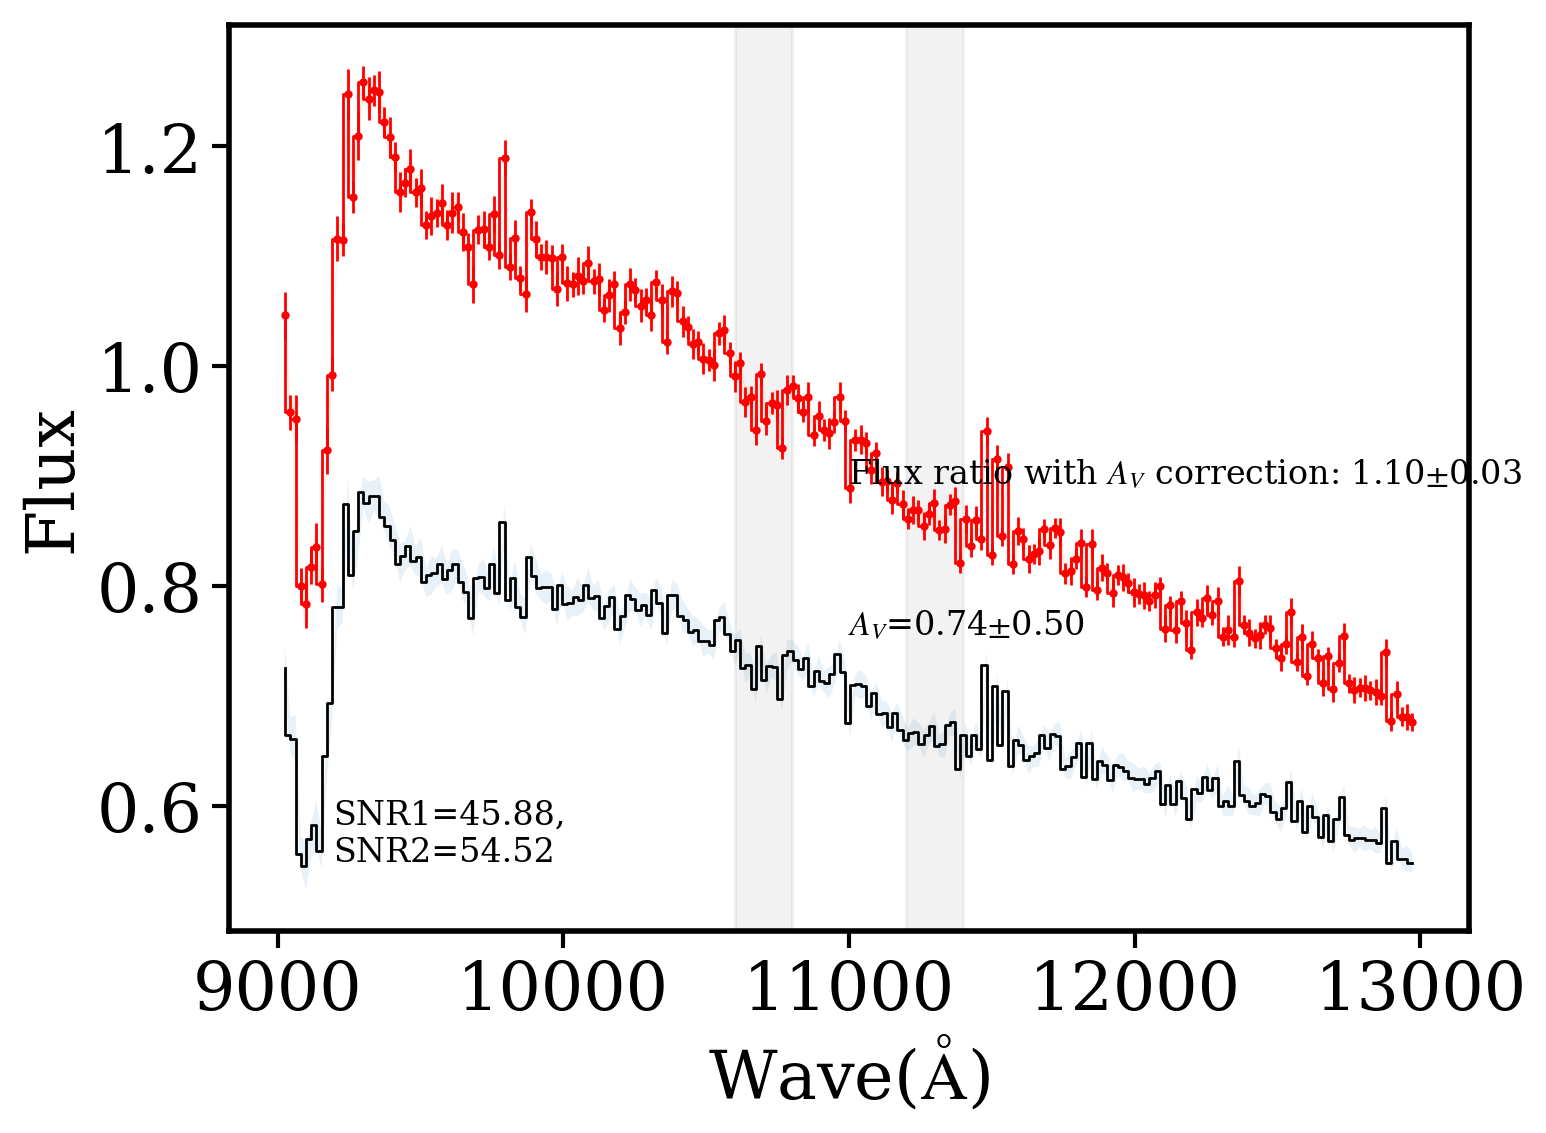

In [382]:
Flux_ratio_AV_corr_20200409(CN_list)

In [297]:
print(len(CN_list))
CN_selected = CN_list[CN_list.SNR1>20]
print(len(CN_selected))
CN_selected = CN_selected[CN_selected.SNR2>20]
print(len(CN_selected))
CN_list = CN_list.reset_index(drop=True)
CN_selected
# CN_selected.to_csv('/Volumes/My Passport/TPAGB/database/CN_selected_20200410_69.csv')

99
75
69


,ID,region,field,M05_age_opt,M05_AV_opt,M13_age_opt,M13_AV_opt,BC_age_opt,BC_AV_opt,x2_spectra_M05_opt,...,SNR_F125W,SNR_F606W,F160W_mag,F140W_mag,F125W_mag,F606W_mag,flux_ratio_AV_corr,flux_ratio_err_AV_corr,SNR1,SNR2
0,26380,1,aegis,2.830425,0.426375052,1.129631,0.741285,1.190967,0.628743,14.877404,...,1428.978743,565.863207,19.553553,19.657425,19.790917,21.313506,1.124823,0.031706,45.879164,54.520241
1,14044,2,aegis,2.762686,0.4527159014,1.099094,0.798332,1.644505,0.688362,7.961912,...,2415.494987,621.653638,18.576935,18.716260,18.895395,20.732689,1.144278,0.018301,79.081787,97.749539
2,17857,3,aegis,1.522889,0.1981563755,0.996109,0.535120,1.356051,0.618279,8.113330,...,951.633433,459.206347,20.029466,20.145525,20.245753,21.589858,1.062554,0.039782,34.808733,38.598070
3,19820,3,aegis,2.853989,0.6830266296,1.172320,1.003099,1.356051,1.067616,13.006652,...,2748.083712,754.970423,18.448836,18.613642,18.826151,20.811442,1.132967,0.022392,94.032864,115.485318
4,26829,3,aegis,1.245305,0.1324448958,0.983187,0.548503,1.208593,0.388111,3.710209,...,453.675305,171.569015,20.878146,20.995919,21.133803,22.716962,1.145476,0.070558,26.240877,22.634044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,30019,19,uds,2.351813,0.6516546747,1.111471,1.011952,3.250048,0.428124,8.141266,...,1658.144269,697.051058,18.375726,18.523247,18.741075,20.736808,1.137107,0.017092,50.435951,98.736419
92,31083,19,uds,2.264750,0.09666945748,1.007444,0.492631,1.227488,0.348146,4.762820,...,1251.784648,755.477359,19.027166,19.139246,19.300489,20.885722,1.097364,0.022560,30.316137,73.587313
95,32850,23,uds,1.229832,0.1469294901,0.950003,0.541911,1.800003,0.303916,2.945023,...,462.245180,246.634203,20.463419,20.554981,20.727587,22.429676,1.118061,0.066308,32.163358,23.954998
96,39073,23,uds,0.964962,0.1377857069,0.160493,1.786610,1.010428,0.935939,4.912801,...,476.468248,404.381708,20.551898,20.647181,20.772158,22.093412,1.214113,0.067741,23.680934,24.591818


In [384]:
def Flux_ratio_AV_corr_20200410(CN_list):
#     CN_list['flux_ratio_AV_corr'] = -1
    CN_list['flux_ratio_err_AV_corr'] = -1
    CN_list['fig_name'] = -1
#     CN_list['SNR1']=1
#     CN_list['SNR2']=1
    for i in range(len(CN_list)):
        
        ## 0 preparation step load the basic information of the source:
        """
        field, region, ID, z
        Age, AV
        """
        field = CN_list.iloc[i].field
        region = int(CN_list.iloc[i].region)
        ID = int(CN_list.iloc[i].ID)
        z = CN_list.iloc[i].z_best
        print(i,field,region,ID,z)
        if field == 'aegis':
            filename = "/Volumes/My Passport/AEGIS_WFC3_V4.1.5/aegis-" + "{0:02d}".format(
                region) + "/1D/ASCII/aegis-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            AV_opt=aegis_opt[aegis_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=aegis_opt[aegis_opt.ID==ID].AV_opt_std.values[0]
            age_opt=aegis_opt[aegis_opt.ID==ID].age_opt.values[0]
            age_opt_std=aegis_opt[aegis_opt.ID==ID].age_opt_std.values[0]
            model=aegis_opt[aegis_opt.ID==ID].model.values[0]
        elif field == 'cosmos':
            filename = "/Volumes/My Passport/COSMOS_WFC3_V4.1.5/cosmos-" + "{0:02d}".format(
                region) + "/1D/ASCII/cosmos-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            AV_opt =cosmos_opt[cosmos_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=cosmos_opt[cosmos_opt.ID==ID].AV_opt_std.values[0]
            age_opt =cosmos_opt[cosmos_opt.ID==ID].age_opt.values[0]
            age_opt_std=cosmos_opt[cosmos_opt.ID==ID].age_opt_std.values[0]
            model=cosmos_opt[cosmos_opt.ID==ID].model.values[0]
        elif field == 'goodsn':
            filename = "/Volumes/My Passport/GOODSN_WFC3_V4.1.5/goodsn-" + "{0:02d}".format(
                region) + "/1D/ASCII/goodsn-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            AV_opt=goodsn_opt[goodsn_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=goodsn_opt[goodsn_opt.ID==ID].AV_opt_std.values[0]
            age_opt=goodsn_opt[goodsn_opt.ID==ID].age_opt.values[0]
            age_opt_std=goodsn_opt[goodsn_opt.ID==ID].age_opt_std.values[0]
            model=goodsn_opt[goodsn_opt.ID==ID].model.values[0]
        elif field == 'goodss':
            filename = "/Volumes/My Passport/GOODSS_WFC3_V4.1.5/goodss-" + "{0:02d}".format(
                region) + "/1D/ASCII/goodss-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            AV_opt=goodss_opt[goodss_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=goodss_opt[goodss_opt.ID==ID].AV_opt_std.values[0]
            age_opt=goodss_opt[goodss_opt.ID==ID].age_opt.values[0]
            age_opt_std=goodss_opt[goodss_opt.ID==ID].age_opt_std.values[0]
            model=goodss_opt[goodss_opt.ID==ID].model.values[0]
        elif field == 'uds':
            filename = "/Volumes/My Passport/UDS_WFC3_V4.1.5/uds-" + "{0:02d}".format(
                region) + "/1D/ASCII/uds-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            AV_opt=uds_opt[uds_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=uds_opt[uds_opt.ID==ID].AV_opt_std.values[0] 
            age_opt=uds_opt[uds_opt.ID==ID].age_opt.values[0]
            age_opt_std=uds_opt[uds_opt.ID==ID].age_opt_std.values[0]
            model=uds_opt[uds_opt.ID==ID].model.values[0]

        AV_opt = float(AV_opt)
        AV_opt_std = float(AV_opt_std)
        age_opt = float(age_opt)
        age_opt_std = float(age_opt_std)

        ## 1. Read the datafile 
        data = np.loadtxt(filename, skiprows=1)
        restwave = data[:, 0] / (1 + z)
        flux = (data[:, 1] - data[:, 3]) / data[:, 6]
        flux_err = data[:, 2] / data[:, 6]
        
        ### 1.1 Sensitivity mask on the grism spectra
        start_index = np.argmin(abs(restwave*(1+z)-11407.53))
        end_index = np.argmin(abs(restwave*(1+z)-16428.61))
        restwave = restwave[start_index:end_index]
        flux = flux[start_index:end_index]
        flux_err = flux_err[start_index:end_index]
        flux_ratio = Lick_index_ratio(restwave, flux)
        
        ### 1.2 Plot the redshift corrected wavelength
        plt.figure(figsize=(8,6),dpi=200)
        plt.step(restwave,flux,color='k')
        plt.fill_between(restwave,(flux+flux_err),(flux-flux_err),alpha=0.1)

        ## 2. Calculate the SNR
        norm = np.nanmean(flux[np.where((restwave>10900)&(restwave<11100))])
        normerr = np.std(flux[np.where((restwave>10900)&(restwave<11100))])
        SNR1 = norm/normerr # show the fluctuation within band region
        SNR2 = np.median(flux/flux_err) # show the error over flux in the band within the band region
#         CN_list.loc[i, 'SNR1'] = SNR1
#         CN_list.loc[i, 'SNR2'] = SNR2
#         print('SNR',"{:.2f}".format(SNR1),"{:.2f}".format(SNR2))
        
        ## 3. Calculate the AV corrected flux ratio and do error estimate.
        ### 3.1 Masking out the blue/band/red regions
        blue_min = 1.06e4  
        blue_max = 1.08e4  
        red_min = 1.12e4  
        red_max = 1.14e4  
        band_min = blue_max
        band_max = red_min
        # Blue
        blue_mask = (restwave >= blue_min) & (restwave <= blue_max)
        blue_wave = restwave[blue_mask]
        blue_flux = flux[blue_mask]
        blue_flux_err = flux_err[blue_mask]
        # Red
        red_mask = (restwave >= red_min) & (restwave <= red_max)
        red_wave = restwave[red_mask]
        red_flux = flux[red_mask]
        red_flux_err = flux_err[red_mask]
        # Band
        band_mask = (restwave >= band_min) & (restwave <= band_max)
        band_wave = restwave[band_mask]
        band_flux = flux[band_mask]
        band_flux_err = flux_err[band_mask]
        
        ### 3.2 Calculate the flux ratio
        blue_flux_mean = np.sum(blue_flux / blue_flux_err ** 2) / np.sum(1 / blue_flux_err ** 2)
        red_flux_mean = np.sum(red_flux / red_flux_err ** 2) / np.sum(1 / red_flux_err ** 2)
        
        blue_flux_mean_err = np.sqrt(1 / np.sum(1 / blue_flux_err ** 2))
        red_flux_mean_err = np.sqrt(1 / np.sum(1 / red_flux_err ** 2))
        
        blue_index = find_nearest(flux, blue_flux_mean)
        red_index = find_nearest(flux, red_flux_mean)
#         print('Flux ratio without AV correction:',\
#               np.mean(blue_flux) / np.mean(red_flux),\
#               CN_list.iloc[i].grism_index,\
#               Lick_index_ratio(restwave,flux),\
#              blue_flux_mean/red_flux_mean)
        
        ### 3.3 AV correction
        spectra_extinction = calzetti00(restwave, AV_opt, 4.05)
        spectra_extinction_up = calzetti00(restwave, AV_opt + AV_opt_std, 4.05)
        spectra_extinction_down = calzetti00(restwave, AV_opt - AV_opt_std, 4.05)
        
        spectra_flux_correction = 10 ** (-0.4 * spectra_extinction)
        spectra_flux_correction_up = 10 ** (-0.4 * spectra_extinction_up)
        spectra_flux_correction_down = 10 ** (-0.4 * spectra_extinction_down)
        
        ### 3.4 Apply the extinction correction to the datapoints
        flux_corr = flux / spectra_flux_correction
        flux_up = flux/spectra_flux_correction_up
        flux_down = flux/spectra_flux_correction_down
        # Calculat the flux ratio
        flux_ratio_AV_corr = Lick_index_ratio(restwave, flux_corr)
        attenuation_corr = flux_ratio_AV_corr/flux_ratio
        attenuation_corr_err = (Lick_index_ratio(restwave,flux_up)-Lick_index_ratio(restwave,flux_down))/2./flux_ratio
        
        ### 3.5 Make the plot of the AV corrected flux
        color_set = ['indigo','k','g','orange']
        plt.step(restwave,flux_corr,color=color_set[CN_list.iloc[i].model_new])
        plt.fill_between(restwave,(flux_corr+flux_err),(flux_corr-flux_err),alpha=0.1)

        ### 3.6 Calculate error of flux ratio
        # Blue
        blue_flux_corr = flux_corr[blue_mask]
        # Red
        red_flux_corr = flux_corr[red_mask]
        # Band
        band_flux_corr = flux_corr[band_mask]
        
        ratio_err = np.sqrt(( 1/np.mean(red_flux) * attenuation_corr * np.mean(blue_flux_err)) ** 2 + \
                            (np.mean(blue_flux)/np.mean(red_flux) ** 2 *attenuation_corr * np.mean(red_flux_err)) ** 2+\
                            (flux_ratio * attenuation_corr_err)**2)
#         CN_list.loc[i, 'flux_ratio_AV_corr'] = flux_ratio_AV_corr
        CN_list.loc[i, 'flux_ratio_err_AV_corr'] = ratio_err
        
        ### 4 Plot
        plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
        plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
        plt.text(np.median(restwave),np.median(flux)*1.1,\
                 r'$A_V$='+"{0:.2f}".format(AV_opt)+r'$\pm$'+"{0:.2f}".format(AV_opt_std),fontsize=12)
        plt.text(np.median(restwave),np.median(flux)*1.3,\
                 r'Flux ratio with $A_V$ correction: '+"{0:.2f}".format(flux_ratio)\
                 +r'$\pm$'+"{0:.2f}".format(ratio_err),fontsize=12)
        plt.text(np.median(restwave)-1800,np.median(flux)*0.8,'SNR1='+"{0:.2f}".format(SNR1)\
                 +',\n'+'SNR2='+"{0:.2f}".format(SNR2),fontsize=12)
        
        figname = current_dir + outcome_dir + plot_dir+'CN/20200410/CN_20200410_'+str(field)+\
                '_'+str(region)+'_'+str(ID)+'.pdf'
        figname='./database/CN/'+'CN_20200410_'+str(field)+\
                '_'+str(region)+'_'+str(ID)+'.pdf'
        plt.xlabel(r'Wave($\rm\AA$)')
        plt.ylabel('Flux')
#         plt.savefig(figname)
        CN_list.loc[i,'fig_name'] = figname


        plt.clf()
    return CN_list

In [385]:
CN_list_new = pd.read_csv('/Volumes/My Passport/TPAGB/database/CN_selected_20200410_69.csv')#('/Volumes/My Passport/TPAGB/database/CN_selected_20200409_new_model_62.csv')
# print(CN_list_new.ID.values[2])
CN_list_new = CN_list_new.drop([2])#17857	3	aegis
CN_list_new = CN_list_new.drop(columns='Unnamed: 0')
CN_list_new = CN_list_new.reset_index(drop=True)
# print(CN_list_new)
print(np.min(CN_list_new.flux_ratio_AV_corr),np.max(CN_list_new.flux_ratio_AV_corr))
## Drop the top one and the bottom one
# print(CN_list_new.ID.values[66])
# CN_list_new = CN_list_new.drop([66])#39073	23	uds
# CN_list_new = CN_list_new.reset_index(drop=True)
# # print(CN_list_new)
# print(CN_list_new.ID.values[50])
# CN_list_new = CN_list_new.drop([50])#28082	26	goodsn
# CN_list_new = CN_list_new.reset_index(drop=True)
# # print(CN_list_new.ID.values[35],CN_list_new.region.values[35])
# CN_list_new = CN_list_new.drop([35])#12390	20	cosmos
# CN_list_new = CN_list_new.reset_index(drop=True)
# print(np.min(CN_list_new.flux_ratio_AV_corr),np.max(CN_list_new.flux_ratio_AV_corr))
# print(CN_list_new.iloc[34])


## Modify the error estimate
CN_list_new = CN_list_new.drop(columns='flux_ratio_err_AV_corr')
CN_list_new = Flux_ratio_AV_corr_20200410(CN_list_new)
print(len(CN_list_new))

1.03539950537218 1.21294553585147
0 aegis 1 26380 0.264
1 aegis 2 14044 0.436
2 aegis 3 19820 0.4197
3 aegis 3 26829 0.3996
4 aegis 11 37275 0.304
5 aegis 14 21300 0.2161
6 aegis 15 10415 0.2479
7 aegis 16 19787 0.4361
8 aegis 19 30005 0.2776
9 aegis 28 11221 0.4337
10 aegis 28 16063 0.2445
11 aegis 30 14044 0.436
12 cosmos 1 19842 0.2311
13 cosmos 1 20236 0.2254
14 cosmos 1 20423 0.354
15 cosmos 1 21548 0.2196
16 cosmos 1 21739 0.4492
17 cosmos 1 21966 0.2225
18 cosmos 1 22611 0.2272
19 cosmos 3 13683 0.2093
20 cosmos 3 14860 0.3764
21 cosmos 3 16320 0.2204
22 cosmos 7 24252 0.2201
23 cosmos 7 25114 0.2074
24 cosmos 7 25888 0.2371
25 cosmos 10 14034 0.3743
26 cosmos 10 16377 0.2235
27 cosmos 10 17321 0.2184
28 cosmos 10 17943 0.2207
29 cosmos 11 25830 0.3861
30 cosmos 11 26531 0.3344
31 cosmos 15 25830 0.3861
32 cosmos 17 17321 0.2184
33 cosmos 17 18089 0.3799
34 cosmos 20 12390 0.228
35 cosmos 23 12390 0.228
36 cosmos 24 10494 0.3662
37 cosmos 24 11218 0.3607
38 cosmos 24 11319 0.369

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

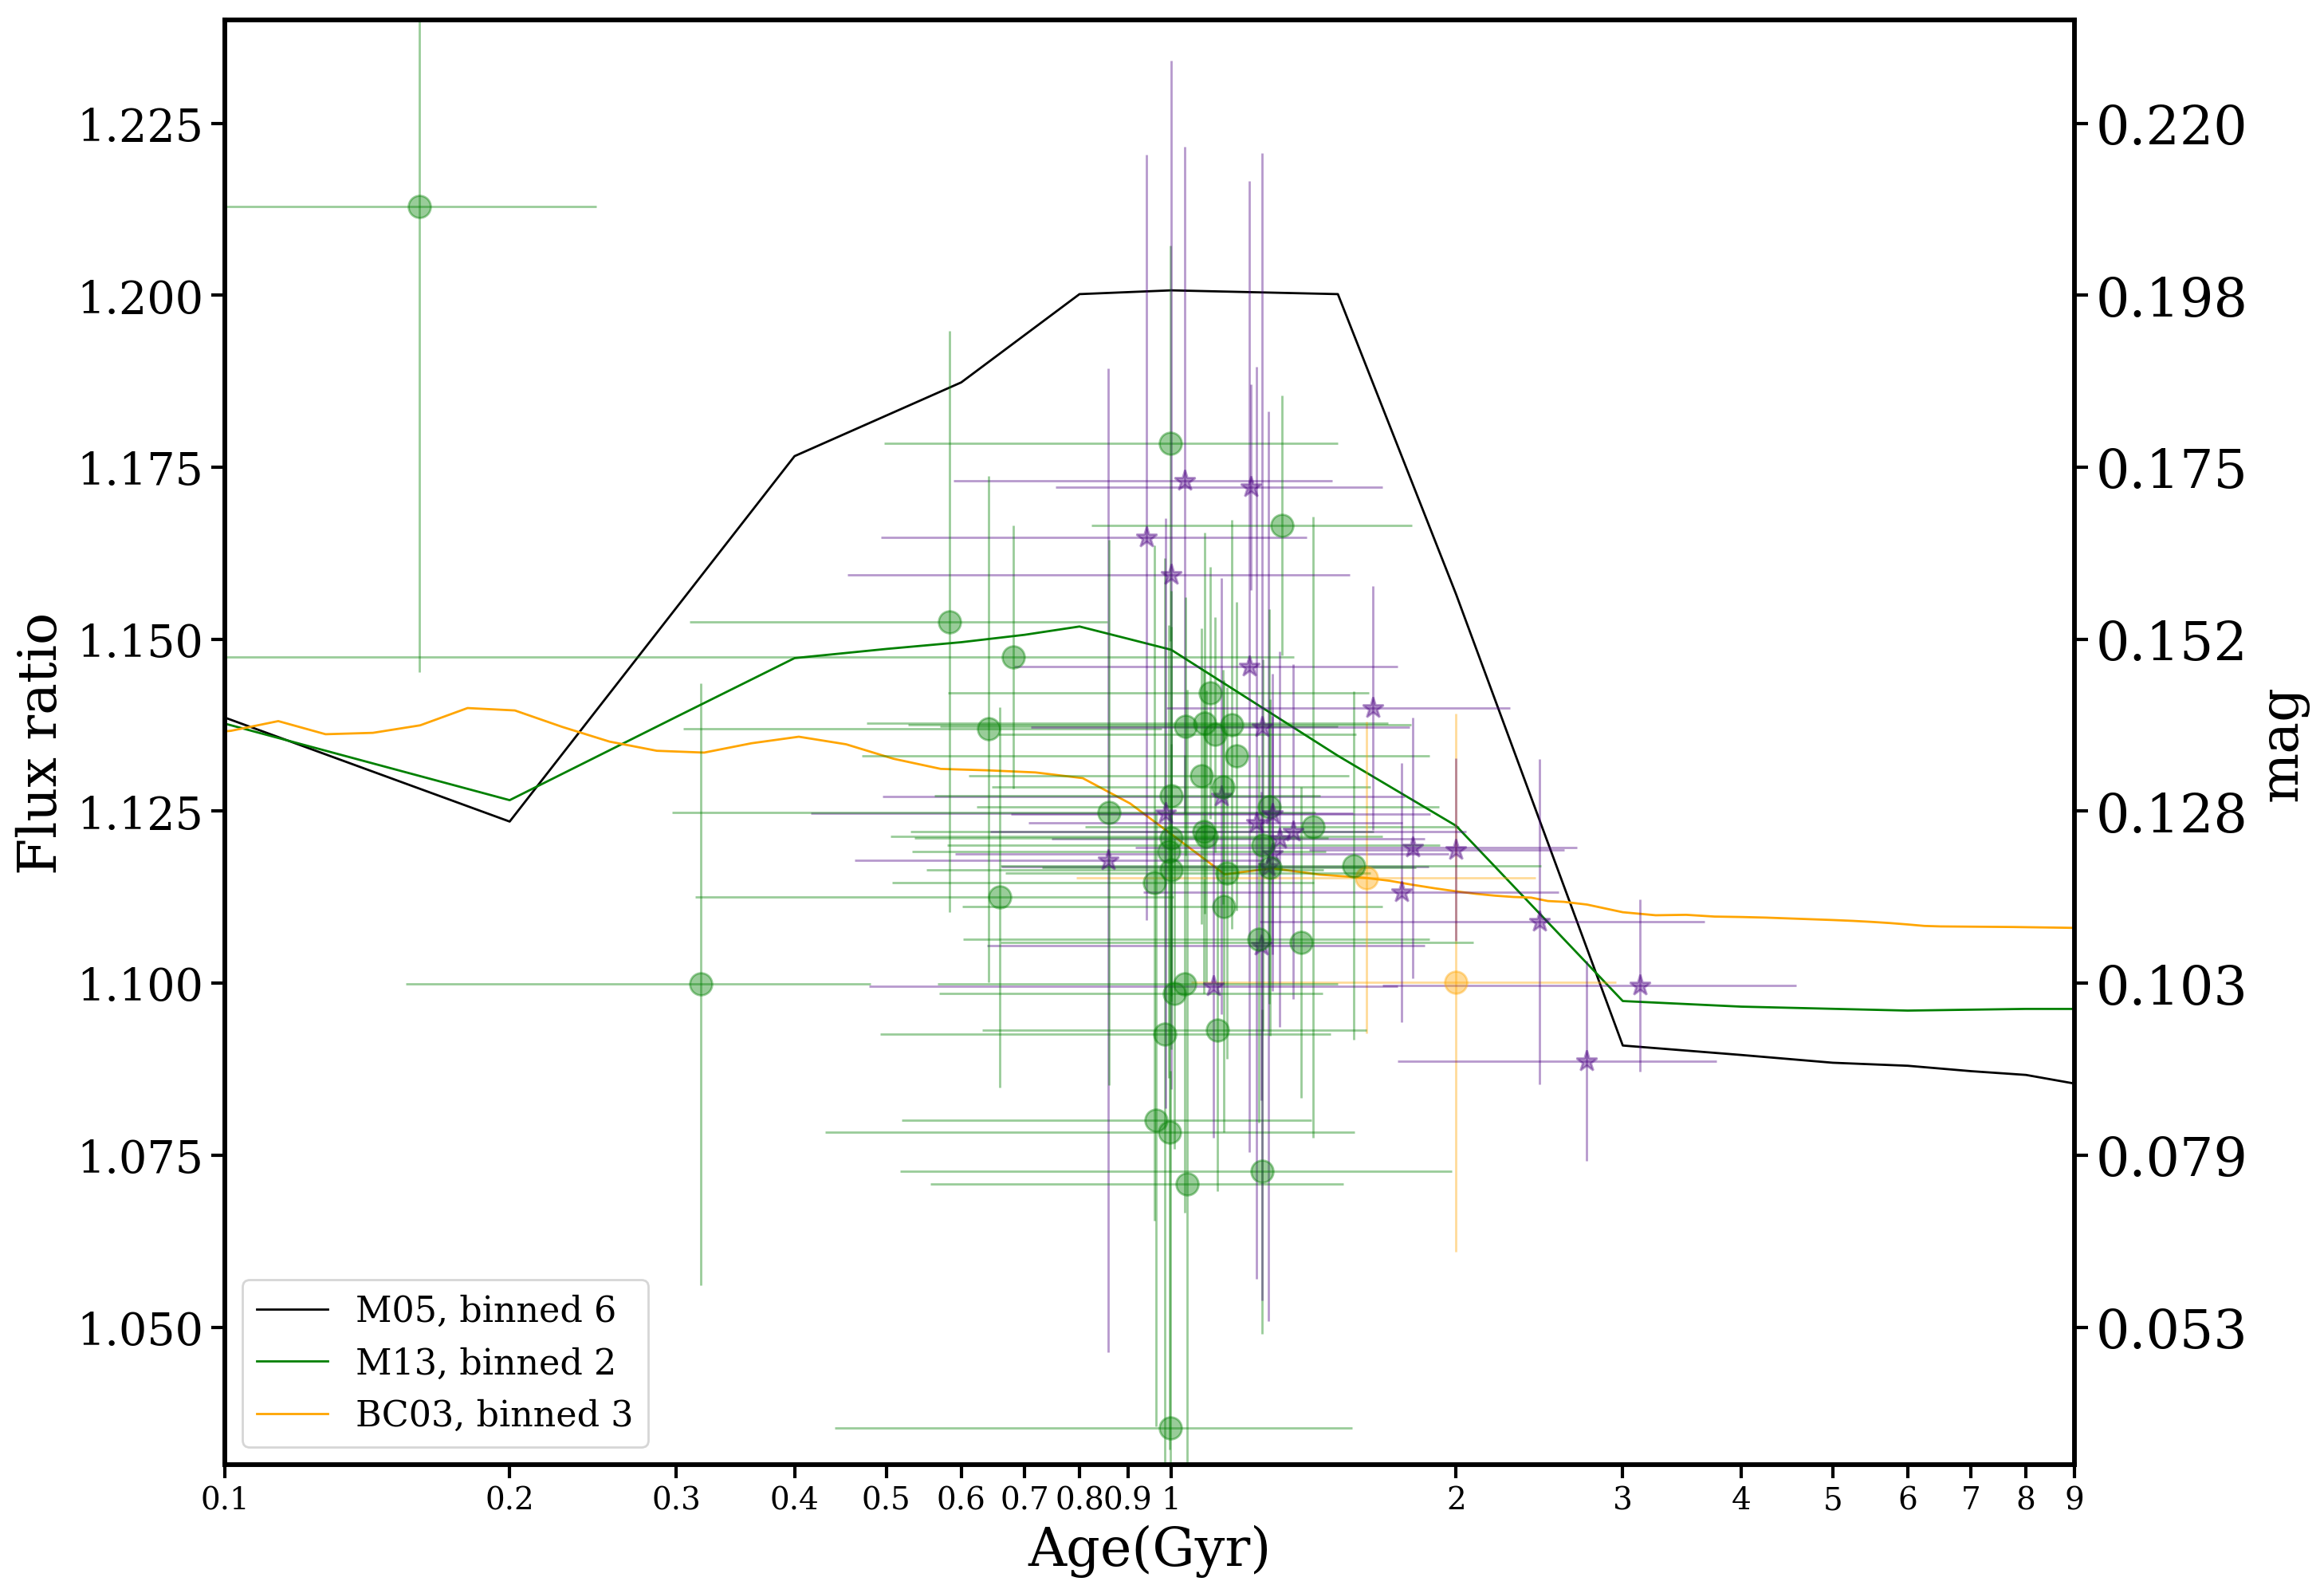

In [325]:
### CN_age plot based on new_model: scatter points
date='20200410'
fig=plt.figure(figsize=(16,12),dpi=200)
plt.rc('lines', linewidth=1, markersize=2)
plt.rc('font', size=24, family='serif', weight=300)
plt.rc('mathtext', fontset='stix')
plt.rc('axes', linewidth=2)
plt.rc('xtick.major', width=1.5, size=6)
plt.rc('ytick.major', width=1.5, size=6)
plt.tick_params(axis='both', which='major', labelsize=20)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
CN_69 = CN_list_new

colorset=['indigo','k','g','orange']
fmtset = ['*','o','o','o']

for i in range(len(CN_69)):
#     print(i)
    c = CN_69.model_new.values.astype(int)[i]
    ax1.errorbar(CN_69.iloc[i].age_opt,\
             CN_69.iloc[i].flux_ratio_AV_corr,\
             xerr=CN_69.iloc[i].age_opt_std,\
             yerr=CN_69.iloc[i].flux_ratio_err_AV_corr,\
             color=colorset[c],\
             markersize=10,\
             alpha=0.4,\
             zorder=10,\
             fmt=fmtset[c])

# unattenuated
ax1.plot(df_Ma.Age.unique(),Lick_index_list_M05_SSP_smoothed_6,color='k',\
         label='M05, binned 6')
ax1.plot(df_M13.Age.unique(),Lick_index_list_M13_SSP_smoothed_2,color='green',\
         label='M13, binned 2')
ax1.plot(BC03_age_list.astype(np.float)/1e9,Lick_index_list_BC03_SSP_smoothed_3,color='orange',\
         label='BC03, binned 3')



ax1Ys = ax1.get_yticks()
ax2Ys = []
for Y in ax1Ys:
    tick = "{0:.3f}".format(2.5*np.log10(Y))
    ax2Ys.append(tick)

ax2.set_yticks(ax1Ys)
ax2.set_ybound(ax1.get_ybound())
ax2.set_yticklabels(ax2Ys)

ax1.legend(prop={'size':14}, loc='lower left')

ax1.legend(prop={'size':16}, loc='lower left')
tick_labels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,\
             3,4,5,6,7,8,9]



fig.subplots_adjust(right=0.85)
ax1.set_xlim(0.1,9)
ax1.set_ylim([1.03, 1.24])


ax1.semilogx()
ax1.set_xticks(tick_labels)
ax1.set_xticklabels(tick_labels,fontsize=14)
ax1.set_xlabel('Age(Gyr)')
ax1.set_ylabel('Flux ratio')
ax2.set_ylabel('mag')


fn_fig = current_dir+outcome_dir+plot_dir+'flux_ratio_age_mag_binned_smoothed_4_cross-matches_smoothed_'+date+'new_model_new_err_no_removal.png'
fig.savefig(fn_fig)


In [326]:
M05 = CN_list_new[CN_list_new.model_new==1]
M13 = CN_list_new[CN_list_new.model_new==2]
BC03 = CN_list_new[CN_list_new.model_new==3]
TPAGB_heavy = pd.concat([M05,M13])
print(len(M05),len(M13),len(BC03),\
      len(TPAGB_heavy))

def bin_flux_ratio(group_data,bins=10):
    # the input group_data should be in the form of a dataframe
    data_cut,ret_bins = pd.qcut(group_data.age_opt.rank(method='first'),bins,retbins=True,duplicates='drop')
    print(ret_bins)
    print(pd.qcut(group_data.age_opt.rank(method='first'),bins).value_counts())
    grp = group_data.groupby(by=data_cut) 
    ret = grp.aggregate(np.mean)  
    ret_std = grp.aggregate(np.std)
    return ret, ret_std
# M05_ret, M05_std = bin_flux_ratio(M05,2)
M13_ret, M13_std = bin_flux_ratio(M13,4)
BC03_ret, BC03_std = bin_flux_ratio(BC03,2)
# tot_ret, tot_std = bin_flux_ratio(CN_selected,6)
TPAGB_heavy_ret, TPAGB_heavy_std = bin_flux_ratio(TPAGB_heavy,4)
print(M13_ret.age_opt)

0 42 2 42
[ 1.   11.25 21.5  31.75 42.  ]
(31.75, 42.0]     11
(0.999, 11.25]    11
(21.5, 31.75]     10
(11.25, 21.5]     10
Name: age_opt, dtype: int64
[1.  1.5 2. ]
(1.5, 2.0]      1
(0.999, 1.5]    1
Name: age_opt, dtype: int64
[ 1.   11.25 21.5  31.75 42.  ]
(31.75, 42.0]     11
(0.999, 11.25]    11
(21.5, 31.75]     10
(11.25, 21.5]     10
Name: age_opt, dtype: int64
age_opt
(0.999, 11.25]    0.709395
(11.25, 21.5]     1.010589
(21.5, 31.75]     1.107914
(31.75, 42.0]     1.296619
Name: age_opt, dtype: float64


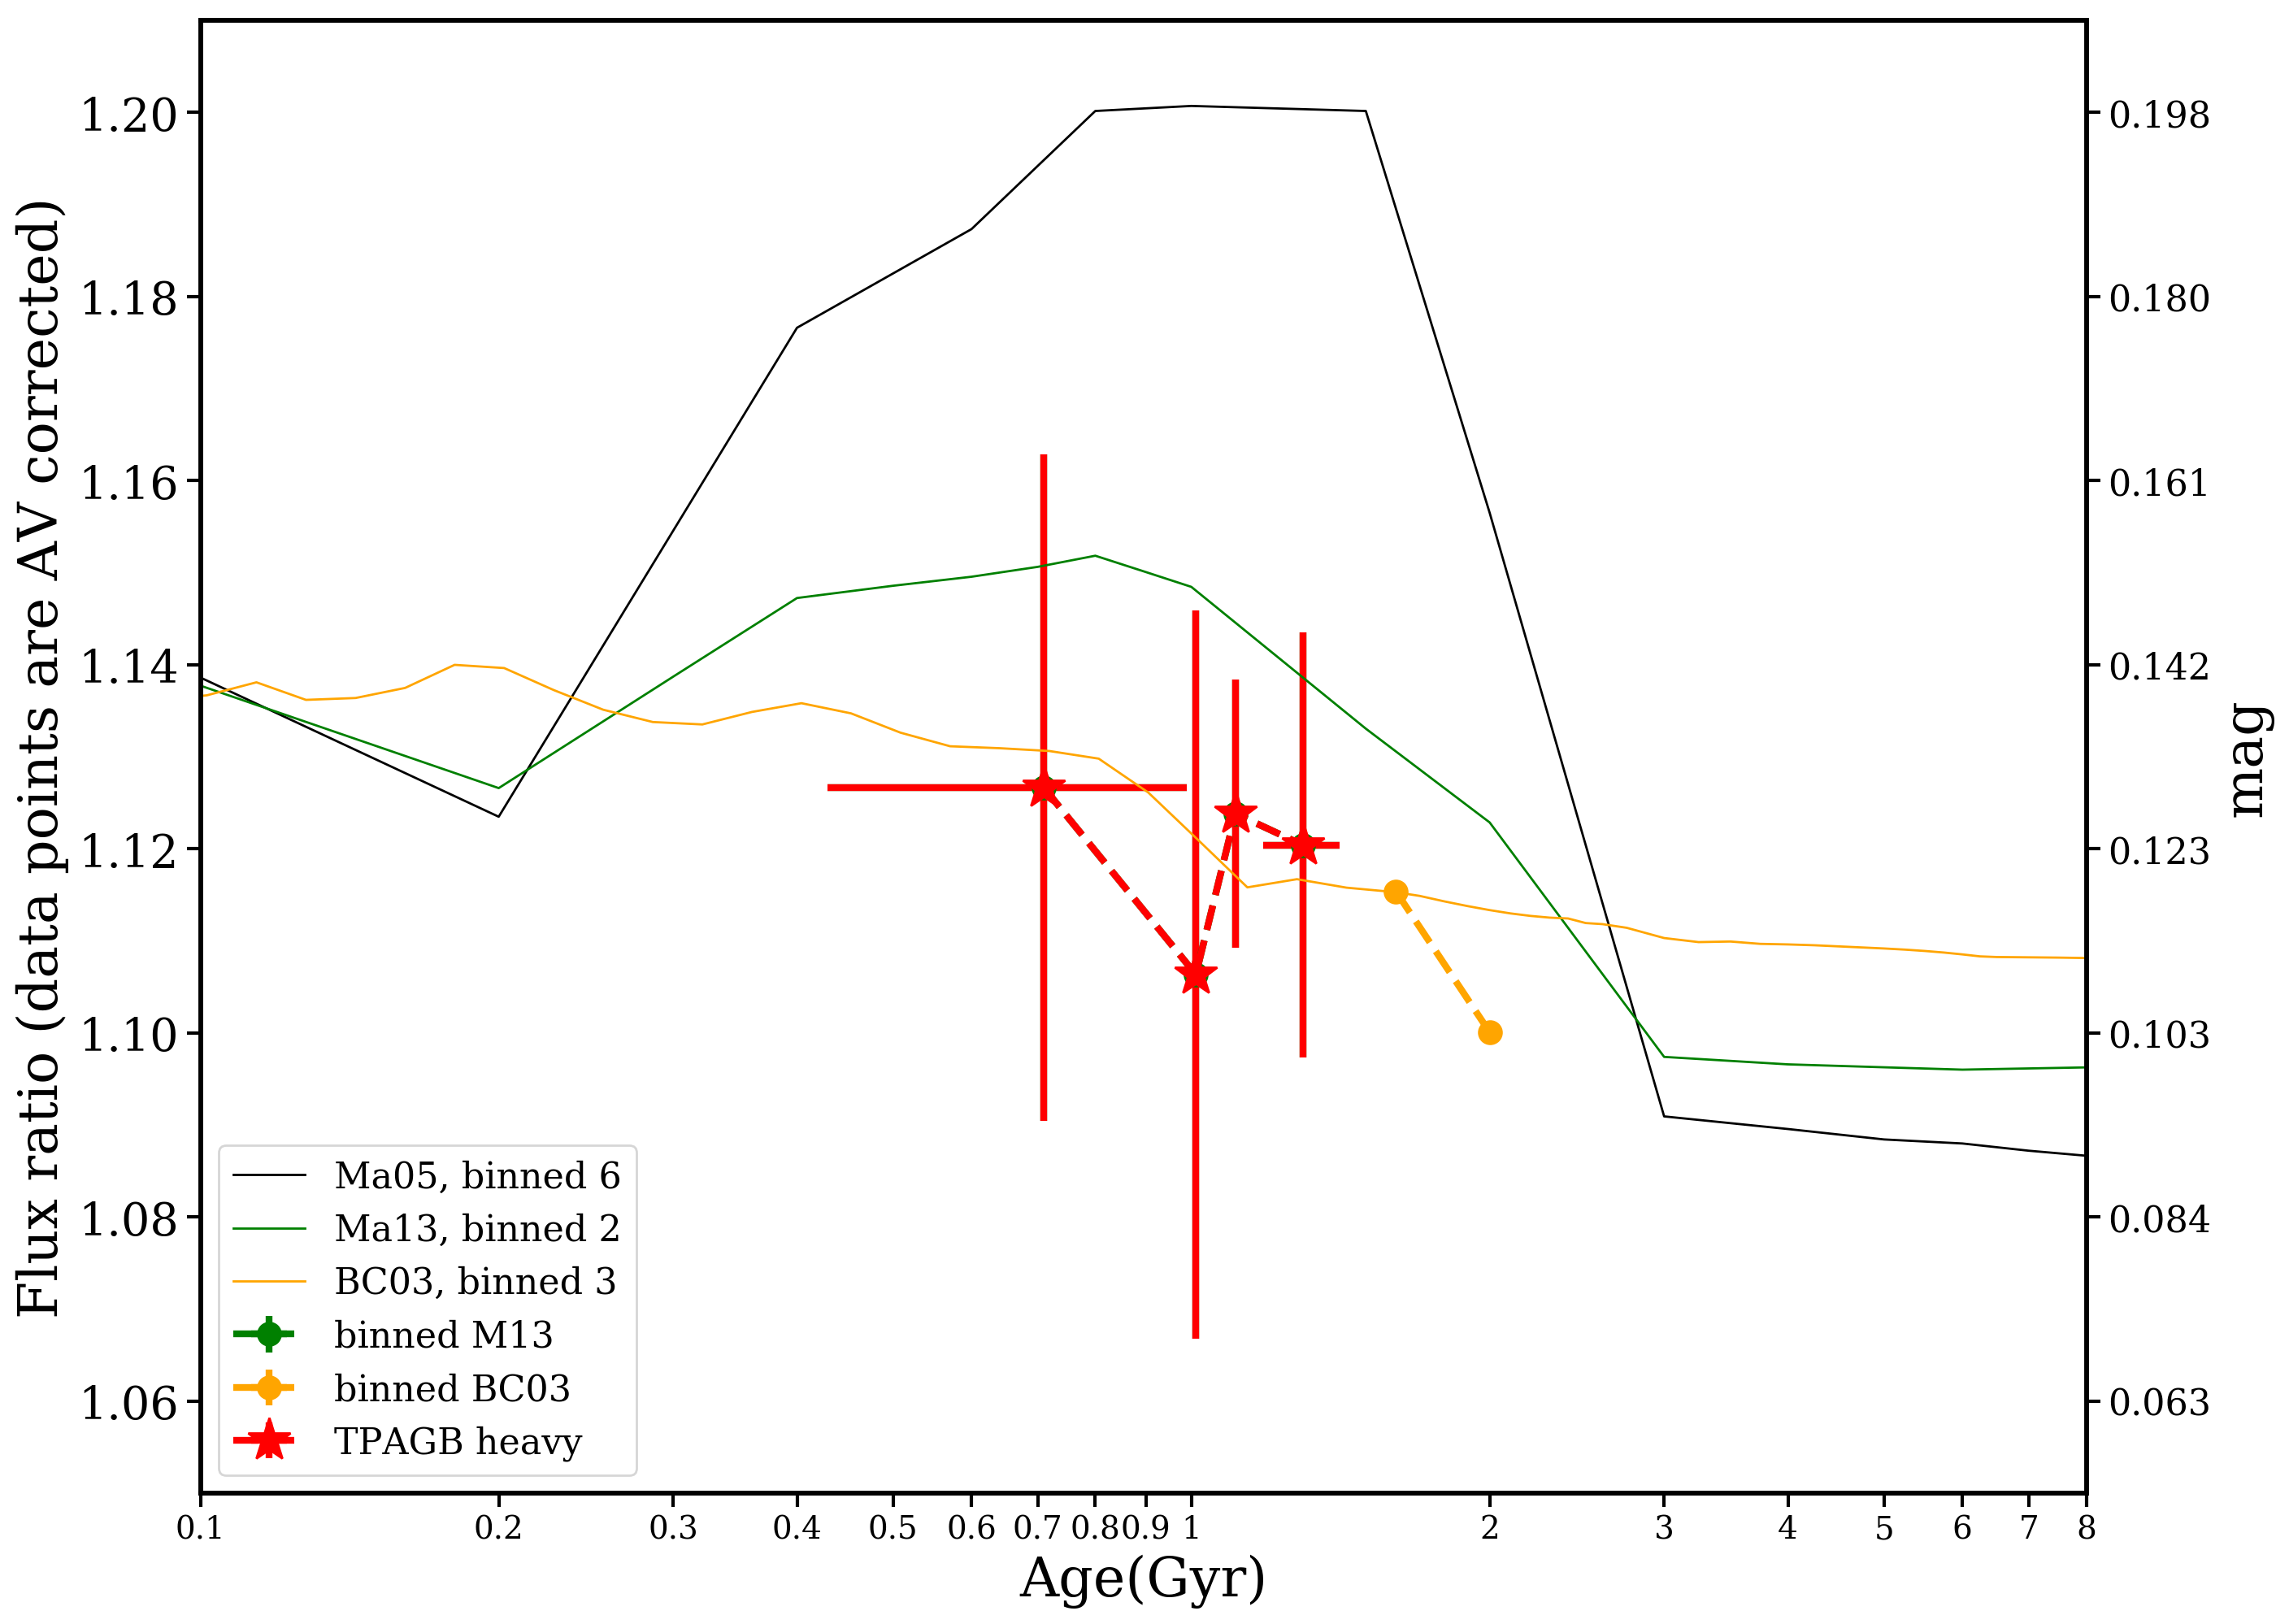

In [327]:
### based on model_new
fig=plt.figure(figsize=(16,12),dpi=200)
plt.rc('lines', linewidth=1, markersize=2)
plt.rc('font', size=24, family='serif', weight=300)
plt.rc('mathtext', fontset='stix')
plt.rc('axes', linewidth=2)
plt.rc('xtick.major', width=1.5, size=6)
plt.rc('ytick.major', width=1.5, size=6)
plt.tick_params(axis='both', which='major', labelsize=20)

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
# CN_69=CN_69

colorset=['indigo','k','g','orange']

# attenuated
ax1.plot(df_Ma.Age.unique(), Lick_index_list_Ma05_smoothed_6, label='Ma05, binned 6', color='k')

ax1.plot(df_M13.Age.unique()[1:], Lick_index_list_Ma13_smoothed_2[1:], label='Ma13, binned 2', color='green')

ax1.plot(BC03_age_list_num, Lick_index_list_BC03_smoothed_3, label='BC03, binned 3', color='orange')

# ax1.errorbar(M05_ret.age_opt.values, M05_ret.flux_ratio_AV_corr.values, 
#              xerr=M05_std.age_opt.values,\
#              yerr=M05_std.flux_ratio_AV_corr.values,\
#          color='k',label='binned M05',lw=3,fmt='--o',markersize=10);
ax1.errorbar(M13_ret.age_opt.values, M13_ret.flux_ratio_AV_corr.values, \
             xerr=M13_std.age_opt.values,\
             yerr=M13_std.flux_ratio_AV_corr.values,\
         color='green',label='binned M13',lw=3,fmt='--o',markersize=10);
ax1.errorbar(BC03_ret.age_opt.values, BC03_ret.flux_ratio_AV_corr.values,\
             xerr=BC03_std.age_opt.values,\
             yerr=BC03_std.flux_ratio_AV_corr.values, color='orange',\
         label='binned BC03',lw=3,fmt='--o',markersize=10);
# ax1.plot(tot_ret.age_opt.dropna(),tot_ret.flux_ratio_AV_corr.dropna(),\
#          label='tot',marker='o',color='indigo',lw=3,markersize=10);
ax1.errorbar(TPAGB_heavy_ret.age_opt.values, TPAGB_heavy_ret.flux_ratio_AV_corr.values,\
             xerr=TPAGB_heavy_std.age_opt.values,\
             yerr=TPAGB_heavy_std.flux_ratio_AV_corr.values,\
         label='TPAGB heavy',fmt='--*',color='red',lw=3,markersize=20);
ax1.set_ylim([1.05, 1.21])
ax1Ys = ax1.get_yticks()
ax2Ys = []
for Y in ax1Ys:
    tick = "{0:.3f}".format(2.5*np.log10(Y))
    ax2Ys.append(tick)

ax2.set_yticks(ax1Ys)
ax2.set_ybound(ax1.get_ybound())
ax2.set_yticklabels(ax2Ys)
ax2.yaxis.set_tick_params(labelsize=16)
ax1.legend(prop={'size':16}, loc='lower left')
tick_labels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,\
             3,4,5,6,7,8]

fig.subplots_adjust(right=0.85)
ax1.set_xlim(0.1,8)
ax1.semilogx()
ax1.set_xticks(tick_labels)
ax1.set_xticklabels(tick_labels,fontsize=14)
ax1.set_xlabel('Age(Gyr)')
ax1.set_ylabel('Flux ratio (data points are AV corrected)')
ax2.set_ylabel('mag')
# ax1.axvline(0.1)
# ax1.axvline(3)

fn_fig = current_dir+outcome_dir+plot_dir+\
         'flux_ratio_age_68_attenuated_datapoints_AV_corr_binned'+date+'model_new_new_error_no_removal.png'
fig.savefig(fn_fig)

In [329]:
import sys
!{sys.executable} -m pip install bokeh

In [346]:
from bokeh.plotting import Figure,figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, CrosshairTool, CustomJS
from bokeh.layouts import column, row, gridplot
from bokeh.models.widgets import Button, RadioButtonGroup, Select, Slider
from bokeh.models import BasicTicker, ColorBar, ColumnDataSource, LinearColorMapper, PrintfTickFormatter
from bokeh.io import output_notebook, show

output_file("CN-age.html")


In [365]:
colorset = ['indigo','k','green','orange']
print(CN_list_new.model_new.values.astype(int))
print([colorset[i] for i in CN_list_new.model_new.values.astype(int)])

[0 2 2 0 3 0 2 2 0 0 2 2 0 0 2 0 2 2 2 2 2 3 0 0 2 2 2 0 0 2 2 0 2 2 0 2 2
 2 2 0 2 2 2 2 0 2 0 2 2 2 2 0 0 2 0 0 2 2 2 0 0 2 2 2 2 0 2 2]
['indigo', 'green', 'green', 'indigo', 'orange', 'indigo', 'green', 'green', 'indigo', 'indigo', 'green', 'green', 'indigo', 'indigo', 'green', 'indigo', 'green', 'green', 'green', 'green', 'green', 'orange', 'indigo', 'indigo', 'green', 'green', 'green', 'indigo', 'indigo', 'green', 'green', 'indigo', 'green', 'green', 'indigo', 'green', 'green', 'green', 'green', 'indigo', 'green', 'green', 'green', 'green', 'indigo', 'green', 'indigo', 'green', 'green', 'green', 'green', 'indigo', 'indigo', 'green', 'indigo', 'indigo', 'green', 'green', 'green', 'indigo', 'indigo', 'green', 'green', 'green', 'green', 'indigo', 'green', 'green']


In [387]:
sfh_imgs=CN_list_new.fig_name.values
# sfh_imgs.replace('/Volumes/My Passport/TPAGB/outcome/plot/CN/20200410/','./database/CN/')
sfh_imgs

# np.char.replace(sfh_imgs,'/Volumes/My Passport/TPAGB/outcome/plot/CN/20200410/','./database/CN/')

array(['./database/CN/CN_20200410_aegis_1_26380.pdf',
       './database/CN/CN_20200410_aegis_2_14044.pdf',
       './database/CN/CN_20200410_aegis_3_19820.pdf',
       './database/CN/CN_20200410_aegis_3_26829.pdf',
       './database/CN/CN_20200410_aegis_11_37275.pdf',
       './database/CN/CN_20200410_aegis_14_21300.pdf',
       './database/CN/CN_20200410_aegis_15_10415.pdf',
       './database/CN/CN_20200410_aegis_16_19787.pdf',
       './database/CN/CN_20200410_aegis_19_30005.pdf',
       './database/CN/CN_20200410_aegis_28_11221.pdf',
       './database/CN/CN_20200410_aegis_28_16063.pdf',
       './database/CN/CN_20200410_aegis_30_14044.pdf',
       './database/CN/CN_20200410_cosmos_1_19842.pdf',
       './database/CN/CN_20200410_cosmos_1_20236.pdf',
       './database/CN/CN_20200410_cosmos_1_20423.pdf',
       './database/CN/CN_20200410_cosmos_1_21548.pdf',
       './database/CN/CN_20200410_cosmos_1_21739.pdf',
       './database/CN/CN_20200410_cosmos_1_21966.pdf',
       './data

In [375]:

# envcat is a dataframe that contains ID, redshift, RA, DEC, and Density_Contrast
# sfh_imgs is a list that contains all the filenames for the images I want to hover over
sfh_imgs=CN_list_new.fig_name.values
# print(sfh_imgs)
color_list =[colorset[i] for i in CN_list_new.model_new.values.astype(int)]
source = ColumnDataSource(data=dict(
    x=CN_list_new.age_opt,
    y=CN_list_new.flux_ratio_AV_corr,
    desc=CN_list_new.ID,
    model = color_list,
#     goods_ids = envcat['ID'].astype(int),
    imgs= sfh_imgs,
#     env_vals = colors,
    env_od = CN_list_new.field,
    env_region = CN_list_new.region,
#     masses = gal_mass,
))

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

TOOLTIPS = """
    <div>
        <div>
            <img
                src="@imgs" height="300" alt="@imgs" width="400"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="0"
            ></img>
        </div>
        <div>
            <span style="font-size: 15px; color: #966;">Field: @env_od,region: @env_region, Galaxy Id: @desc, </span>
        </div>
        <div>
            <span style="font-size: 15px; color: #696;"></span>
        </div>
    </div>
"""

p = figure(plot_width=700, plot_height=700, tooltips=TOOLTIPS,
           x_axis_type="log",x_range=(0.1,5),y_range=(1.03, 1.24),
           title="CN-age plot", tools = TOOLS)
p.xaxis.axis_label = 'Age(Gyr)'
p.yaxis.axis_label = r'Flux Ratio'


# unattenuated
p.line(df_Ma.Age.unique(),Lick_index_list_M05_SSP_smoothed_6)
         
p.line(df_M13.Age.unique(),Lick_index_list_M13_SSP_smoothed_2)
        
p.line(BC03_age_list.astype(np.float)/1e9,Lick_index_list_BC03_SSP_smoothed_3)
    


p.circle('x', 'y',  source=source, color='model',
         fill_alpha=0.3, hover_alpha=1.0)

p.toolbar.autohide = True

output_notebook()
show(p)

Loading BokehJS ...

In [131]:
M05 = CN_selected[CN_selected.model==1]
M13 = CN_selected[CN_selected.model==2]
BC03 = CN_selected[CN_selected.model==3]
TPAGB_heavy = pd.concat([M05,M13])
print(len(M05),len(M13),len(BC03),\
      len(TPAGB_heavy))

def bin_flux_ratio(group_data,bins=10):
    # the input group_data should be in the form of a dataframe
    data_cut,ret_bins = pd.qcut(group_data.age_opt.rank(method='first'),bins,retbins=True,duplicates='drop')
#     print(ret_bins)
    print(pd.qcut(group_data.age_opt.rank(method='first'),bins).value_counts())
    grp = group_data.groupby(by=data_cut) 
    ret = grp.aggregate(np.mean)  
    ret_std = grp.aggregate(np.std)
    return ret, ret_std
M05_ret, M05_std = bin_flux_ratio(M05,2)
M13_ret, M13_std = bin_flux_ratio(M13,5)
BC03_ret, BC03_std = bin_flux_ratio(BC03,3)
tot_ret, tot_std = bin_flux_ratio(CN_selected,6)
TPAGB_heavy_ret, TPAGB_heavy_std = bin_flux_ratio(TPAGB_heavy,5)



2 50 10 52
(1.5, 2.0]      1
(0.999, 1.5]    1
Name: age_opt, dtype: int64
(40.2, 50.0]     10
(30.4, 40.2]     10
(20.6, 30.4]     10
(10.8, 20.6]     10
(0.999, 10.8]    10
Name: age_opt, dtype: int64
(0.999, 4.0]    4
(7.0, 10.0]     3
(4.0, 7.0]      3
Name: age_opt, dtype: int64
(51.833, 62.0]      11
(0.999, 11.167]     11
(41.667, 51.833]    10
(31.5, 41.667]      10
(21.333, 31.5]      10
(11.167, 21.333]    10
Name: age_opt, dtype: int64
(41.8, 52.0]     11
(0.999, 11.2]    11
(31.6, 41.8]     10
(21.4, 31.6]     10
(11.2, 21.4]     10
Name: age_opt, dtype: int64


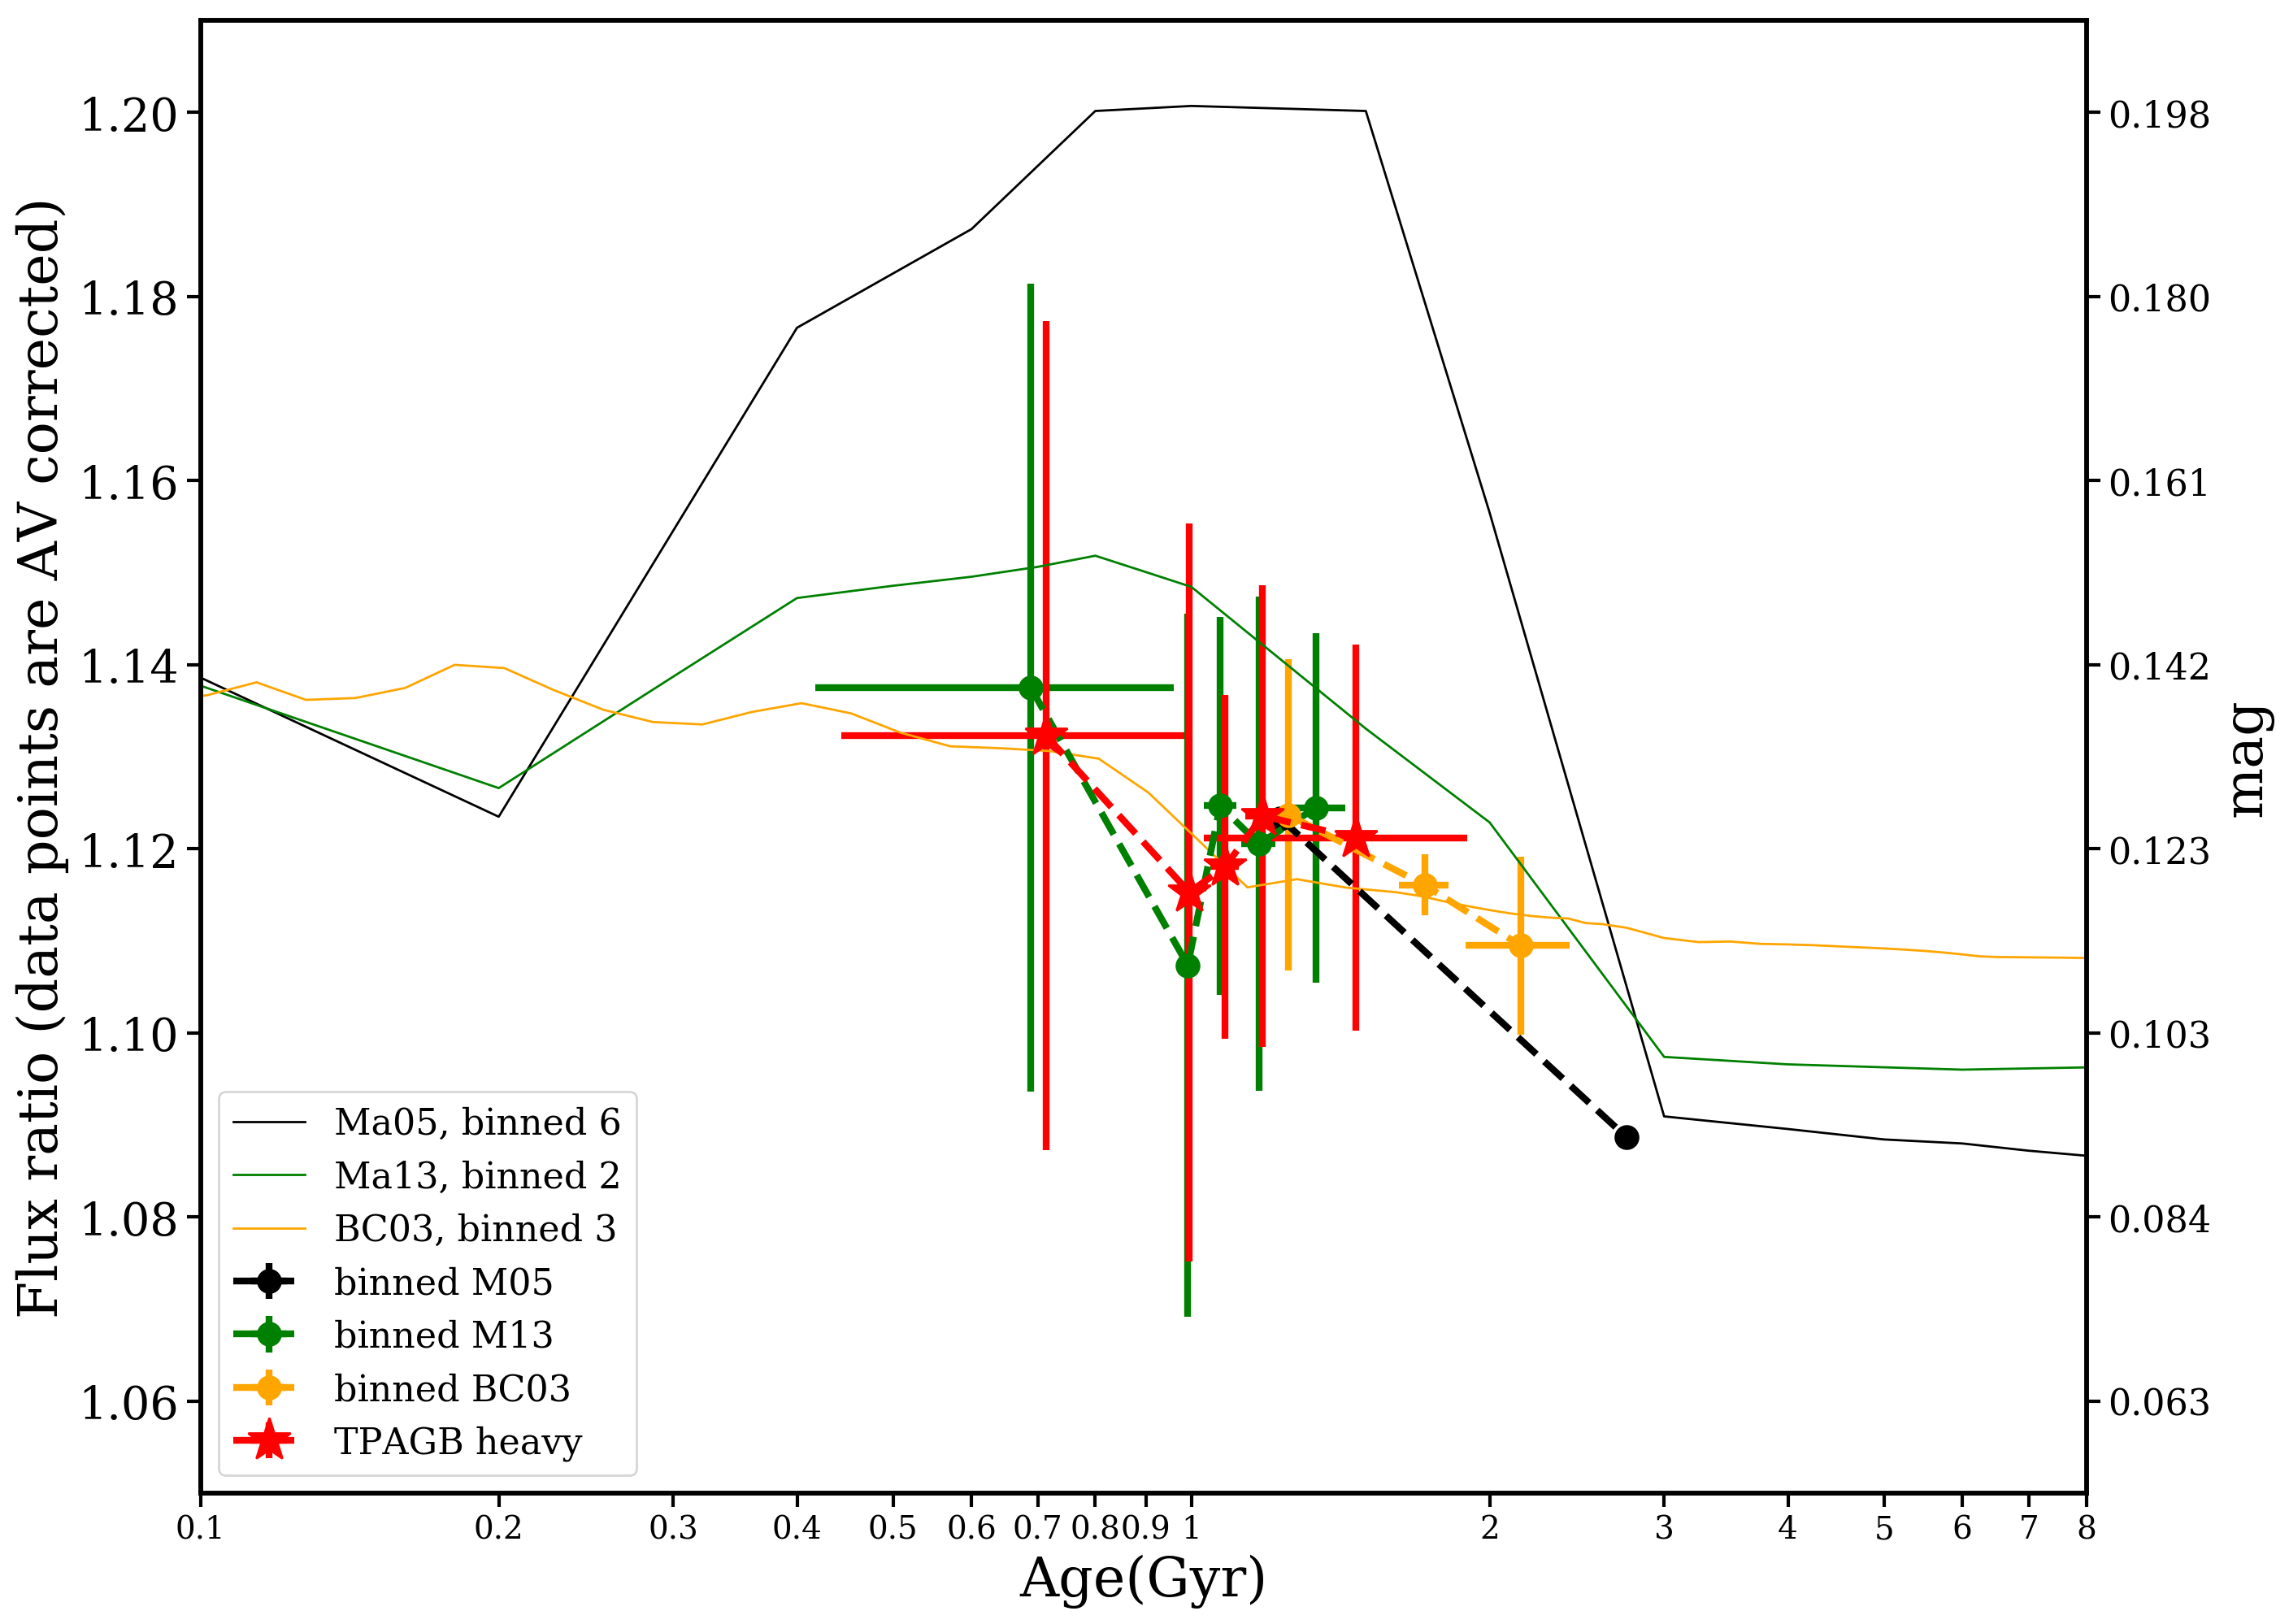

In [132]:
### 8 make subplots
fig=plt.figure(figsize=(16,12),dpi=200)
plt.rc('lines', linewidth=1, markersize=2)
plt.rc('font', size=24, family='serif', weight=300)
plt.rc('mathtext', fontset='stix')
plt.rc('axes', linewidth=2)
plt.rc('xtick.major', width=1.5, size=6)
plt.rc('ytick.major', width=1.5, size=6)
plt.tick_params(axis='both', which='major', labelsize=20)

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
# CN_69=CN_69

colorset=['indigo','k','g','orange']

# attenuated
ax1.plot(df_Ma.Age.unique(), Lick_index_list_Ma05_smoothed_6, label='Ma05, binned 6', color='k')

ax1.plot(df_M13.Age.unique()[1:], Lick_index_list_Ma13_smoothed_2[1:], label='Ma13, binned 2', color='green')

ax1.plot(BC03_age_list_num, Lick_index_list_BC03_smoothed_3, label='BC03, binned 3', color='orange')

ax1.errorbar(M05_ret.age_opt.values, M05_ret.flux_ratio_AV_corr.values, 
             xerr=M05_std.age_opt.values,\
             yerr=M05_std.flux_ratio_AV_corr.values,\
         color='k',label='binned M05',lw=3,fmt='--o',markersize=10);
ax1.errorbar(M13_ret.age_opt.values, M13_ret.flux_ratio_AV_corr.values, \
             xerr=M13_std.age_opt.values,\
             yerr=M13_std.flux_ratio_AV_corr.values,\
         color='green',label='binned M13',lw=3,fmt='--o',markersize=10);
ax1.errorbar(BC03_ret.age_opt.values, BC03_ret.flux_ratio_AV_corr.values,\
             xerr=BC03_std.age_opt.values,\
             yerr=BC03_std.flux_ratio_AV_corr.values, color='orange',\
         label='binned BC03',lw=3,fmt='--o',markersize=10);
# ax1.plot(tot_ret.age_opt.dropna(),tot_ret.flux_ratio_AV_corr.dropna(),\
#          label='tot',marker='o',color='indigo',lw=3,markersize=10);
ax1.errorbar(TPAGB_heavy_ret.age_opt.values, TPAGB_heavy_ret.flux_ratio_AV_corr.values,\
             xerr=TPAGB_heavy_std.age_opt.values,\
             yerr=TPAGB_heavy_std.flux_ratio_AV_corr.values,\
         label='TPAGB heavy',fmt='--*',color='red',lw=3,markersize=20);


ax1.set_ylim([1.05, 1.21])



ax1Ys = ax1.get_yticks()

ax2Ys = []
for Y in ax1Ys:
    tick = "{0:.3f}".format(2.5*np.log10(Y))
    ax2Ys.append(tick)

ax2.set_yticks(ax1Ys)
ax2.set_ybound(ax1.get_ybound())
ax2.set_yticklabels(ax2Ys)

ax2.yaxis.set_tick_params(labelsize=16)

ax1.legend(prop={'size':16}, loc='lower left')
tick_labels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,\
             3,4,5,6,7,8]

fig.subplots_adjust(right=0.85)
ax1.set_xlim(0.1,8)
ax1.semilogx()
ax1.set_xticks(tick_labels)
ax1.set_xticklabels(tick_labels,fontsize=14)
ax1.set_xlabel('Age(Gyr)')
ax1.set_ylabel('Flux ratio (data points are AV corrected)')
ax2.set_ylabel('mag')
# ax1.axvline(0.1)
# ax1.axvline(3)

fn_fig = current_dir+outcome_dir+plot_dir+\
         'flux_ratio_age_62_attenuated_datapoints_AV_corr_binned'+date+'.pdf'
# fig.savefig(fn_fig)

In [123]:

Lick_index_list_Ma05 = np.zeros(len(df_Ma.Age.unique()))
Lick_index_list_Ma05_69_AV0533 = np.zeros(len(df_Ma.Age.unique()))
Lick_index_list_Ma05_13_AV0237 = np.zeros(len(df_Ma.Age.unique()))

Lick_index_list_Ma05_smoothed_6 = np.zeros(len(df_Ma.Age.unique()))
Lick_index_list_Ma05_69_AV0533_smoothed_6 = np.zeros(len(df_Ma.Age.unique()))
Lick_index_list_Ma05_13_AV0237_smoothed_6 = np.zeros(len(df_Ma.Age.unique()))


Lick_index_list_Ma13 = np.zeros(len(df_M13.Age.unique()))
Lick_index_list_Ma13_69_AV0533 = np.zeros(len(df_M13.Age.unique()))
Lick_index_list_Ma13_13_AV0237 = np.zeros(len(df_M13.Age.unique()))

Lick_index_list_Ma13_smoothed_2 = np.zeros(len(df_M13.Age.unique()))
Lick_index_list_Ma13_69_AV0533_smoothed_2 = np.zeros(len(df_M13.Age.unique()))
Lick_index_list_Ma13_13_AV0237_smoothed_2 = np.zeros(len(df_M13.Age.unique()))

Lick_index_list_BC03 = np.zeros(len(BC03_age_list))
Lick_index_list_BC03_69_AV0533 = np.zeros(len(BC03_age_list))
Lick_index_list_BC03_13_AV0237 = np.zeros(len(BC03_age_list))

Lick_index_list_BC03_smoothed_3 = np.zeros(len(BC03_age_list))
Lick_index_list_BC03_69_AV0533_smoothed_3 = np.zeros(len(BC03_age_list))
Lick_index_list_BC03_13_AV0237_smoothed_3 = np.zeros(len(BC03_age_list))

for i in range(len(df_Ma.Age.unique())):
    age_index = i
    age_prior = df_Ma.Age.unique()[age_index]
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1:
        fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
        model1 = np.genfromtxt(fn1)
    elif age_prior == 1.5:
        fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
        model1 = np.genfromtxt(fn1)
    elif len(split_galaxy_age_string[1])==1:
        fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
        model1 = np.genfromtxt(fn1)

    M05_flux_center = model1[1,:]#*spectra_flux_correction
    F_M05_index=167
    Flux_M05_norm_new = M05_flux_center[F_M05_index]
    smooth_Flux_Ma_1Gyr_new = M05_flux_center/Flux_M05_norm_new
    Lick_index_list_Ma05[age_index]=Lick_index_ratio(model1[0,:], smooth_Flux_Ma_1Gyr_new)
    kernel=6
    g = Gaussian1DKernel(stddev=kernel)
    smooth_Flux_Ma_1Gyr_smoothed  = convolve(smooth_Flux_Ma_1Gyr_new, g)
    Lick_index_list_Ma05_smoothed_6[age_index]=Lick_index_ratio(model1[0,:], smooth_Flux_Ma_1Gyr_smoothed)

    spectra_extinction = calzetti00(model1[0,:], 0.533, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    smooth_Flux_Ma_1Gyr_69_AV0533 = smooth_Flux_Ma_1Gyr_new*spectra_flux_correction
    Lick_index_list_Ma05_69_AV0533[age_index]=Lick_index_ratio(model1[0,:], smooth_Flux_Ma_1Gyr_69_AV0533)
    smooth_Flux_Ma_1Gyr_smoothed  = convolve(smooth_Flux_Ma_1Gyr_69_AV0533, g)
    Lick_index_list_Ma05_69_AV0533_smoothed_6[age_index]=Lick_index_ratio(model1[0,:], smooth_Flux_Ma_1Gyr_smoothed)
    spectra_extinction = calzetti00(model1[0,:], 0.237, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    smooth_Flux_Ma_1Gyr_13_AV0237 = smooth_Flux_Ma_1Gyr_new*spectra_flux_correction
    Lick_index_list_Ma05_13_AV0237[age_index]=Lick_index_ratio(model1[0,:], smooth_Flux_Ma_1Gyr_13_AV0237)
    smooth_Flux_Ma_1Gyr_smoothed  = convolve(smooth_Flux_Ma_1Gyr_13_AV0237, g)
    Lick_index_list_Ma05_13_AV0237_smoothed_6[age_index]=Lick_index_ratio(model1[0,:], smooth_Flux_Ma_1Gyr_smoothed)

for i in range(1, len(df_M13.Age.unique())):
    age_index = i
    age_prior = df_M13.Age.unique()[age_index]
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1:
        fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
        model2 = np.genfromtxt(fn1)
    elif age_prior == 1.5:
        fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
        model2 = np.genfromtxt(fn1)
    elif len(split_galaxy_age_string[1])==1:
        fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
        model2 = np.genfromtxt(fn1)

    M13_flux_center = model2[1,:]#*spectra_flux_correction
    F_M13_index = 126##np.where(abs(model2[0,:]-norm_wavelength)<10.5)[0][0]
    Flux_M13_norm_new = M13_flux_center[F_M13_index]
    smooth_Flux_M13_1Gyr_new = M13_flux_center/Flux_M13_norm_new
    Lick_index_list_Ma13[age_index]=Lick_index_ratio(model2[0,:], smooth_Flux_M13_1Gyr_new)
    kernel = 2
    g = Gaussian1DKernel(stddev=kernel)
    smooth_Flux_M13_1Gyr_new  = convolve(smooth_Flux_M13_1Gyr_new, g)
    Lick_index_list_Ma13_smoothed_2[age_index]=Lick_index_ratio(model2[0,:], smooth_Flux_M13_1Gyr_new)
 
    spectra_extinction = calzetti00(model2[0,:], 0.533, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    smooth_Flux_M13_1Gyr_69_AV0533 = smooth_Flux_M13_1Gyr_new*spectra_flux_correction
    Lick_index_list_Ma13_69_AV0533[age_index]=Lick_index_ratio(model2[0,:], smooth_Flux_M13_1Gyr_69_AV0533)
    smooth_Flux_M13_1Gyr_new  = convolve(smooth_Flux_M13_1Gyr_69_AV0533, g)
    Lick_index_list_Ma13_69_AV0533_smoothed_2[age_index]=Lick_index_ratio(model2[0,:], smooth_Flux_M13_1Gyr_new)
    
    spectra_extinction = calzetti00(model2[0,:], 0.237, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    smooth_Flux_M13_1Gyr_13_AV0237 = smooth_Flux_M13_1Gyr_new*spectra_flux_correction
    Lick_index_list_Ma13_13_AV0237[age_index]=Lick_index_ratio(model2[0,:], smooth_Flux_M13_1Gyr_13_AV0237)
    smooth_Flux_M13_1Gyr_new  = convolve(smooth_Flux_M13_1Gyr_13_AV0237, g)
    Lick_index_list_Ma13_13_AV0237_smoothed_2[age_index]=Lick_index_ratio(model2[0,:], smooth_Flux_M13_1Gyr_new)

for i in range(len(BC03_age_list_num)):
    age_index = i
    age_prior = BC03_age_list_num[age_index]
 
    model3_flux = BC03_flux_array[age_index, :7125]

    BC03_flux_attenuated = model3_flux#*spectra_flux_correction
    BC03_flux_norm = BC03_flux_attenuated[2556]
    BC03_flux_attenuated = BC03_flux_attenuated/BC03_flux_norm
    Lick_index_list_BC03[age_index]=Lick_index_ratio(BC03_wave_list_num, BC03_flux_attenuated)
    kernel = 3
    g = Gaussian1DKernel(stddev=kernel)
    BC03_flux_attenuated = convolve(BC03_flux_attenuated,g)
    Lick_index_list_BC03_smoothed_3[age_index]=Lick_index_ratio(BC03_wave_list_num, BC03_flux_attenuated)
    
    spectra_extinction = calzetti00(BC03_wave_list_num, 0.237, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    BC03_flux_attenuated_13_AV0237 = BC03_flux_attenuated*spectra_flux_correction
    Lick_index_list_BC03_13_AV0237[i]=Lick_index_ratio(BC03_wave_list_num, BC03_flux_attenuated_13_AV0237)
    BC03_flux_attenuated = convolve(BC03_flux_attenuated_13_AV0237,g)
    Lick_index_list_BC03_13_AV0237_smoothed_3[age_index]=Lick_index_ratio(BC03_wave_list_num, BC03_flux_attenuated)
 
    spectra_extinction = calzetti00(BC03_wave_list_num, 0.533, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    BC03_flux_attenuated_69_AV0533 = BC03_flux_attenuated*spectra_flux_correction
    Lick_index_list_BC03_69_AV0533[i]=Lick_index_ratio(BC03_wave_list_num, BC03_flux_attenuated_69_AV0533)
    BC03_flux_attenuated = convolve(BC03_flux_attenuated_69_AV0533,g)
    Lick_index_list_BC03_69_AV0533_smoothed_3[age_index]=Lick_index_ratio(BC03_wave_list_num, BC03_flux_attenuated)


In [82]:
print(np.nonzero(Lick_index_list_M05_SSP-Lick_index_list_Ma05))
print(np.nonzero(Lick_index_list_M13_SSP-Lick_index_list_Ma13))
print(np.nonzero(Lick_index_list_BC03_SSP-Lick_index_list_BC03))

print(np.nonzero(Lick_index_list_M05_SSP_smoothed_6-Lick_index_list_Ma05_smoothed_6))

(array([], dtype=int64),)
(array([0]),)
(array([], dtype=int64),)
(array([], dtype=int64),)


In [90]:
# source_list_20191124.to_csv('/Volumes/My Passport/TPAGB/outcome/numeric/CN_63_20200221_AV_corrected.csv')
source_list_20191124.loc[:,['ID','region','field','z_best']].to_csv('/Volumes/My Passport/TPAGB/outcome/numeric/CN_58_'+date+'_AV_corrected_namelist.csv')
# plt.hist(source_list_20191124.age_opt)
# plt.semilogx()

In [84]:
#bin the datapoints

# M05 = source_list_20191124[source_list_20191124.model_new==1]
# M13 = source_list_20191124[source_list_20191124.model_new==2]
# TPAGB_heavy = pd.concat([M05,M13])
M05 = source_list_20191124[source_list_20191124.model==1]
M13 = source_list_20191124[source_list_20191124.model==2]
BC03 = source_list_20191124[source_list_20191124.model==3]
TPAGB_heavy = pd.concat([M05,M13])
print(len(M05),len(M13),len(BC03),\
      len(TPAGB_heavy))

def bin_flux_ratio(group_data,bins=10):
    # the input group_data should be in the form of a dataframe
    data_cut,ret_bins = pd.qcut(group_data.age_opt.rank(method='first'),bins,retbins=True,duplicates='drop')
#     print(ret_bins)
    print(pd.qcut(group_data.age_opt.rank(method='first'),bins).value_counts())
    grp = group_data.groupby(by=data_cut) 
    ret = grp.aggregate(np.mean)  
    ret_std = grp.aggregate(np.std)
    return ret, ret_std
M05_ret, M05_std = bin_flux_ratio(M05,3)
M13_ret, M13_std = bin_flux_ratio(M13,3)
BC03_ret, BC03_std = bin_flux_ratio(BC03,3)
tot_ret, tot_std = bin_flux_ratio(source_list_20191124,7)
TPAGB_heavy_ret, TPAGB_heavy_std = bin_flux_ratio(TPAGB_heavy,5)


7 27 24 34
(0.999, 3.0]    3
(5.0, 7.0]      2
(3.0, 5.0]      2
Name: age_opt, dtype: int64
(18.333, 27.0]     9
(9.667, 18.333]    9
(0.999, 9.667]     9
Name: age_opt, dtype: int64
(16.333, 24.0]     8
(8.667, 16.333]    8
(0.999, 8.667]     8
Name: age_opt, dtype: int64
(49.857, 58.0]      9
(0.999, 9.143]      9
(41.714, 49.857]    8
(33.571, 41.714]    8
(25.429, 33.571]    8
(17.286, 25.429]    8
(9.143, 17.286]     8
Name: age_opt, dtype: int64
(27.4, 34.0]    7
(20.8, 27.4]    7
(7.6, 14.2]     7
(0.999, 7.6]    7
(14.2, 20.8]    6
Name: age_opt, dtype: int64


In [85]:
source_list_20191124.flux_ratio_AV_corr.sort_values()
source_list_20191124.iloc[15]

index                            16
Unnamed: 0                       16
ID                            33214
region                            1
field                           uds
z_best                       0.4589
flux_ratio_AV_corr          1.17791
flux_ratio_err_AV_corr    0.0138809
flux_ratio                  1.14317
flux_ratio_err            0.0101211
AV_opt                     0.965012
AV_opt_std                 0.478316
age_opt                    0.709033
age_opt_std                0.501036
model                             2
model_new                         0
Name: 15, dtype: object

62
Index(['Unnamed: 0', 'ID', 'region', 'field', 'z_best', 'flux_ratio_AV_corr',
       'flux_ratio_err_AV_corr', 'flux_ratio', 'flux_ratio_err', 'AV_opt',
       'AV_opt_std', 'age_opt', 'age_opt_std', 'model', 'model_new'],
      dtype='object')
[2.32607914 3.02032601 3.86153306]


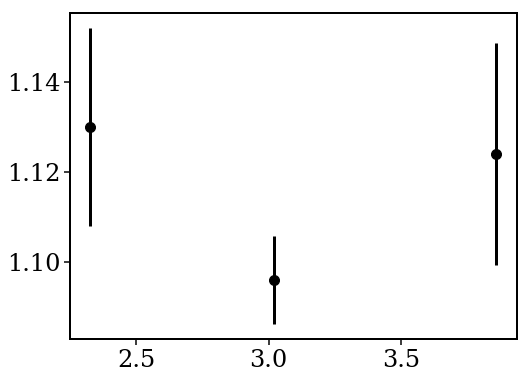

In [73]:
print(len(source_list_20191124))
print(source_list_20191124.columns)
# source_list_20191124.loc[0,['age_opt']]=1.94
# source_list_20191124.age_opt.sort_values()
# BC03
M05_std.flux_ratio_AV_corr
M13_std.flux_ratio_AV_corr
M13_ret.flux_ratio_AV_corr
print(M05_ret.age_opt.values)
plt.figure(figsize=(8,6))
plt.errorbar(M05_ret.age_opt.values,M05_ret.flux_ratio_AV_corr.values,yerr=M05_std.flux_ratio_AV_corr.values,\
         color='k',label='binned M05',lw=3,fmt='o',markersize=10);

index                             0
Unnamed: 0                        0
ID                            13531
region                           10
field                        goodss
z_best                        0.415
flux_ratio_AV_corr           1.1731
flux_ratio_err_AV_corr    0.0266158
flux_ratio                  1.15625
flux_ratio_err            0.0136635
AV_opt                     0.461989
AV_opt_std                 0.338978
age_opt                     1.35605
age_opt_std                0.593841
model                             3
model_new                         0
Name: 0, dtype: object
index                              5
Unnamed: 0                         5
ID                             20423
region                             1
field                         cosmos
z_best                         0.354
flux_ratio_AV_corr           1.13764
flux_ratio_err_AV_corr    0.00821677
flux_ratio                   1.11181
flux_ratio_err            0.00671463
AV_opt                      0.7

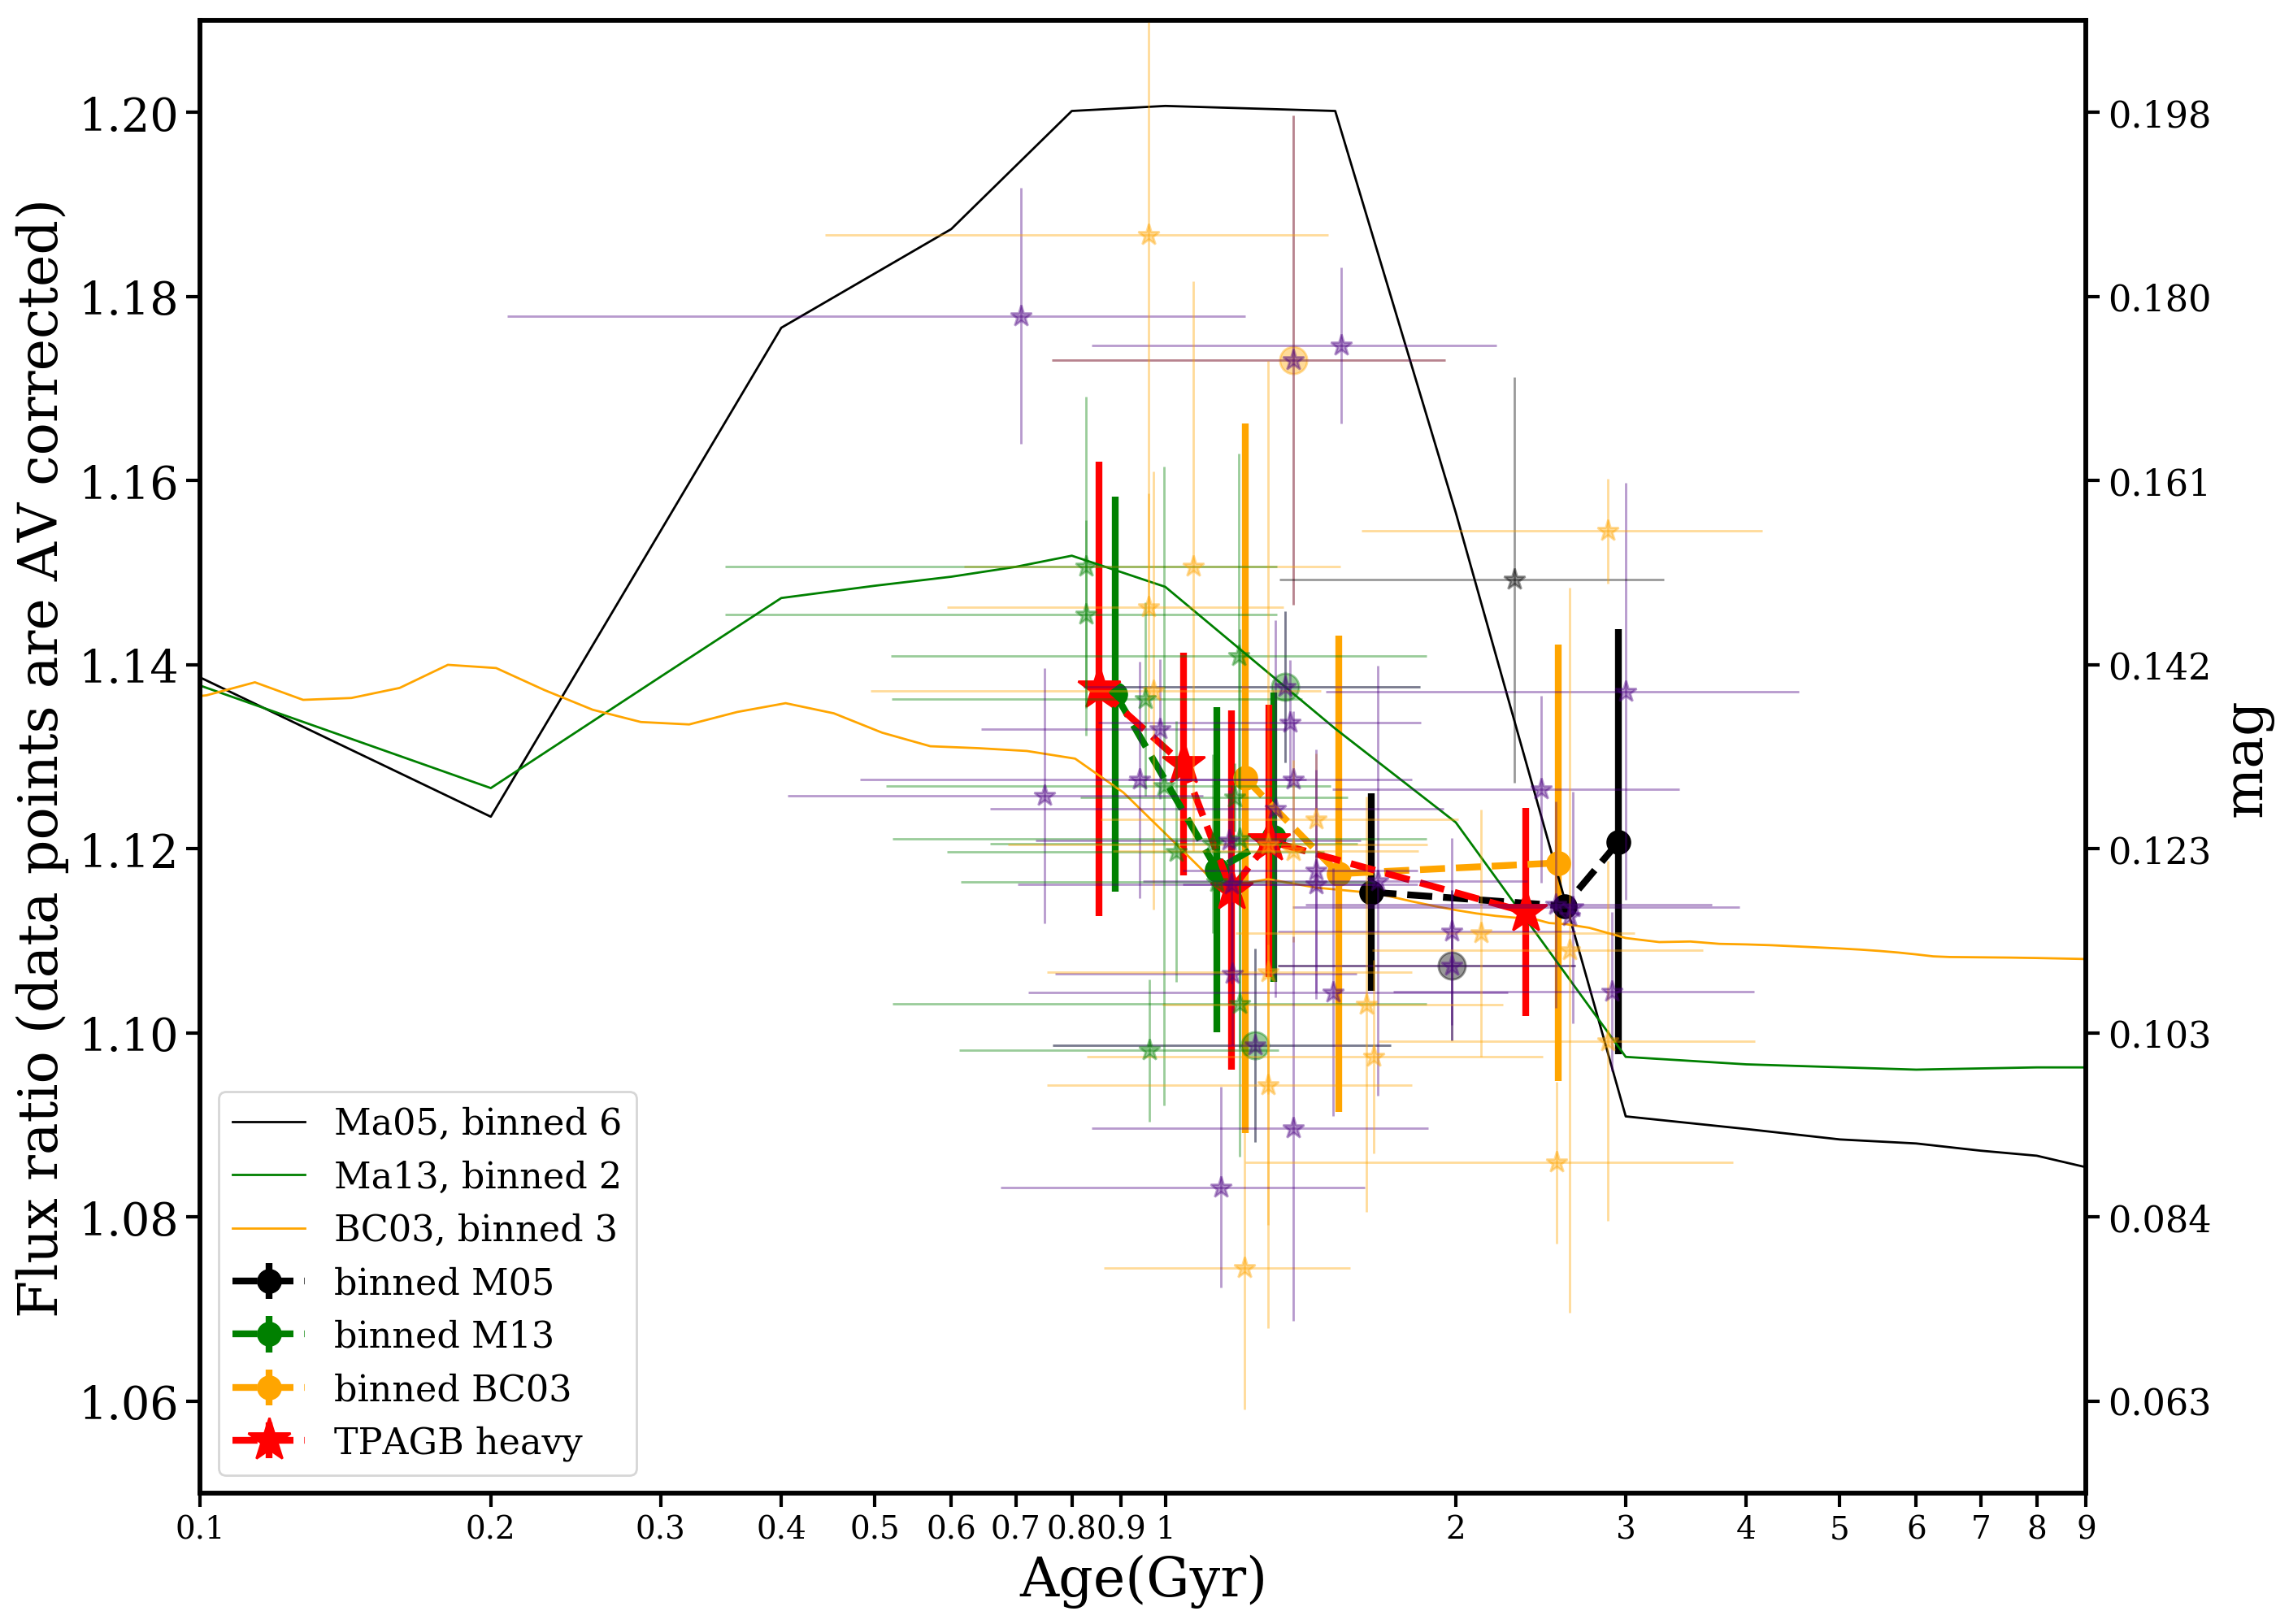

In [86]:
### 8 make subplots
fig=plt.figure(figsize=(16,12),dpi=200)
plt.rc('lines', linewidth=1, markersize=2)
plt.rc('font', size=24, family='serif', weight=300)
plt.rc('mathtext', fontset='stix')
plt.rc('axes', linewidth=2)
plt.rc('xtick.major', width=1.5, size=6)
plt.rc('ytick.major', width=1.5, size=6)
plt.tick_params(axis='both', which='major', labelsize=20)

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
# CN_69=CN_69

colorset=['indigo','k','g','orange']
for i in range(len(source_list_20191124)):
    c = source_list_20191124.model_new.values.astype(int)[i]
    ax1.errorbar(source_list_20191124.iloc[i].age_opt,\
             source_list_20191124.iloc[i].flux_ratio_AV_corr,\
             xerr=source_list_20191124.iloc[i].age_opt_std,\
             yerr=source_list_20191124.iloc[i].flux_ratio_err_AV_corr,\
             color=colorset[c],\
             markersize=10,\
             alpha=0.4,\
             zorder=10,fmt='*')

for i in [0,5,7,13]:
    c = source_list_20191124.model.values.astype(int)[i]
    print(source_list_20191124.iloc[i])
    ax1.errorbar(source_list_20191124.iloc[i].age_opt,\
             source_list_20191124.iloc[i].flux_ratio_AV_corr,\
             xerr=source_list_20191124.iloc[i].age_opt_std,\
             yerr=source_list_20191124.iloc[i].flux_ratio_err_AV_corr,\
             color=colorset[c],\
             markersize=12,\
             alpha=0.4,
             fmt='o')


# attenuated
ax1.plot(df_Ma.Age.unique(), Lick_index_list_Ma05_smoothed_6, label='Ma05, binned 6', color='k')

ax1.plot(df_M13.Age.unique()[1:], Lick_index_list_Ma13_smoothed_2[1:], label='Ma13, binned 2', color='green')

ax1.plot(BC03_age_list_num, Lick_index_list_BC03_smoothed_3, label='BC03, binned 3', color='orange')



ax1.errorbar(M05_ret.age_opt.values, M05_ret.flux_ratio_AV_corr.values, yerr=M05_std.flux_ratio_AV_corr.values,\
         color='k',label='binned M05',lw=3,fmt='--o',markersize=10);
ax1.errorbar(M13_ret.age_opt.values, M13_ret.flux_ratio_AV_corr.values, yerr=M13_std.flux_ratio_AV_corr.values,\
         color='green',label='binned M13',lw=3,fmt='--o',markersize=10);
ax1.errorbar(BC03_ret.age_opt.values, BC03_ret.flux_ratio_AV_corr.values, yerr=BC03_std.flux_ratio_AV_corr.values, color='orange',\
         label='binned BC03',lw=3,fmt='--o',markersize=10);
# ax1.plot(tot_ret.age_opt.dropna(),tot_ret.flux_ratio_AV_corr.dropna(),\
#          label='tot',marker='o',color='indigo',lw=3,markersize=10);
ax1.errorbar(TPAGB_heavy_ret.age_opt.values, TPAGB_heavy_ret.flux_ratio_AV_corr.values,yerr=TPAGB_heavy_std.flux_ratio_AV_corr.values,\
         label='TPAGB heavy',fmt='--*',color='red',lw=3,markersize=20);

ax1.set_ylim([1.05, 1.21])



ax1Ys = ax1.get_yticks()

ax2Ys = []
for Y in ax1Ys:
    tick = "{0:.3f}".format(2.5*np.log10(Y))
    ax2Ys.append(tick)

ax2.set_yticks(ax1Ys)
ax2.set_ybound(ax1.get_ybound())
ax2.set_yticklabels(ax2Ys)

ax2.yaxis.set_tick_params(labelsize=16)


# new_tick_locations=axs1.get_xticks()
# ticks = ['%.2E' % Decimal(i) for i in (new_tick_locations/1000)] # <-- make new ticks
# axs2.set_xticks(new_tick_locations)
# axs2.set_xticklabels(ticks, rotation = 45) # <-- assign new ticks and rotate them




# ax2.yaxis.set_major_formatter(FuncFormatter(lambda r: 2.5*np.log10(r)))
# ax2.axis['top'].major_ticklabels.set_visible(False)

ax1.legend(prop={'size':16}, loc='lower left')
tick_labels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,\
             3,4,5,6,7,8,9]

fig.subplots_adjust(right=0.85)
ax1.set_xlim(0.1,9)
ax1.semilogx()
ax1.set_xticks(tick_labels)
ax1.set_xticklabels(tick_labels,fontsize=14)
ax1.set_xlabel('Age(Gyr)')
ax1.set_ylabel('Flux ratio (data points are AV corrected)')
ax2.set_ylabel('mag')
# ax1.axvline(0.1)
# ax1.axvline(3)

fn_fig = current_dir+outcome_dir+plot_dir+\
         'flux_ratio_age_62_mag_binned_smoothed_5_cross-matches_smoothed_attenuated_datapoints_AV_corr_binned'+date+'.pdf'
fig.savefig(fn_fig)


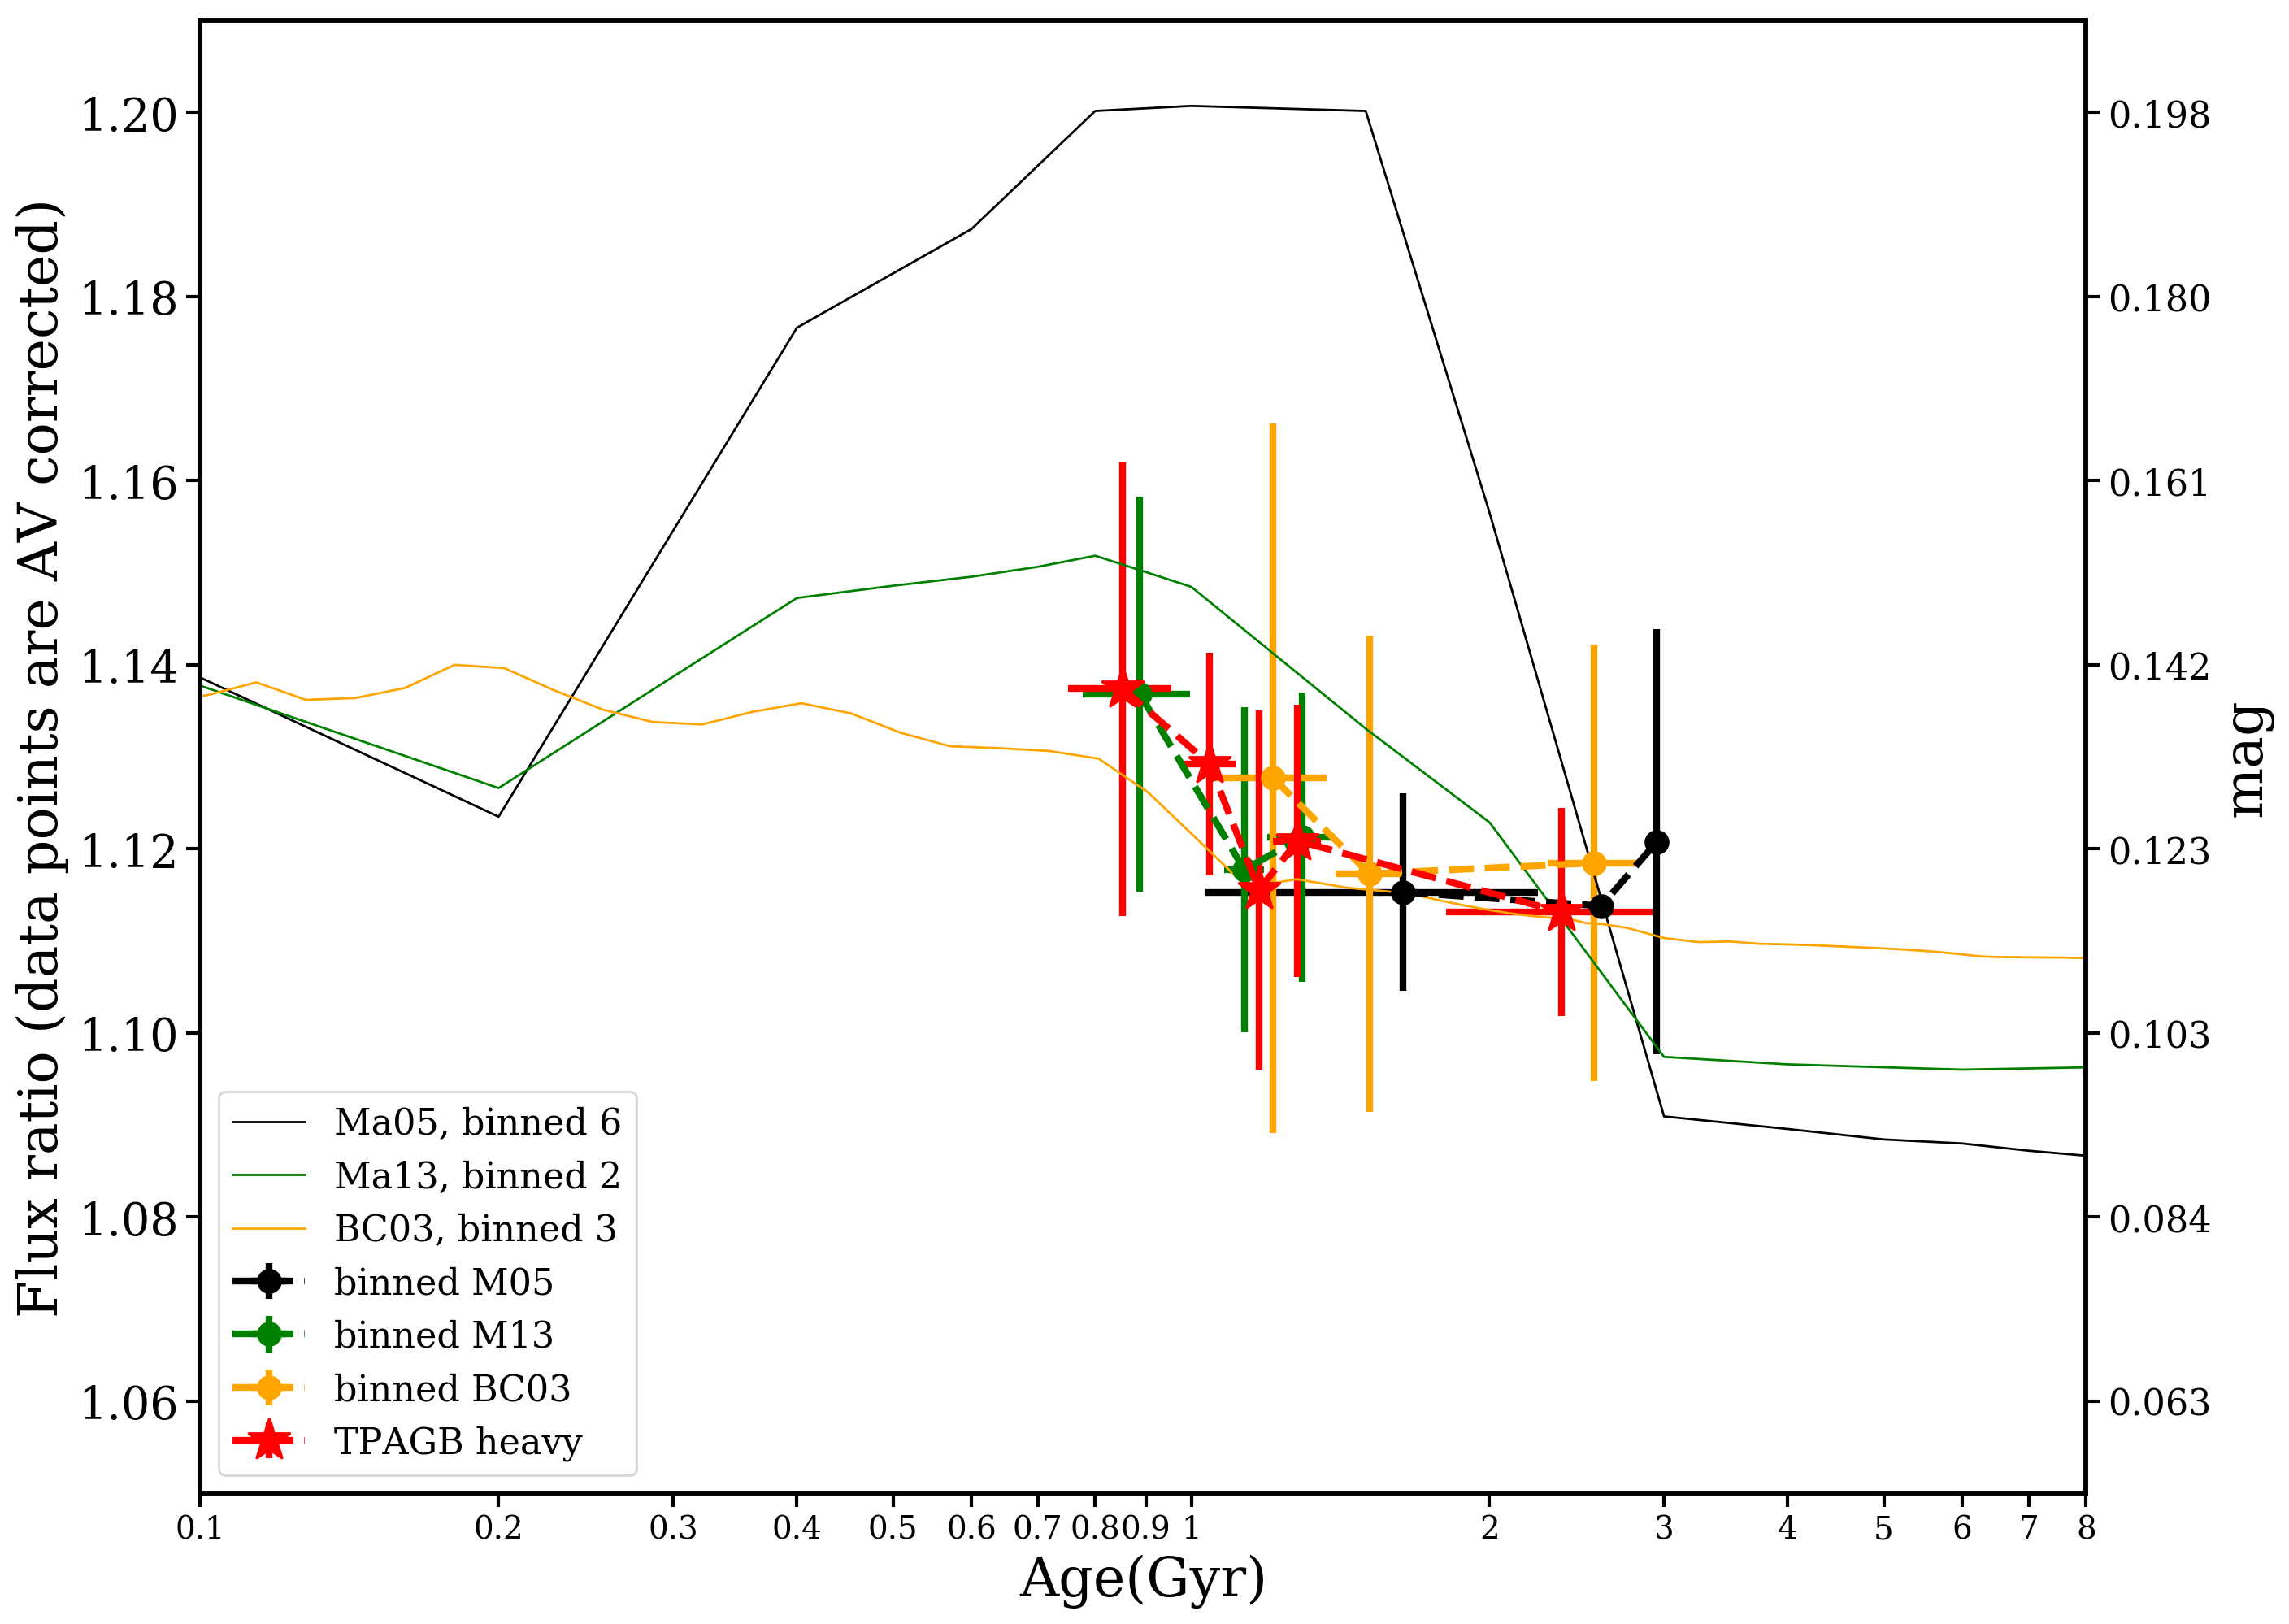

In [87]:
### 8 make subplots
fig=plt.figure(figsize=(16,12),dpi=200)
plt.rc('lines', linewidth=1, markersize=2)
plt.rc('font', size=24, family='serif', weight=300)
plt.rc('mathtext', fontset='stix')
plt.rc('axes', linewidth=2)
plt.rc('xtick.major', width=1.5, size=6)
plt.rc('ytick.major', width=1.5, size=6)
plt.tick_params(axis='both', which='major', labelsize=20)

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
# CN_69=CN_69

colorset=['indigo','k','g','orange']

# attenuated
ax1.plot(df_Ma.Age.unique(), Lick_index_list_Ma05_smoothed_6, label='Ma05, binned 6', color='k')

ax1.plot(df_M13.Age.unique()[1:], Lick_index_list_Ma13_smoothed_2[1:], label='Ma13, binned 2', color='green')

ax1.plot(BC03_age_list_num, Lick_index_list_BC03_smoothed_3, label='BC03, binned 3', color='orange')

ax1.errorbar(M05_ret.age_opt.values, M05_ret.flux_ratio_AV_corr.values, 
             xerr=M05_std.age_opt.values,\
             yerr=M05_std.flux_ratio_AV_corr.values,\
         color='k',label='binned M05',lw=3,fmt='--o',markersize=10);
ax1.errorbar(M13_ret.age_opt.values, M13_ret.flux_ratio_AV_corr.values, \
             xerr=M13_std.age_opt.values,\
             yerr=M13_std.flux_ratio_AV_corr.values,\
         color='green',label='binned M13',lw=3,fmt='--o',markersize=10);
ax1.errorbar(BC03_ret.age_opt.values, BC03_ret.flux_ratio_AV_corr.values,\
             xerr=BC03_std.age_opt.values,\
             yerr=BC03_std.flux_ratio_AV_corr.values, color='orange',\
         label='binned BC03',lw=3,fmt='--o',markersize=10);
# ax1.plot(tot_ret.age_opt.dropna(),tot_ret.flux_ratio_AV_corr.dropna(),\
#          label='tot',marker='o',color='indigo',lw=3,markersize=10);
ax1.errorbar(TPAGB_heavy_ret.age_opt.values, TPAGB_heavy_ret.flux_ratio_AV_corr.values,\
             xerr=TPAGB_heavy_std.age_opt.values,\
             yerr=TPAGB_heavy_std.flux_ratio_AV_corr.values,\
         label='TPAGB heavy',fmt='--*',color='red',lw=3,markersize=20);


ax1.set_ylim([1.05, 1.21])



ax1Ys = ax1.get_yticks()

ax2Ys = []
for Y in ax1Ys:
    tick = "{0:.3f}".format(2.5*np.log10(Y))
    ax2Ys.append(tick)

ax2.set_yticks(ax1Ys)
ax2.set_ybound(ax1.get_ybound())
ax2.set_yticklabels(ax2Ys)

ax2.yaxis.set_tick_params(labelsize=16)


# new_tick_locations=axs1.get_xticks()
# ticks = ['%.2E' % Decimal(i) for i in (new_tick_locations/1000)] # <-- make new ticks
# axs2.set_xticks(new_tick_locations)
# axs2.set_xticklabels(ticks, rotation = 45) # <-- assign new ticks and rotate them




# ax2.yaxis.set_major_formatter(FuncFormatter(lambda r: 2.5*np.log10(r)))
# ax2.axis['top'].major_ticklabels.set_visible(False)

ax1.legend(prop={'size':16}, loc='lower left')
tick_labels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,\
             3,4,5,6,7,8]

fig.subplots_adjust(right=0.85)
ax1.set_xlim(0.1,8)
ax1.semilogx()
ax1.set_xticks(tick_labels)
ax1.set_xticklabels(tick_labels,fontsize=14)
ax1.set_xlabel('Age(Gyr)')
ax1.set_ylabel('Flux ratio (data points are AV corrected)')
ax2.set_ylabel('mag')
# ax1.axvline(0.1)
# ax1.axvline(3)

fn_fig = current_dir+outcome_dir+plot_dir+\
         'flux_ratio_age_62_attenuated_datapoints_AV_corr_binned'+date+'.pdf'
fig.savefig(fn_fig)

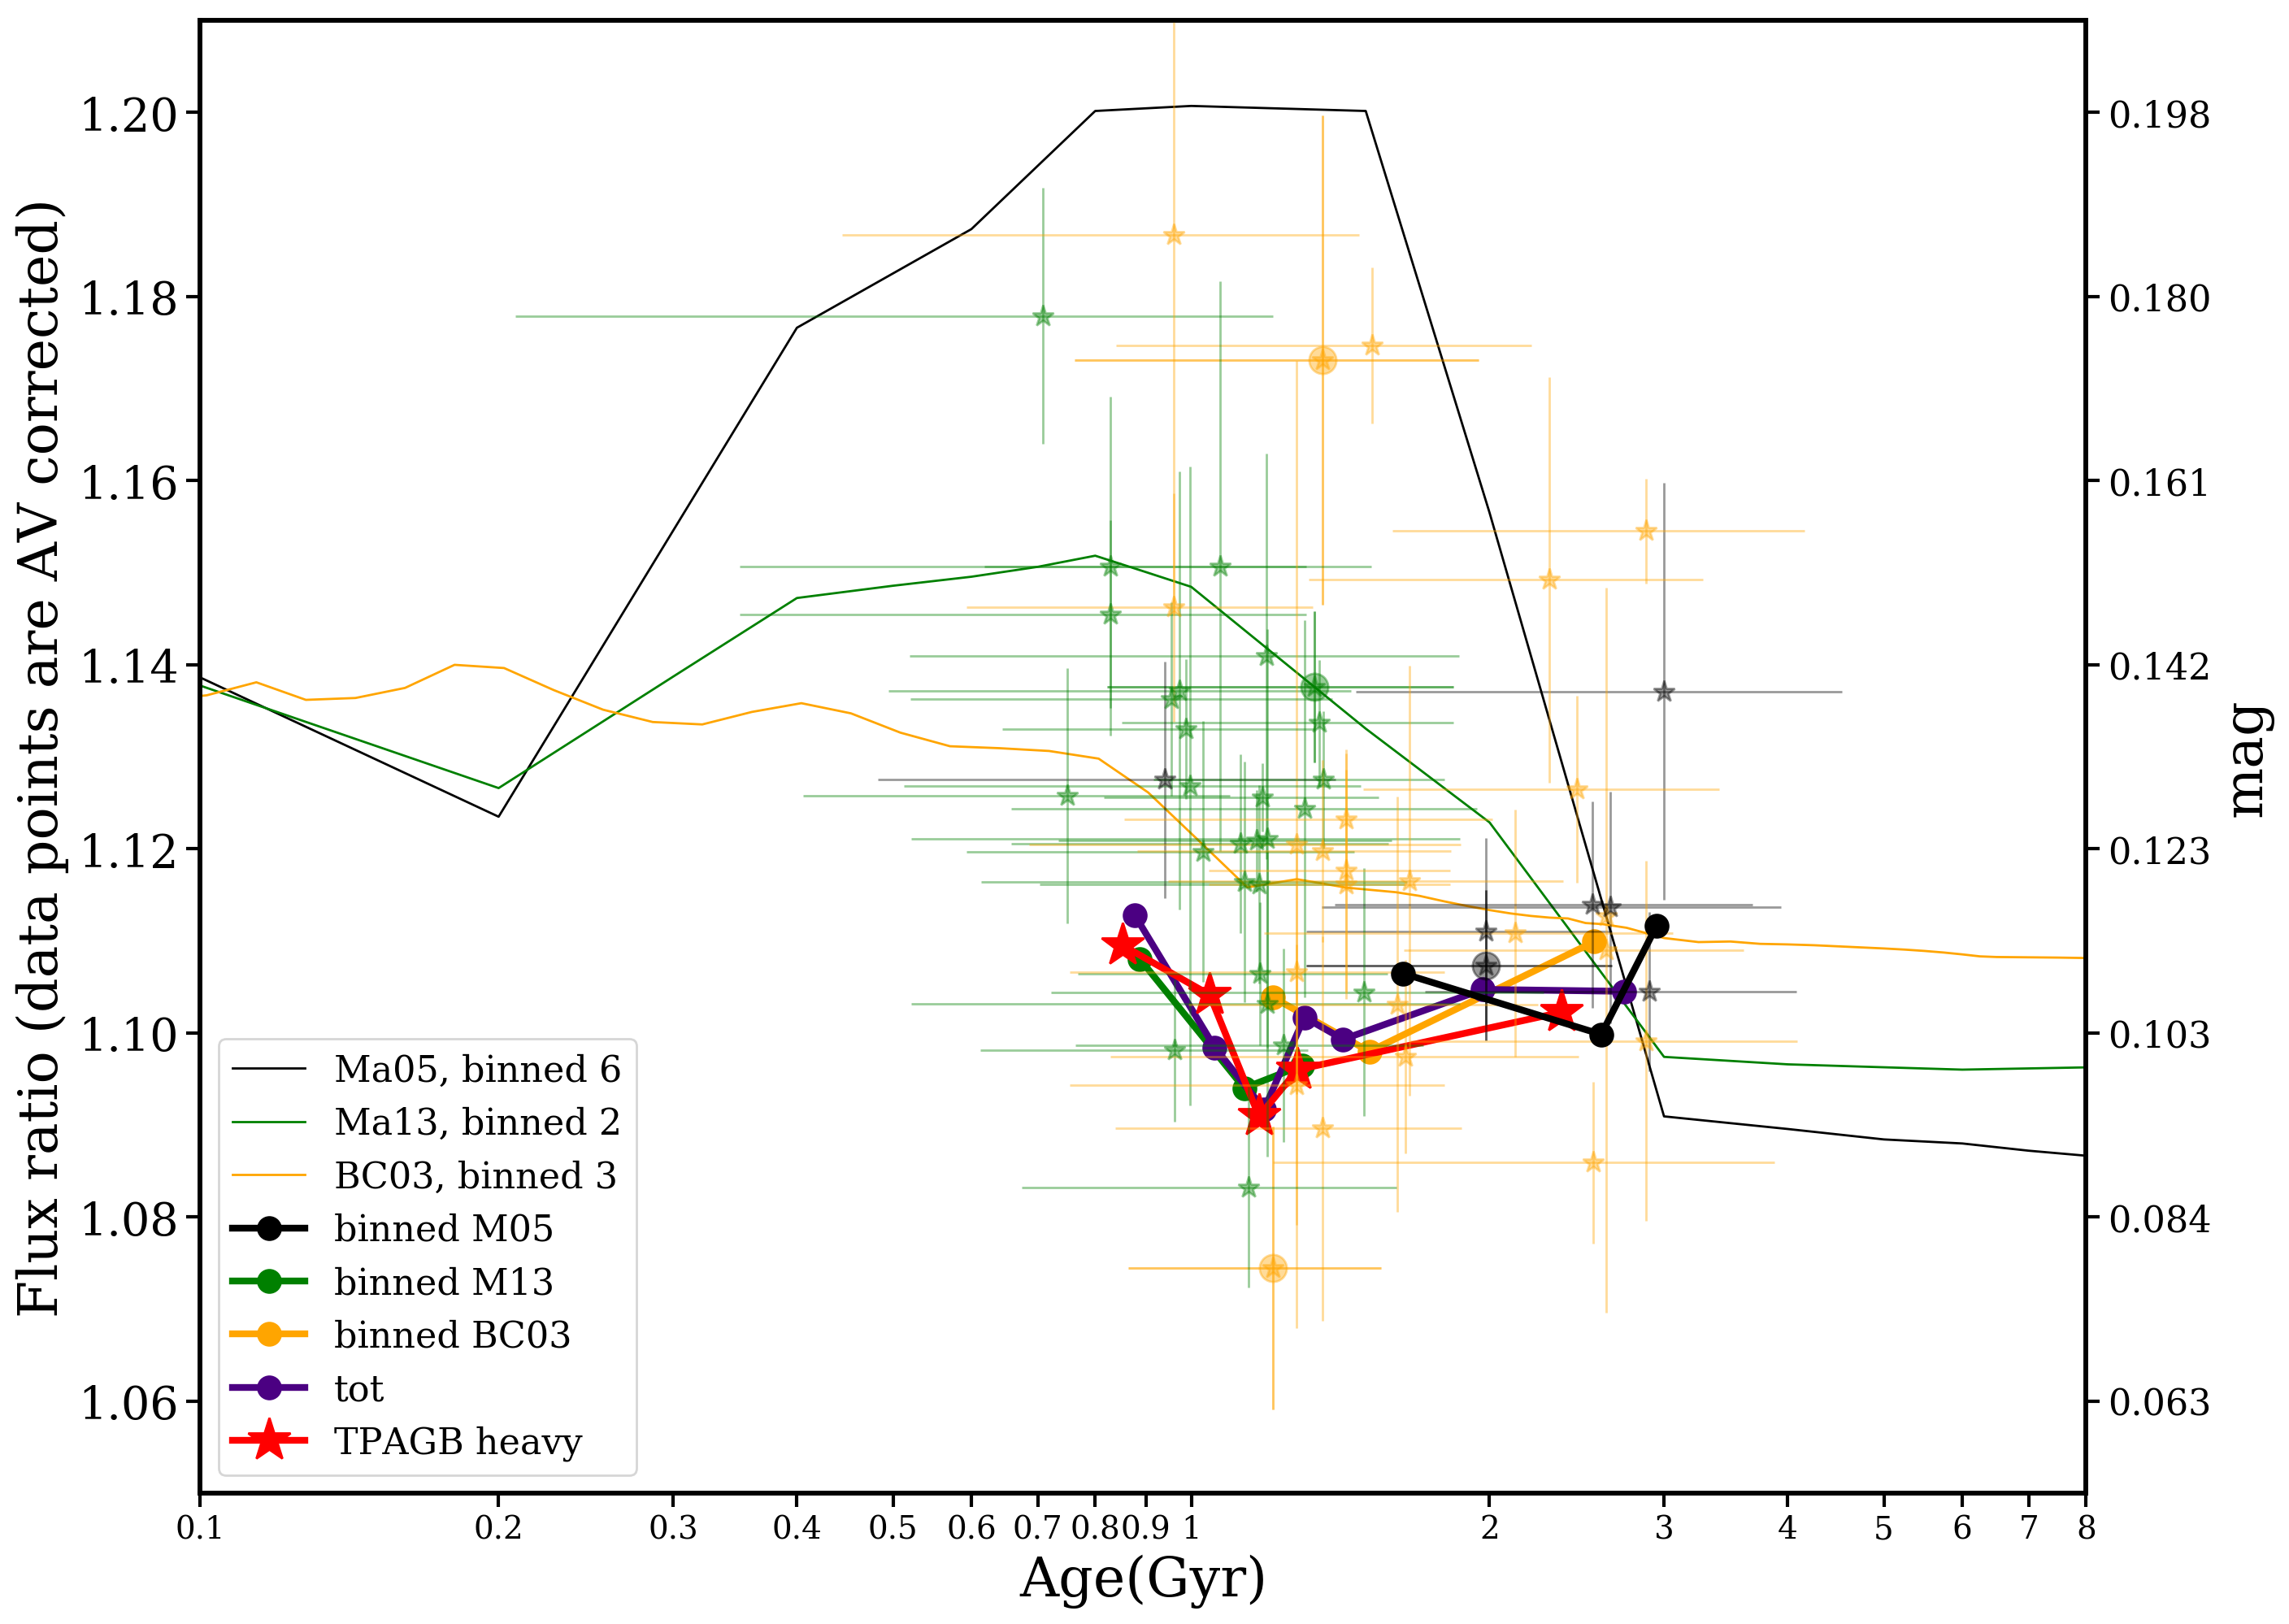

In [89]:
### 8 make subplots
fig=plt.figure(figsize=(16,12),dpi=200)
plt.rc('lines', linewidth=1, markersize=2)
plt.rc('font', size=24, family='serif', weight=300)
plt.rc('mathtext', fontset='stix')
plt.rc('axes', linewidth=2)
plt.rc('xtick.major', width=1.5, size=6)
plt.rc('ytick.major', width=1.5, size=6)
plt.tick_params(axis='both', which='major', labelsize=20)

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
# CN_69=CN_69

colorset=['indigo','k','g','orange']
for i in range(len(source_list_20191124)):
    c = source_list_20191124.model.values.astype(int)[i]
    ax1.errorbar(source_list_20191124.iloc[i].age_opt,\
             source_list_20191124.iloc[i].flux_ratio_AV_corr,\
             xerr=source_list_20191124.iloc[i].age_opt_std,\
             yerr=source_list_20191124.iloc[i].flux_ratio_err_AV_corr,\
             color=colorset[c],\
             markersize=10,\
             alpha=0.4,\
             zorder=10,fmt='*')

for i in [0,5,7,14]:
    c = source_list_20191124.model.values.astype(int)[i]
    ax1.errorbar(source_list_20191124.iloc[i].age_opt,\
             source_list_20191124.iloc[i].flux_ratio_AV_corr,\
             xerr=source_list_20191124.iloc[i].age_opt_std,\
             yerr=source_list_20191124.iloc[i].flux_ratio_err_AV_corr,\
             color=colorset[c],\
             markersize=12,\
             alpha=0.4,
             fmt='o')


# attenuated
ax1.plot(df_Ma.Age.unique(), Lick_index_list_Ma05_smoothed_6, label='Ma05, binned 6', color='k')

ax1.plot(df_M13.Age.unique()[1:], Lick_index_list_Ma13_smoothed_2[1:], label='Ma13, binned 2', color='green')

ax1.plot(BC03_age_list_num, Lick_index_list_BC03_smoothed_3, label='BC03, binned 3', color='orange')

ax1.plot(M05_ret.age_opt.dropna(),M05_ret.flux_ratio.dropna(),\
         color='k',label='binned M05',lw=3,marker='o',markersize=10,zorder=100);
ax1.plot(M13_ret.age_opt.dropna(),M13_ret.flux_ratio.dropna(),\
         color='green',label='binned M13',lw=3,marker='o',markersize=10);
ax1.plot(BC03_ret.age_opt,BC03_ret.flux_ratio,color='orange',\
         label='binned BC03',lw=3,marker='o',markersize=10);
ax1.plot(tot_ret.age_opt.dropna(),tot_ret.flux_ratio.dropna(),\
         label='tot',marker='o',color='indigo',lw=3,markersize=10);
ax1.plot(TPAGB_heavy_ret.age_opt.dropna(),TPAGB_heavy_ret.flux_ratio.dropna(),\
         label='TPAGB heavy',marker='*',color='red',lw=3,markersize=20);

ax1.set_ylim([1.05, 1.21])



ax1Ys = ax1.get_yticks()

ax2Ys = []
for Y in ax1Ys:
    tick = "{0:.3f}".format(2.5*np.log10(Y))
    ax2Ys.append(tick)

ax2.set_yticks(ax1Ys)
ax2.set_ybound(ax1.get_ybound())
ax2.set_yticklabels(ax2Ys)

ax2.yaxis.set_tick_params(labelsize=16)


# new_tick_locations=axs1.get_xticks()
# ticks = ['%.2E' % Decimal(i) for i in (new_tick_locations/1000)] # <-- make new ticks
# axs2.set_xticks(new_tick_locations)
# axs2.set_xticklabels(ticks, rotation = 45) # <-- assign new ticks and rotate them




# ax2.yaxis.set_major_formatter(FuncFormatter(lambda r: 2.5*np.log10(r)))
# ax2.axis['top'].major_ticklabels.set_visible(False)

ax1.legend(prop={'size':16}, loc='lower left')
tick_labels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,\
             3,4,5,6,7,8]

fig.subplots_adjust(right=0.85)
ax1.set_xlim(0.1,8)
ax1.semilogx()
ax1.set_xticks(tick_labels)
ax1.set_xticklabels(tick_labels,fontsize=14)
ax1.set_xlabel('Age(Gyr)')
ax1.set_ylabel('Flux ratio (data points are AV corrected)')
ax2.set_ylabel('mag')
# ax1.axvline(0.1)
# ax1.axvline(3)

fn_fig = current_dir+outcome_dir+plot_dir+\
         'flux_ratio_age_58_mag_binned_smoothed_5_cross-matches_smoothed_attenuated_datapoints_AV_corr_binned'+date+'.pdf'
fig.savefig(fn_fig)


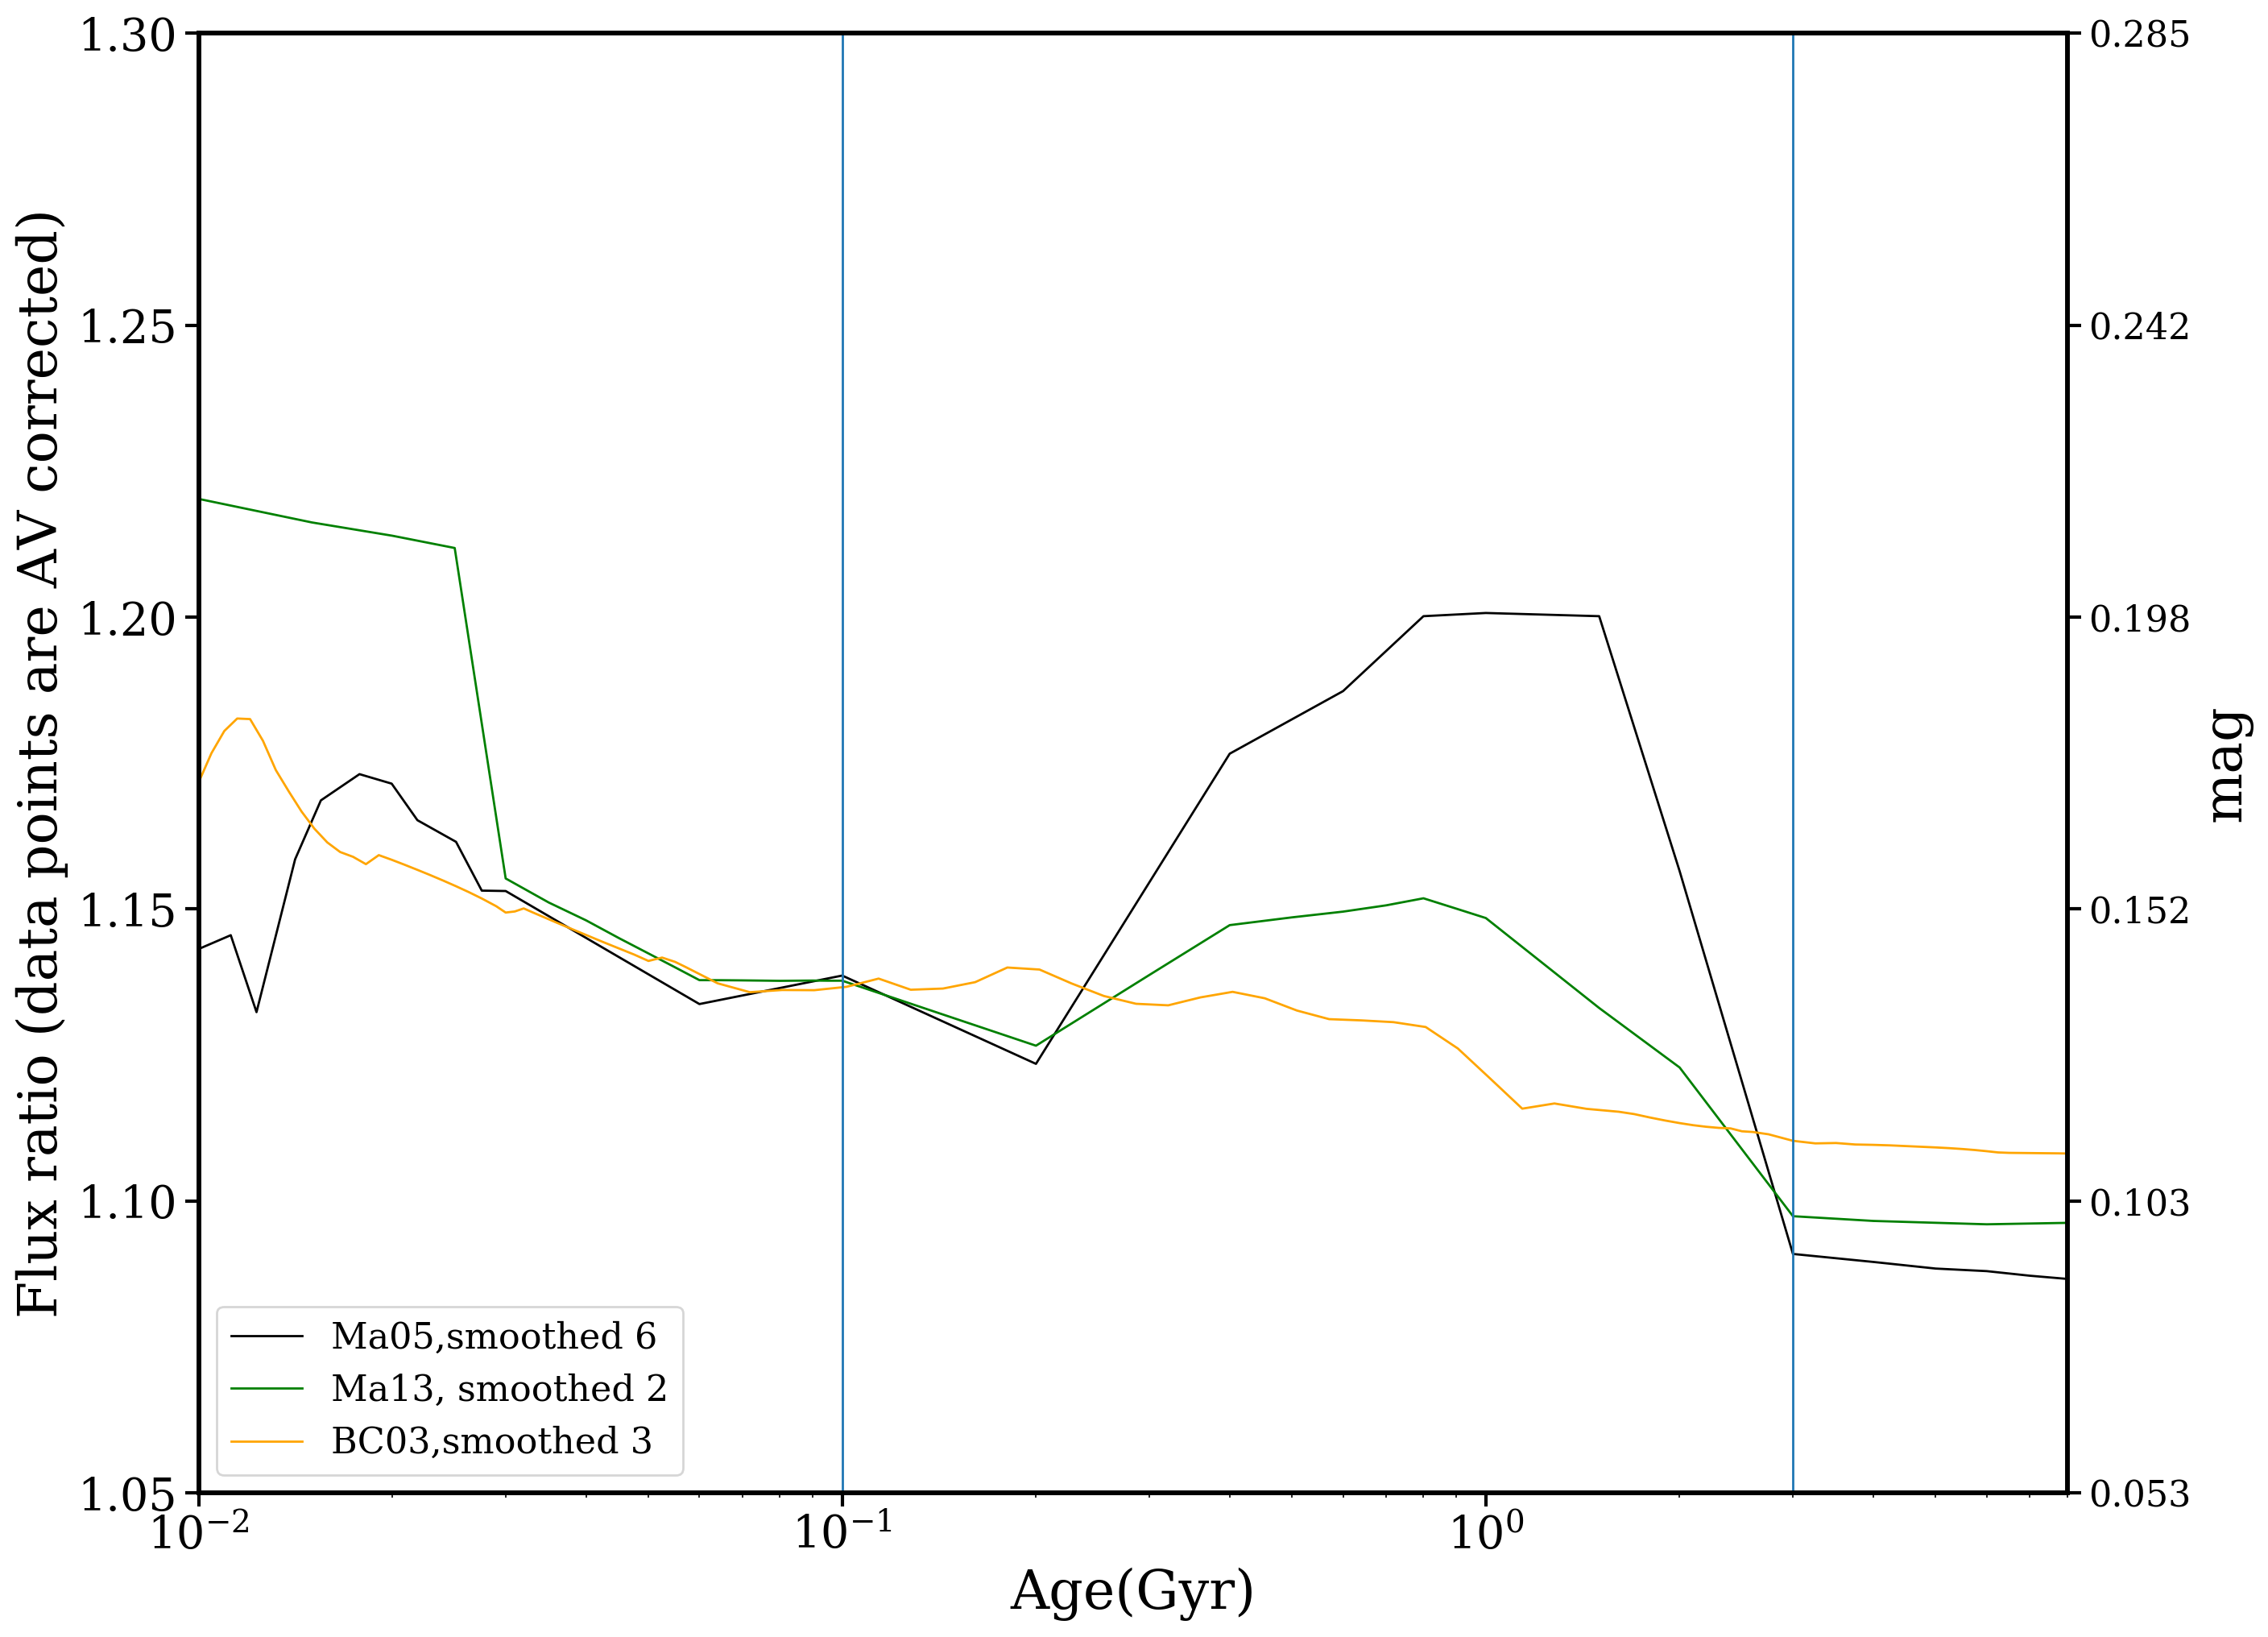

In [67]:
fig=plt.figure(figsize=(16,12),dpi=200)
plt.rc('lines', linewidth=1, markersize=2)
plt.rc('font', size=24, family='serif', weight=300)
plt.rc('mathtext', fontset='stix')
plt.rc('axes', linewidth=2)
plt.rc('xtick.major', width=1.5, size=6)
plt.rc('ytick.major', width=1.5, size=6)
plt.tick_params(axis='both', which='major', labelsize=20)

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
# CN_69=CN_69

colorset=['indigo','k','g','orange']
# for i in range(len(source_list_20191124)):
#     c = source_list_20191124.model.values.astype(int)[i]
#     ax1.errorbar(source_list_20191124.iloc[i].age_opt,\
#              source_list_20191124.iloc[i].flux_ratio_AV_corr,\
#              xerr=source_list_20191124.iloc[i].age_std,\
#              yerr=source_list_20191124.iloc[i].flux_ratio_err_AV_corr,\
#              color=colorset[c],\
#              markersize=10,\
#              alpha=0.4,\
#              zorder=10,fmt='*')
# # for i in range(len(CN_69)):
# #     c = CN_69.model_new.values.astype(int)[i]
# #     ax1.errorbar(CN_69.iloc[i].age_opt,\
# #              CN_69.iloc[i].flux_ratio,\
# #              xerr=CN_69.iloc[i].age_std,\
# #              yerr=CN_69.iloc[i].flux_ratio_err,\
# #              color=colorset[c],\
# #              markersize=10,\
# #              alpha=0.4,\
# #              zorder=10,fmt='*')
# # # for i in [0,11,17,20,48]:
# for i in [0,5,7,14]:
#     c = source_list_20191124.model.values.astype(int)[i]
#     ax1.errorbar(source_list_20191124.iloc[i].age_opt,\
#              source_list_20191124.iloc[i].flux_ratio_AV_corr,\
#              xerr=source_list_20191124.iloc[i].age_std,\
#              yerr=source_list_20191124.iloc[i].flux_ratio_err_AV_corr,\
#              color=colorset[c],\
#              markersize=12,\
#              alpha=0.4,
#              fmt='o')
# 
# for i in range(len(CN_old)):
#     c = CN_old.model.values.astype(int)[i]
#     ax1.errorbar(CN_old.iloc[i].age_opt,\
#              CN_old.iloc[i].flux_ratio_AV_corr,\
#              xerr=CN_old.iloc[i].age_std,\
#              yerr=CN_old.iloc[i].flux_ratio_err_AV_corr,\
#              color=colorset[c],\
#              markersize=10,\
#              alpha=0.4,\
#              zorder=10,fmt='*')
# for i in range(len(CN_young)):
#     c = CN_young.model.values.astype(int)[i]
#     ax1.errorbar(CN_young.iloc[i].age_opt,\
#              CN_young.iloc[i].flux_ratio_AV_corr,\
#              xerr=CN_young.iloc[i].age_std,\
#              yerr=CN_young.iloc[i].flux_ratio_err_AV_corr,\
#              color=colorset[c],\
#              markersize=10,\
#              alpha=0.4,\
#              zorder=10,fmt='*')

# for i in range(len(CN_young)):
#     c = CN_young.model.values.astype(int)[i]
#     ax1.errorbar(CN_young.iloc[i].age_opt,\
#              CN_young.iloc[i].flux_ratio,\
#              xerr=CN_young.iloc[i].age_std,\
#              yerr=CN_young.iloc[i].flux_ratio_err,\
#              color=colorset[c],\
#              markersize=10,\
#              alpha=0.4,\
#              zorder=10,fmt='*')

# # unattenuated
# ax1.plot(df_Ma.Age.unique(),Lick_index_list_M05_SSP_smoothed_6,color='k',linestyle='-.',label='M05, smoothed 6')
# ax1.plot(df_M13.Age.unique(),Lick_index_list_M13_SSP_smoothed_2,color='green',linestyle='-.',label='M13, smoothed 2')
# ax1.plot(BC03_age_list.astype(np.float)/1e9,Lick_index_list_BC03_SSP_smoothed_3,color='orange',linestyle='-.',label='BC03, smoothed 3')

# attenuated
ax1.plot(df_Ma.Age.unique(), Lick_index_list_Ma05_smoothed_6, label='Ma05,smoothed 6', color='k')
# ax1.plot(df_Ma.Age.unique(), Lick_index_list_Ma05_13_AV0237_smoothed_6, label=r'Ma05, $\rm A_V=0.237$, smoothed 6', color='k',linestyle=':')
# ax1.plot(df_Ma.Age.unique(), Lick_index_list_Ma05_69_AV0533_smoothed_6, label=r'Ma05, $\rm A_V=0.533$, smoothed 6', color='k',linestyle='-.')

#print('Difference due to attenuation:', np.max(Lick_index_list_Ma05-Lick_index_list_Ma05_69_AV0533), np.max(Lick_index_list_Ma05-Lick_index_list_Ma05_13_AV0237))

ax1.plot(df_M13.Age.unique()[1:], Lick_index_list_Ma13_smoothed_2[1:], label='Ma13, smoothed 2', color='green')
# ax1.plot(df_M13.Age.unique()[1:], Lick_index_list_Ma13_13_AV0237_smoothed_2[1:], label=r'Ma13, $\rm A_V=0.237$, smoothed 2', color='green',linestyle=':')
#ax1.plot(df_M13.Age.unique()[1:], Lick_index_list_Ma13_69_AV0533_smoothed_2[1:], label=r'Ma13, $\rm A_V=0.533$, smoothed 2', color='green',linestyle='-.')

ax1.plot(BC03_age_list_num, Lick_index_list_BC03_smoothed_3, label='BC03,smoothed 3', color='orange')
#ax1.plot(BC03_age_list_num, Lick_index_list_BC03_13_AV0237_smoothed_3, label=r'BC03, $\rm A_V=0.237$, smoothed 3', color='orange',linestyle=':')
#ax1.plot(BC03_age_list_num, Lick_index_list_BC03_69_AV0533_smoothed_3, label=r'BC03, $\rm A_V=0.533$, smoothed 3', color='orange',linestyle='-.')

ax1.set_ylim([1.05, 1.3])



ax1Ys = ax1.get_yticks()

ax2Ys = []
for Y in ax1Ys:
    tick = "{0:.3f}".format(2.5*np.log10(Y))
    ax2Ys.append(tick)

ax2.set_yticks(ax1Ys)
ax2.set_ybound(ax1.get_ybound())
ax2.set_yticklabels(ax2Ys)

ax2.yaxis.set_tick_params(labelsize=16)


# new_tick_locations=axs1.get_xticks()
# ticks = ['%.2E' % Decimal(i) for i in (new_tick_locations/1000)] # <-- make new ticks
# axs2.set_xticks(new_tick_locations)
# axs2.set_xticklabels(ticks, rotation = 45) # <-- assign new ticks and rotate them




# ax2.yaxis.set_major_formatter(FuncFormatter(lambda r: 2.5*np.log10(r)))
# ax2.axis['top'].major_ticklabels.set_visible(False)

ax1.legend(prop={'size':16}, loc='lower left')


fig.subplots_adjust(right=0.85)
ax1.set_xlim(0.01,8)
ax1.semilogx()
ax1.set_xlabel('Age(Gyr)')
ax1.set_ylabel('Flux ratio (data points are AV corrected)')
ax2.set_ylabel('mag')
ax1.axvline(0.1)
ax1.axvline(3)

fn_fig = current_dir+outcome_dir+plot_dir+\
         'flux_ratio_age_66_mag_binned_smoothed_5_cross-matches_smoothed_attenuated_datapoints_AV_corr_old_young_'+date+'.pdf'
fig.savefig(fn_fig)


In [19]:
# # print(source_list_20191124.flux_ratio_AV_corr)
# print(CN_old.flux_ratio_AV_corr)
# print(CN_old.flux_ratio_err_AV_corr)
# print(CN_old.iloc[5])



0.5902050995447374 0.2265103560439145


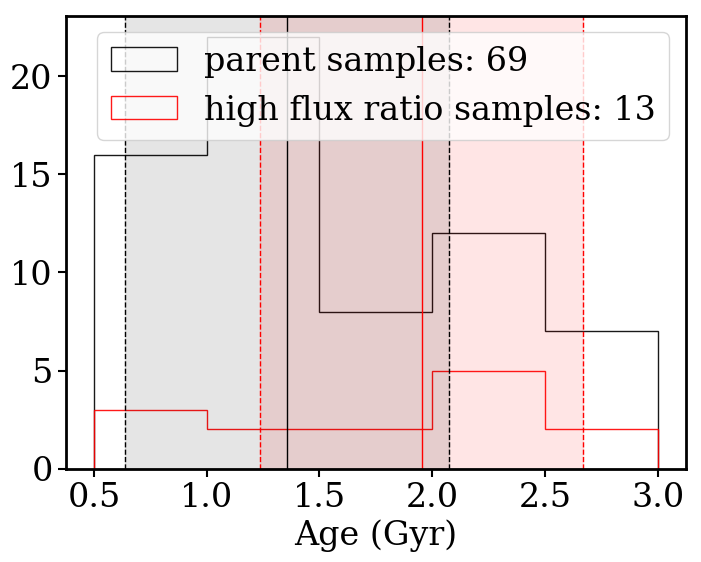

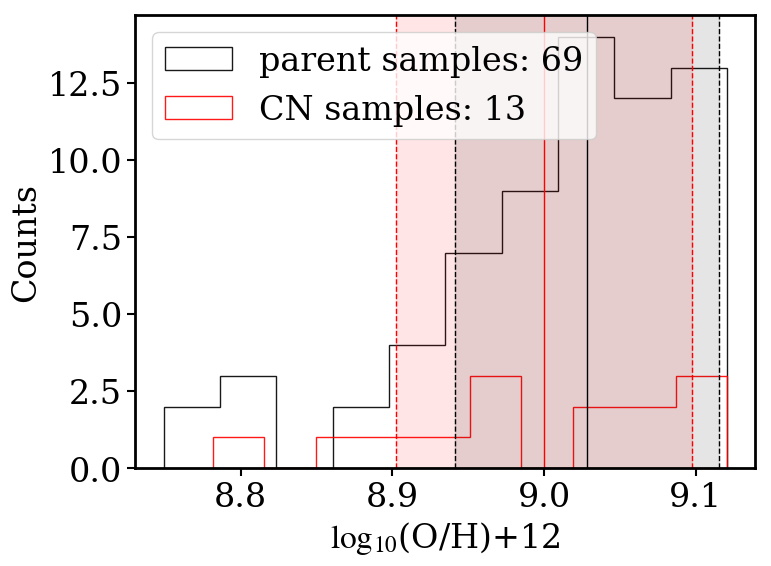

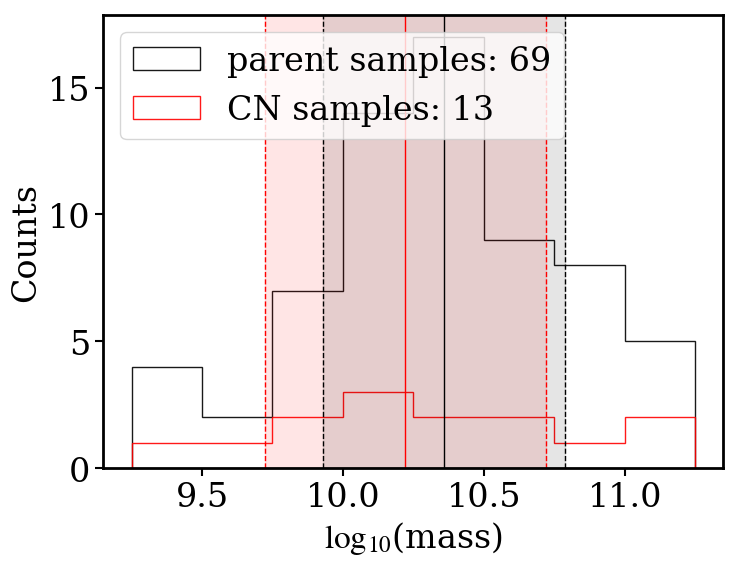

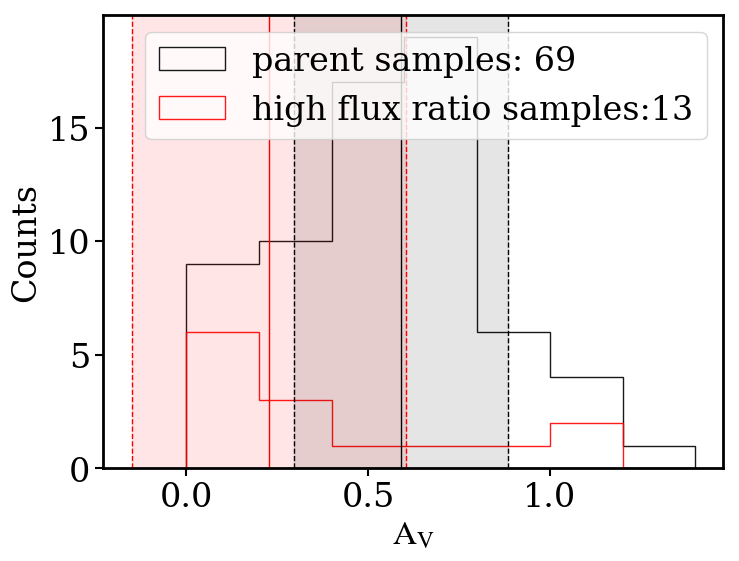

In [20]:
### 9 hist.

#### 9.1 hist CN plot age
plt.figure(figsize=(8, 6), dpi=100)

plt.hist(
    CN_69.age_opt,
    histtype='step',
    color='k',
    bins=[0.5,1.0,1.5,2.0,2.5,3.0],
    alpha=0.9,
    #density=True,
    label='parent samples: 69')
plt.hist(
    CN_samples.age_opt,
    histtype='step',
    bins=[0.5,1.0,1.5,2.0,2.5,3.0],
    color='r',
    alpha=0.9,
    #density=True,
    label='high flux ratio samples: 13')

plt.legend(loc='best')
plt.axvline(np.median(CN_samples.age_opt),color='r')
plt.axvline(np.median(CN_samples.age_opt)-np.std(CN_samples.age_opt),color='r',linestyle='--')
plt.axvline(np.median(CN_samples.age_opt)+np.std(CN_samples.age_opt),color='r',linestyle='--')
plt.axvspan(np.median(CN_samples.age_opt)-np.std(CN_samples.age_opt),
            np.median(CN_samples.age_opt)+np.std(CN_samples.age_opt), alpha=0.1, color='r')

plt.axvline(np.median(CN_69.age_opt),color='k')
plt.axvline(np.median(CN_69.age_opt)-np.std(CN_69.age_opt),color='k',linestyle='--')
plt.axvline(np.median(CN_69.age_opt)+np.std(CN_69.age_opt),color='k',linestyle='--')
plt.axvspan(np.median(CN_69.age_opt)-np.std(CN_69.age_opt),
           np.median(CN_69.age_opt)+np.std(CN_69.age_opt),alpha=0.1,color='k')

plt.xlabel('Age (Gyr)')
fn_fig = current_dir+outcome_dir+plot_dir+'CN_samples_13_69_age_hist_'+date+'.pdf'
plt.savefig(fn_fig)



#### 9.2 hist CN plot metal

plt.figure(figsize=(8, 6), dpi=100)

metal_69 = -1.492 + 1.847*np.log10(CN_69.best_mass)-0.08026*np.log10(CN_69.best_mass)**2
metal_13 =  -1.492 + 1.847*np.log10(CN_samples.best_mass)-0.08026*np.log10(CN_samples.best_mass)**2

plt.hist(
    metal_69,
    histtype='step',
    color='k',
    #bins=[9.25,9.50,9.75,10.,10.25,10.5,10.75,11,11.25],
    alpha=0.9,
    #density=True,
    label='parent samples: 69')
plt.hist(
    metal_13, #np.log10(CN_samples.best_mass),
    histtype='step',
    #bins=[9.25,9.50,9.75,10.,10.25,10.5,10.75,11,11.25],
    color='r',
    alpha=0.9,
    #density=True,
    label='CN samples: 13')

plt.legend(loc='best')
plt.axvline(np.median(metal_13),color='r')
plt.axvline(np.median(metal_13)-np.std(metal_13),color='r',linestyle='--')
plt.axvline(np.median(metal_13)+np.std(metal_13),color='r',linestyle='--')
plt.axvspan(np.median(metal_13)-np.std(metal_13),\
           np.median(metal_13)+np.std(metal_13),alpha=0.1,color='r')

plt.axvline(np.median(metal_69),color='k')
plt.axvline(np.median(metal_69)-np.std(metal_69),color='k',linestyle='--')
plt.axvline(np.median(metal_69)+np.std(metal_69),color='k',linestyle='--')

plt.axvspan(np.median(metal_69)-np.std(metal_69),\
           np.median(metal_69)+np.std(metal_69),alpha=0.1,color='k')
plt.ylabel('Counts')
plt.xlabel(r'$\log_{10}$(O/H)+12')
fn_fig = current_dir+outcome_dir+plot_dir+'CN_samples_13_69_metal_hist_'+date+'.pdf'
plt.savefig(fn_fig)


#### 9.3 hist CN plot mas
plt.figure(figsize=(8, 6), dpi=100)

plt.hist(
    np.log10(CN_69.best_mass),
    histtype='step',
    color='k',
    bins=[9.25,9.50,9.75,10.,10.25,10.5,10.75,11,11.25],
    alpha=0.9,
    #density=True,
    label='parent samples: 69')
plt.hist(
    np.log10(CN_samples.best_mass),
    histtype='step',
    bins=[9.25,9.50,9.75,10.,10.25,10.5,10.75,11,11.25],
    color='r',
    alpha=0.9,
    #density=True,
    label='CN samples: 13')

plt.legend(loc='best')
plt.axvline(np.median(np.log10(CN_samples.best_mass)),color='r')
plt.axvline(np.median(np.log10(CN_samples.best_mass))-np.std(np.log10(CN_samples.best_mass)),color='r',linestyle='--')
plt.axvline(np.median(np.log10(CN_samples.best_mass))+np.std(np.log10(CN_samples.best_mass)),color='r',linestyle='--')
plt.axvspan(np.median(np.log10(CN_samples.best_mass))-np.std(np.log10(CN_samples.best_mass)),\
           np.median(np.log10(CN_samples.best_mass))+np.std(np.log10(CN_samples.best_mass)),alpha=0.1,color='r')

plt.axvline(np.median(np.log10(CN_69.best_mass)),color='k')
plt.axvline(np.median(np.log10(CN_69.best_mass))-np.std(np.log10(CN_69.best_mass)),color='k',linestyle='--')
plt.axvline(np.median(np.log10(CN_69.best_mass))+np.std(np.log10(CN_69.best_mass)),color='k',linestyle='--')

plt.axvspan(np.median(np.log10(CN_69.best_mass))-np.std(np.log10(CN_69.best_mass)),\
           np.median(np.log10(CN_69.best_mass))+np.std(np.log10(CN_69.best_mass)),alpha=0.1,color='k')
plt.ylabel('Counts')
plt.xlabel(r'$\log_{10}$(mass)')
fn_fig = current_dir+outcome_dir+plot_dir+'CN_samples_13_69_mass_hist_'+date+'.pdf'
plt.savefig(fn_fig)



### 9.4 hist AV plot

plt.figure(figsize=(8, 6), dpi=100)

plt.hist(
    CN_69.AV_opt,
    histtype='step',
    color='k',
    bins=[-0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4],
    alpha=0.9,
    #density=True,
    label='parent samples: 69')
plt.hist(
    CN_samples.AV_opt,
    histtype='step',
    bins=[-0.0,0.2,0.4,0.6,0.8,1.0,1.2,1.4],
    color='r',
    alpha=0.9,
    #density=True,
    label='high flux ratio samples:13')

plt.legend(loc='best')
plt.axvline(np.median(CN_samples.AV_opt),color='r')
plt.axvline(np.median(CN_samples.AV_opt)-np.std(CN_samples.AV_opt),color='r',linestyle='--')
plt.axvline(np.median(CN_samples.AV_opt)+np.std(CN_samples.AV_opt),color='r',linestyle='--')
plt.axvspan(np.median(CN_samples.AV_opt)-np.std(CN_samples.AV_opt),\
           np.median(CN_samples.AV_opt)+np.std(CN_samples.AV_opt),color='r',alpha=0.1)

plt.axvline(np.median(CN_69.AV_opt),color='k')
plt.axvline(np.median(CN_69.AV_opt)+np.std(CN_69.AV_opt),color='k',linestyle='--')
plt.axvline(np.median(CN_69.AV_opt)-np.std(CN_69.AV_opt),color='k',linestyle='--')
plt.axvspan(np.median(CN_69.AV_opt)-np.std(CN_69.AV_opt),\
           np.median(CN_69.AV_opt)+np.std(CN_69.AV_opt),color='k',alpha=0.1)
print(np.median(CN_69.AV_opt),np.median(CN_samples.AV_opt))

plt.xlabel(r'$\rm A_V$')
plt.ylabel('Counts')
fn_fig = current_dir+outcome_dir+plot_dir+'CN_samples_13_69_AV_hist_'+date+'.pdf'
plt.savefig(fn_fig)

